In [1]:
import math
from math import log
import os
import pandas as pd
import numpy as np
from numpy.linalg import norm

import matplotlib
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import KElbowVisualizer
import tensorflow as tf

from clearn.utils.data_loader import load_images, TrainValDataIterator
from clearn.utils.utils import get_latent_vector_column, show_all_variables, get_pmf_y_given_z
from clearn.config.common_path import get_encoded_csv_file
from clearn.config import ExperimentConfig
from clearn.experiments.experiment import Experiment, initialize_model_train_and_get_features, get_model,  MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
from clearn.analysis.encode_decode import decode
from clearn.analysis.cluster_utils import cluster_and_decode_latent_vectors, display_cluster_center_images,get_cluster
from clearn.analysis.cluster_utils import get_cluster_groups, get_samples_for_cluster
from clearn.analysis import ManualAnnotation, Cluster, ClusterGroup
from clearn.utils.data_loader import TrainValDataIterator
from clearn.dao.dao_factory import get_dao
from clearn.analysis.cluster_utils import cluster_next_level, plot_number_of_samples_vs_label
from clearn.analysis.cluster_utils import assign_manual_label_and_confidence, plot_distance_distribution
from PIL import Image


%matplotlib inline


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
cluster_column_name ="cluster_level_1"
cluster_column_name_2 ="cluster_level_2"
cluster_column_name_3 ="cluster_level_3"

In [3]:
def distance(row,cluster_center,z_col_names):
    return norm(row[z_col_names].values - cluster_center)

# Set experiment parameters

In [4]:
z_dim = 10
run_id = 45
experiment_name = "semi_supervised_classification"
ROOT_PATH= "/Users/sunilv/concept_learning_exp"
num_units=[64, 128, 32]
#num_units = [16, 32, 8]

create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW

In [5]:
experiment_name = "semi_supervised_classification_gaussian"
ROOT_PATH= "/Users/sunilv/concept_learning_exp"
num_units=[64, 128, 32]
#num_units = [16, 32, 8]

create_split = False
num_cluster_config=ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW

exp_config = ExperimentConfig(root_path=ROOT_PATH,
                               num_decoder_layer=4,
                               z_dim=z_dim,
                               num_units=num_units,
                               num_cluster_config=num_cluster_config,
                               confidence_decay_factor=3,
                               beta=5,
                               supervise_weight=150,
                               dataset_name="mnist",
                               split_name="Split_1",
                               model_name="VAE",
                               batch_size=64,
                               eval_interval_in_epochs=1,
                               name=experiment_name,
                               num_val_samples=128,
                               total_training_samples=60000,
                               manual_labels_config=ExperimentConfig.USE_CLUSTER_CENTER,
                               reconstruction_weight=1,
                               activation_hidden_layer="RELU",
                               activation_output_layer="SIGMOID")
exp_config.check_and_create_directories(run_id)
BATCH_SIZE = exp_config.BATCH_SIZE
DATASET_NAME = exp_config.dataset_name


In [6]:
# K = exp_config.confidence_decay_factor
# def convert_distance_to_confidence(dist):
#     return np.exp(-1 / K * dist)

# def get_percentage_correct(confidence):
#     df1 = df[df["manual_annotation_confidence"] > confidence]
#     if df1.shape[0] != 0:
#         df2 = df1[df1["manual_annotation"] == df1["label"]]        
#         return df2.shape[0] / df1.shape[0]
#     else:
#         return 1
# def get_distance(confidence):
#     return -K * log(confidence)
# def get_confidence(distance):
#     return np.exp(-distance/K)

K = exp_config.confidence_decay_factor
def convert_distance_to_confidence(dist):
    return np.exp(-1 / K * dist * dist)

def get_percentage_correct(confidence):
    df1 = df[df["manual_annotation_confidence"] > confidence]
    if df1.shape[0] != 0:
        df2 = df1[df1["manual_annotation"] == df1["label"]]        
        return df2.shape[0] / df1.shape[0]
    else:
        return 1
def get_distance(confidence):
    return math.sqrt(-K * log(confidence))

def get_confidence(distance):
    return np.exp(-distance * distance/K)


In [7]:
dao = get_dao(exp_config.dataset_name, exp_config.split_name, exp_config.num_val_samples)

# Train model

In [8]:
num_epochs = 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
train_val_data_iterator, exp_config, model = initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST
                                       )
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 45, 'ID': 1, 'name': 'semi_supervised_classification_gaussian'}
Warning /Users/sunilv/concept_learning_exp/semi_supervised_classification_gaussian/Exp_32_128_64_10_ELBOW_45/analysis/manual_annotation_epoch_-1.0.csv path does not

Epoch: 0/45, Nll_loss : 207.45660400390625 KLD:0.8727600574493408  Supervised loss:0.0
Epoch: 0/46, Nll_loss : 229.71690368652344 KLD:0.8822495937347412  Supervised loss:0.0
Epoch: 0/47, Nll_loss : 206.159423828125 KLD:0.9955298900604248  Supervised loss:0.0
Epoch: 0/48, Nll_loss : 206.20584106445312 KLD:0.9371340870857239  Supervised loss:0.0
Epoch: 0/49, Nll_loss : 210.66384887695312 KLD:0.8465977907180786  Supervised loss:0.0
Epoch: 0/50, Nll_loss : 212.3496551513672 KLD:0.8245012760162354  Supervised loss:0.0
Epoch: 0/51, Nll_loss : 209.78826904296875 KLD:0.7515736818313599  Supervised loss:0.0
Epoch: 0/52, Nll_loss : 201.0076904296875 KLD:0.785149335861206  Supervised loss:0.0
Epoch: 0/53, Nll_loss : 202.64381408691406 KLD:0.7603968381881714  Supervised loss:0.0
Epoch: 0/54, Nll_loss : 213.6235809326172 KLD:0.8702142238616943  Supervised loss:0.0
Epoch: 0/55, Nll_loss : 217.58192443847656 KLD:0.85321044921875  Supervised loss:0.0
Epoch: 0/56, Nll_loss : 214.00462341308594 KLD:0.77

Epoch: 0/140, Nll_loss : 186.69793701171875 KLD:2.041945695877075  Supervised loss:0.0
Epoch: 0/141, Nll_loss : 186.96737670898438 KLD:2.3818647861480713  Supervised loss:0.0
Epoch: 0/142, Nll_loss : 187.50123596191406 KLD:2.676985263824463  Supervised loss:0.0
Epoch: 0/143, Nll_loss : 187.1813201904297 KLD:2.7652804851531982  Supervised loss:0.0
Epoch: 0/144, Nll_loss : 184.76150512695312 KLD:2.514638900756836  Supervised loss:0.0
Epoch: 0/145, Nll_loss : 179.7928466796875 KLD:2.3125085830688477  Supervised loss:0.0
Epoch: 0/146, Nll_loss : 181.25791931152344 KLD:2.4667444229125977  Supervised loss:0.0
Epoch: 0/147, Nll_loss : 187.04347229003906 KLD:2.5126075744628906  Supervised loss:0.0
Epoch: 0/148, Nll_loss : 189.51919555664062 KLD:2.596161365509033  Supervised loss:0.0
Epoch: 0/149, Nll_loss : 175.66867065429688 KLD:2.4779086112976074  Supervised loss:0.0
Epoch: 0/150, Nll_loss : 190.45315551757812 KLD:2.5554447174072266  Supervised loss:0.0
Epoch: 0/151, Nll_loss : 180.550201416

Epoch: 0/236, Nll_loss : 164.0048828125 KLD:3.818803548812866  Supervised loss:0.0
Epoch: 0/237, Nll_loss : 170.65516662597656 KLD:3.4548380374908447  Supervised loss:0.0
Epoch: 0/238, Nll_loss : 162.7440643310547 KLD:3.662707805633545  Supervised loss:0.0
Epoch: 0/239, Nll_loss : 161.0660400390625 KLD:3.7595643997192383  Supervised loss:0.0
Epoch: 0/240, Nll_loss : 158.0178680419922 KLD:3.848548412322998  Supervised loss:0.0
Epoch: 0/241, Nll_loss : 170.10855102539062 KLD:3.917041063308716  Supervised loss:0.0
Epoch: 0/242, Nll_loss : 162.04197692871094 KLD:4.098784446716309  Supervised loss:0.0
Epoch: 0/243, Nll_loss : 158.9627227783203 KLD:3.9272871017456055  Supervised loss:0.0
Epoch: 0/244, Nll_loss : 166.99246215820312 KLD:4.226722717285156  Supervised loss:0.0
Epoch: 0/245, Nll_loss : 170.56130981445312 KLD:4.099088668823242  Supervised loss:0.0
Epoch: 0/246, Nll_loss : 168.21490478515625 KLD:4.131182670593262  Supervised loss:0.0
Epoch: 0/247, Nll_loss : 161.95635986328125 KLD:

Epoch: 0/332, Nll_loss : 148.44253540039062 KLD:4.773040771484375  Supervised loss:0.0
Epoch: 0/333, Nll_loss : 155.01785278320312 KLD:5.104225158691406  Supervised loss:0.0
Epoch: 0/334, Nll_loss : 159.14332580566406 KLD:4.822458267211914  Supervised loss:0.0
Epoch: 0/335, Nll_loss : 151.00726318359375 KLD:4.630803108215332  Supervised loss:0.0
Epoch: 0/336, Nll_loss : 158.60031127929688 KLD:4.968227863311768  Supervised loss:0.0
Epoch: 0/337, Nll_loss : 155.13473510742188 KLD:5.176936626434326  Supervised loss:0.0
Epoch: 0/338, Nll_loss : 150.6777801513672 KLD:5.0893874168396  Supervised loss:0.0
Epoch: 0/339, Nll_loss : 162.06927490234375 KLD:5.318446636199951  Supervised loss:0.0
Epoch: 0/340, Nll_loss : 151.8604278564453 KLD:5.561062812805176  Supervised loss:0.0
Epoch: 0/341, Nll_loss : 146.32876586914062 KLD:5.786451816558838  Supervised loss:0.0
Epoch: 0/342, Nll_loss : 146.55125427246094 KLD:5.2767510414123535  Supervised loss:0.0
Epoch: 0/343, Nll_loss : 148.18617248535156 KL

Epoch: 0/427, Nll_loss : 144.5482177734375 KLD:5.668549537658691  Supervised loss:0.0
Epoch: 0/428, Nll_loss : 140.67404174804688 KLD:5.665493488311768  Supervised loss:0.0
Epoch: 0/429, Nll_loss : 154.357177734375 KLD:5.407013893127441  Supervised loss:0.0
Epoch: 0/430, Nll_loss : 147.30557250976562 KLD:5.597227573394775  Supervised loss:0.0
Epoch: 0/431, Nll_loss : 141.3834228515625 KLD:5.279513359069824  Supervised loss:0.0
Epoch: 0/432, Nll_loss : 144.58761596679688 KLD:5.511788845062256  Supervised loss:0.0
Epoch: 0/433, Nll_loss : 149.66061401367188 KLD:5.722227096557617  Supervised loss:0.0
Epoch: 0/434, Nll_loss : 144.15057373046875 KLD:5.30324649810791  Supervised loss:0.0
Epoch: 0/435, Nll_loss : 140.9886474609375 KLD:5.156446933746338  Supervised loss:0.0
Epoch: 0/436, Nll_loss : 147.78611755371094 KLD:5.468289375305176  Supervised loss:0.0
Epoch: 0/437, Nll_loss : 155.17100524902344 KLD:5.093912124633789  Supervised loss:0.0
Epoch: 0/438, Nll_loss : 146.72195434570312 KLD:5

Epoch: 0/524, Nll_loss : 137.76727294921875 KLD:5.800196647644043  Supervised loss:0.0
Epoch: 0/525, Nll_loss : 139.10816955566406 KLD:6.032700538635254  Supervised loss:0.0
Epoch: 0/526, Nll_loss : 140.3919219970703 KLD:5.434510707855225  Supervised loss:0.0
Epoch: 0/527, Nll_loss : 140.15167236328125 KLD:5.3744330406188965  Supervised loss:0.0
Epoch: 0/528, Nll_loss : 137.18063354492188 KLD:5.39973258972168  Supervised loss:0.0
Epoch: 0/529, Nll_loss : 140.81617736816406 KLD:5.661603927612305  Supervised loss:0.0
Epoch: 0/530, Nll_loss : 136.17596435546875 KLD:5.961969375610352  Supervised loss:0.0
Epoch: 0/531, Nll_loss : 135.906494140625 KLD:6.181463241577148  Supervised loss:0.0
Epoch: 0/532, Nll_loss : 145.97479248046875 KLD:6.467453956604004  Supervised loss:0.0
Epoch: 0/533, Nll_loss : 135.86190795898438 KLD:6.4661993980407715  Supervised loss:0.0
Epoch: 0/534, Nll_loss : 149.25897216796875 KLD:6.26580810546875  Supervised loss:0.0
Epoch: 0/535, Nll_loss : 131.98597717285156 KL

Epoch: 0/621, Nll_loss : 145.78439331054688 KLD:6.1393022537231445  Supervised loss:0.0
Epoch: 0/622, Nll_loss : 133.4307098388672 KLD:5.933321952819824  Supervised loss:0.0
Epoch: 0/623, Nll_loss : 129.19003295898438 KLD:6.122662544250488  Supervised loss:0.0
Epoch: 0/624, Nll_loss : 145.37240600585938 KLD:6.033786296844482  Supervised loss:0.0
Epoch: 0/625, Nll_loss : 145.33868408203125 KLD:6.041434288024902  Supervised loss:0.0
Epoch: 0/626, Nll_loss : 140.4246368408203 KLD:5.755026817321777  Supervised loss:0.0
Epoch: 0/627, Nll_loss : 134.84544372558594 KLD:5.57586669921875  Supervised loss:0.0
Epoch: 0/628, Nll_loss : 137.22415161132812 KLD:5.649749279022217  Supervised loss:0.0
Epoch: 0/629, Nll_loss : 137.7813720703125 KLD:5.593299865722656  Supervised loss:0.0
Epoch: 0/630, Nll_loss : 141.4414825439453 KLD:5.710142135620117  Supervised loss:0.0
Epoch: 0/631, Nll_loss : 137.1409912109375 KLD:5.378042221069336  Supervised loss:0.0
Epoch: 0/632, Nll_loss : 140.0149383544922 KLD:5

Epoch: 0/717, Nll_loss : 140.27346801757812 KLD:6.6641845703125  Supervised loss:0.0
Epoch: 0/718, Nll_loss : 125.59156036376953 KLD:6.220815658569336  Supervised loss:0.0
Epoch: 0/719, Nll_loss : 142.54742431640625 KLD:5.763909816741943  Supervised loss:0.0
Epoch: 0/720, Nll_loss : 136.49302673339844 KLD:5.9533891677856445  Supervised loss:0.0
Epoch: 0/721, Nll_loss : 138.09426879882812 KLD:5.847735404968262  Supervised loss:0.0
Epoch: 0/722, Nll_loss : 131.81825256347656 KLD:5.65838623046875  Supervised loss:0.0
Epoch: 0/723, Nll_loss : 141.1351776123047 KLD:5.971349716186523  Supervised loss:0.0
Epoch: 0/724, Nll_loss : 140.1647186279297 KLD:6.0579752922058105  Supervised loss:0.0
Epoch: 0/725, Nll_loss : 137.00497436523438 KLD:5.965339660644531  Supervised loss:0.0
Epoch: 0/726, Nll_loss : 134.00941467285156 KLD:5.921581268310547  Supervised loss:0.0
Epoch: 0/727, Nll_loss : 133.83868408203125 KLD:5.820591926574707  Supervised loss:0.0
Epoch: 0/728, Nll_loss : 132.53118896484375 KL

Epoch: 0/814, Nll_loss : 131.72488403320312 KLD:5.88017463684082  Supervised loss:0.0
Epoch: 0/815, Nll_loss : 146.50289916992188 KLD:5.989459037780762  Supervised loss:0.0
Epoch: 0/816, Nll_loss : 138.45504760742188 KLD:5.806216716766357  Supervised loss:0.0
Epoch: 0/817, Nll_loss : 136.47067260742188 KLD:5.788885116577148  Supervised loss:0.0
Epoch: 0/818, Nll_loss : 126.61312866210938 KLD:5.917665481567383  Supervised loss:0.0
Epoch: 0/819, Nll_loss : 141.24716186523438 KLD:6.449806213378906  Supervised loss:0.0
Epoch: 0/820, Nll_loss : 135.79913330078125 KLD:6.319253921508789  Supervised loss:0.0
Epoch: 0/821, Nll_loss : 146.7385711669922 KLD:6.399989128112793  Supervised loss:0.0
Epoch: 0/822, Nll_loss : 137.221435546875 KLD:6.025478839874268  Supervised loss:0.0
Epoch: 0/823, Nll_loss : 139.61293029785156 KLD:6.319154739379883  Supervised loss:0.0
Epoch: 0/824, Nll_loss : 138.5885467529297 KLD:6.2720818519592285  Supervised loss:0.0
Epoch: 0/825, Nll_loss : 136.96539306640625 KLD

Epoch: 0/909, Nll_loss : 136.0179443359375 KLD:5.83760929107666  Supervised loss:0.0
Epoch: 0/910, Nll_loss : 140.9451141357422 KLD:6.240335941314697  Supervised loss:0.0
Epoch: 0/911, Nll_loss : 131.73394775390625 KLD:6.16609525680542  Supervised loss:0.0
Epoch: 0/912, Nll_loss : 136.22543334960938 KLD:6.039309501647949  Supervised loss:0.0
Epoch: 0/913, Nll_loss : 130.61953735351562 KLD:6.362886905670166  Supervised loss:0.0
Epoch: 0/914, Nll_loss : 130.1675262451172 KLD:6.573882102966309  Supervised loss:0.0
Epoch: 0/915, Nll_loss : 141.93235778808594 KLD:6.053687572479248  Supervised loss:0.0
Epoch: 0/916, Nll_loss : 136.2896728515625 KLD:6.087893486022949  Supervised loss:0.0
Epoch: 0/917, Nll_loss : 132.22666931152344 KLD:6.269728660583496  Supervised loss:0.0
Epoch: 0/918, Nll_loss : 143.88409423828125 KLD:6.173887252807617  Supervised loss:0.0
Epoch: 0/919, Nll_loss : 131.78411865234375 KLD:6.57676887512207  Supervised loss:0.0
Epoch: 0/920, Nll_loss : 138.96319580078125 KLD:6.

# Load the trained model

In [9]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-936
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification_gaussian/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-936
 [*] Success to read SemiSupervisedClassifierMnist.model-936
 [*] Load SUCCESS
Number of steps completed=936
Number of epochs completed 1.0


# Read the latent vectors for train data

In [10]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=45 z_min=-4.506982 z_max=5.057123000000001
Latent vectors shape (59840, 10)


# Load training images,  labels and manual annotations

In [11]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed - 1)
                                     )
images, labels, _ = load_images(exp_config,
                                train_val_data_iterator,
                                "train"
                               )
unique_labels = train_val_data_iterator.get_unique_labels()
num_batches = images.shape[0] / exp_config.BATCH_SIZE
epochs_completed = num_steps_completed // num_batches
print("Number of epochs completed {}".format(epochs_completed))


Number of epochs completed 1.0


# Use Elbow method to to find out number of optimum clusters k

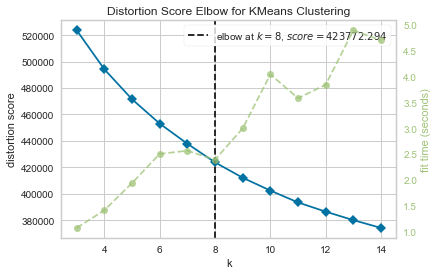

In [12]:
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

In [13]:
if exp_config.num_cluster_config == ExperimentConfig.NUM_CLUSTERS_CONFIG_ELBOW:
    num_clusters = visualizer.elbow_value_
else:
    num_clusters = 2 * visualizer.elbow_value_
if num_clusters < 10:
    num_clusters = 10
#num_clusters = 16

In [14]:
num_clusters

10

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification_gaussian/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-936
 [*] Success to read SemiSupervisedClassifierMnist.model-936
 [*] Load SUCCESS


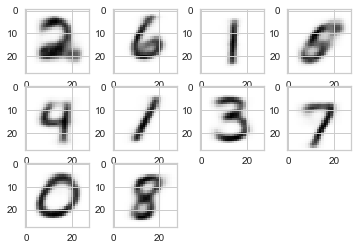

In [15]:
import json
import cv2
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
if not os.path.isfile(manual_annotation_file_json):
    #Cluster and decode the cluster center
    decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                        num_clusters,
                                                                                        latent_vectors,
                                                                                        exp_config,
                                                                                        dao
                                                                                       )
    display_cluster_center_images(decoded_images, image_filename, cluster_centers)
else:
    #TODO fix the issues in image display
#     plt.figure()
#     plt.imshow(cv2.imread(image_filename))
    with open(manual_annotation_file_json, "r") as json_file:
        manual_annotation_json = json.load(json_file)
    cluster_labels = np.asarray(manual_annotation_json["cluster_labels"])
    cluster_centers = np.asarray(manual_annotation_json["cluster_centers"])   
    img = Image.open(image_filename)
    img.show()
    

# Get the labels and confidence manualy,  -1 for unknown/invalid label

## Important:- Edit the values of `manual_annotation_json["manual_labels"]` and `manual_annotation_json["manual_confidence"]` manually looking at the cluster centers above. Also show  the images and  get  annotaions from few other samples closer to the cluster cetner

In [16]:
manual_annotation_json = None
if manual_annotation_json is None:
    #TODO get the input from console or a gui app. For now edit the values directly here
    print("Getting manual_annotation")
    manual_annotation_json = dict()
    manual_annotation_json["manual_labels"] = [2, 6,1,-1,
                                               4,1,3,7,
                                               0, 8
                                              ]
    manual_annotation_json["manual_confidence"] = [0.8,0.8,1,0,
                                                  0.7, 1, 0.8, 0.9,
                                                  1, 0.8]
    
    manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
    manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
    with open(manual_annotation_file_json, "w") as json_file:
        json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [17]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

# TODO Split each of the cluster  into two/three  clusters, based on the manual label and confidence

In [18]:
cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

In [19]:
cluster_group_dict

{'good_clusters': <clearn.analysis.ClusterGroup at 0x7fe9100f77d0>,
 None: <clearn.analysis.ClusterGroup at 0x7fe917cef4d0>,
 'unknown_cluster': <clearn.analysis.ClusterGroup at 0x7fe917ceffd0>}

In [20]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
legend_string = "Cluster Number={} Label={}"
matplotlib.rc('font', **font)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


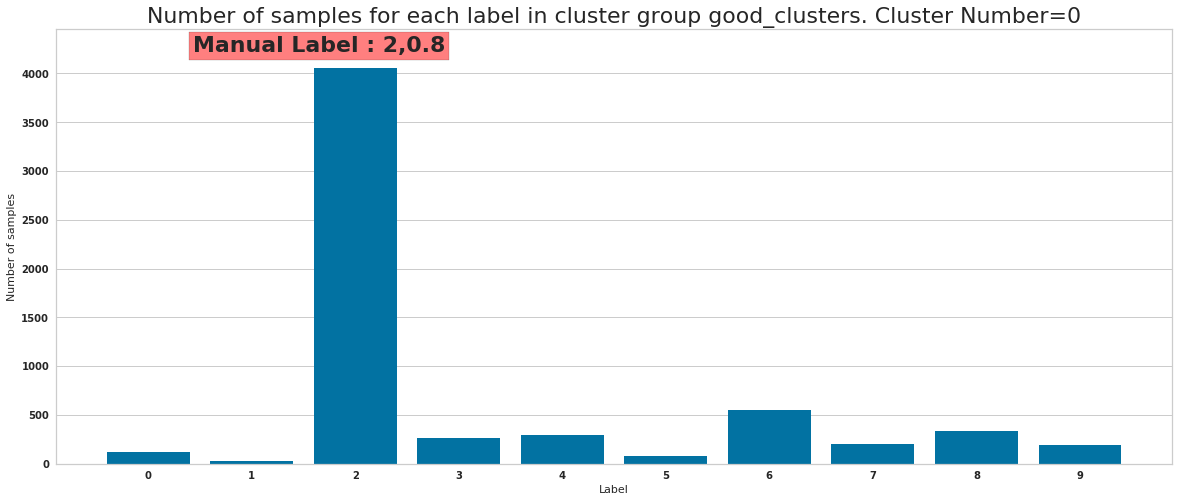

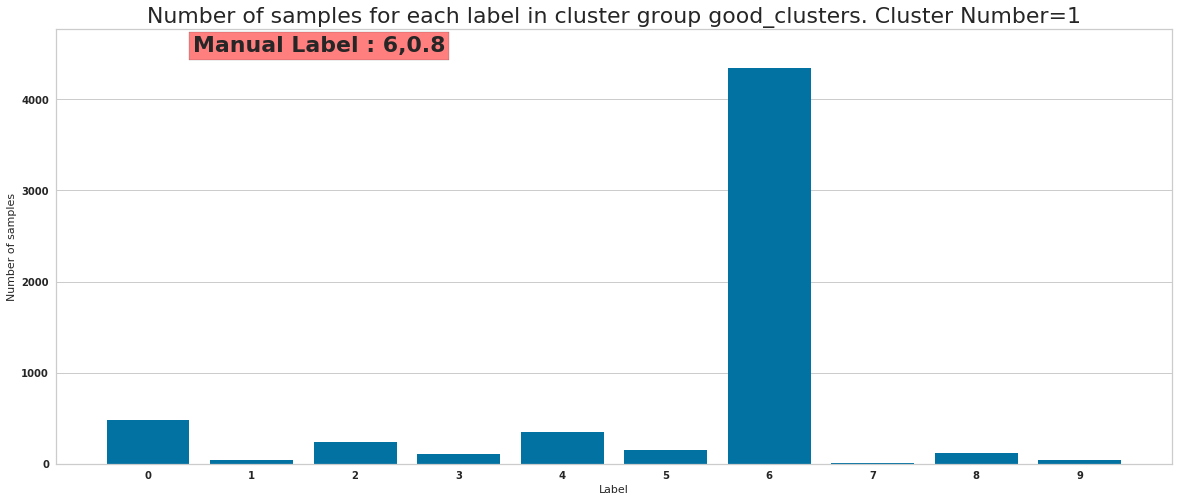

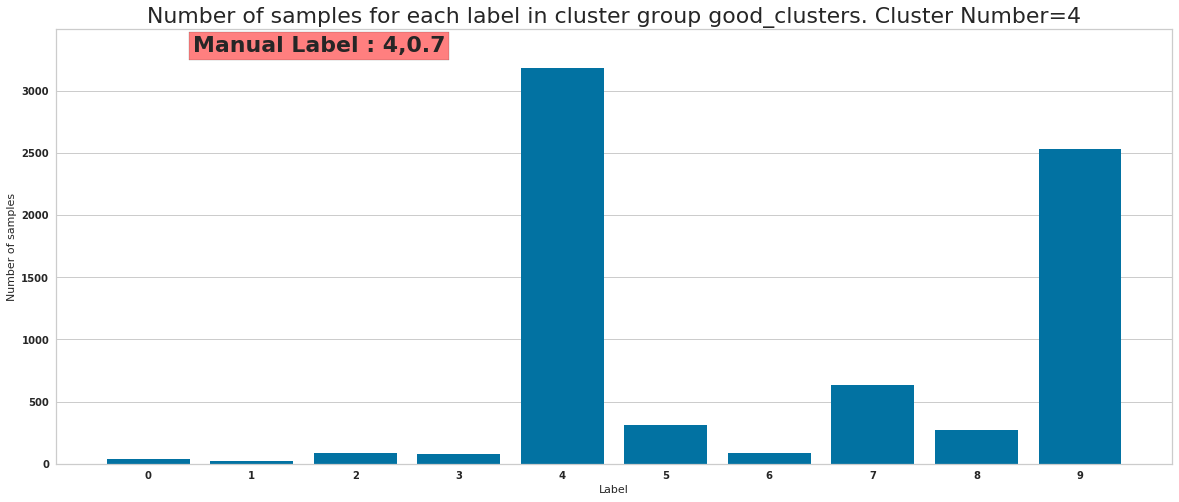

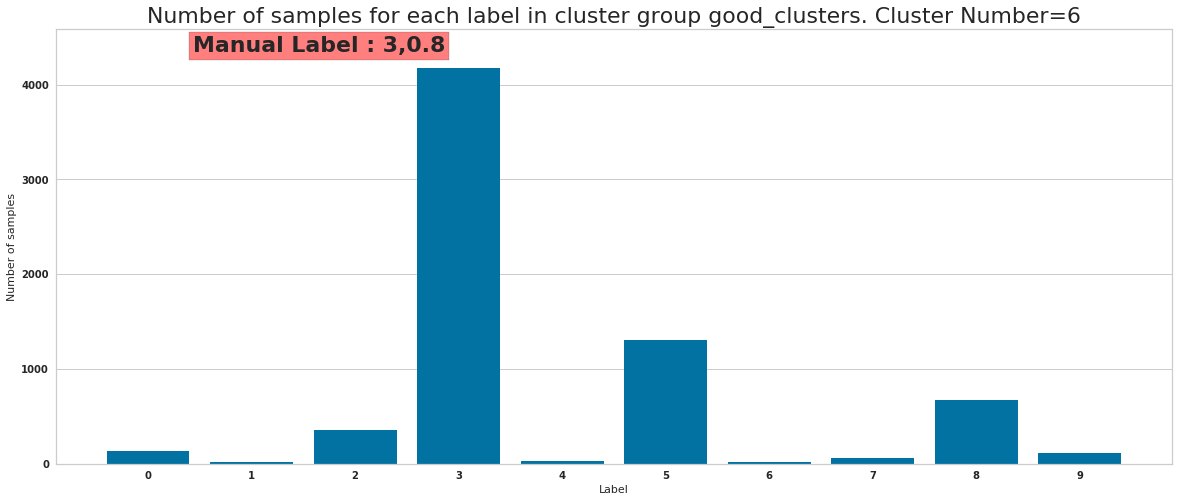

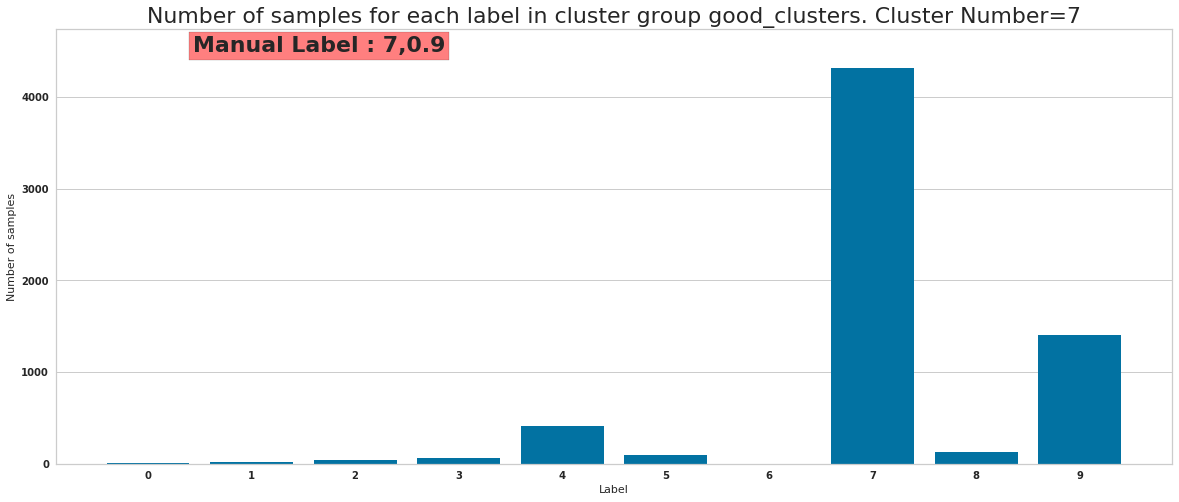

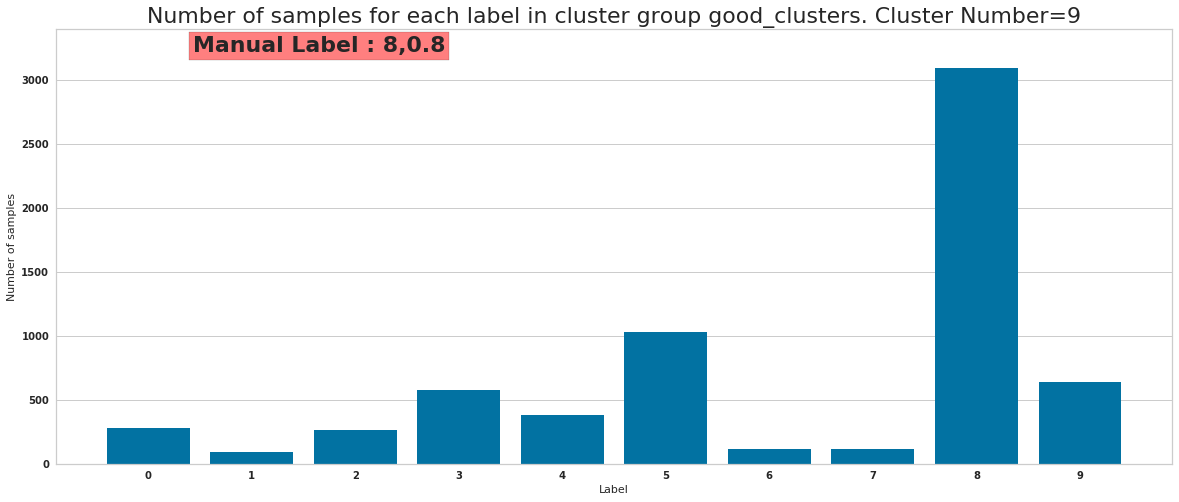

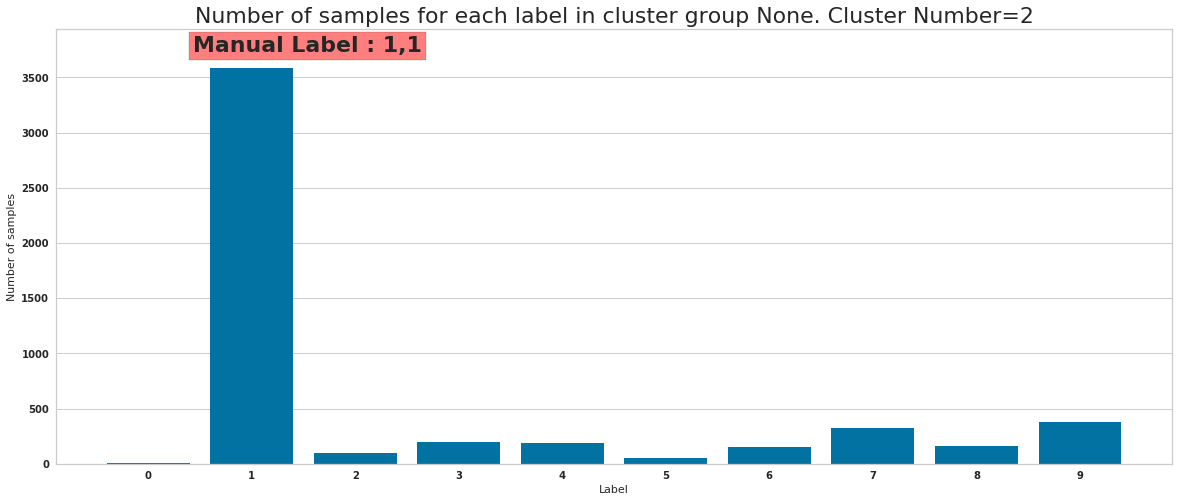

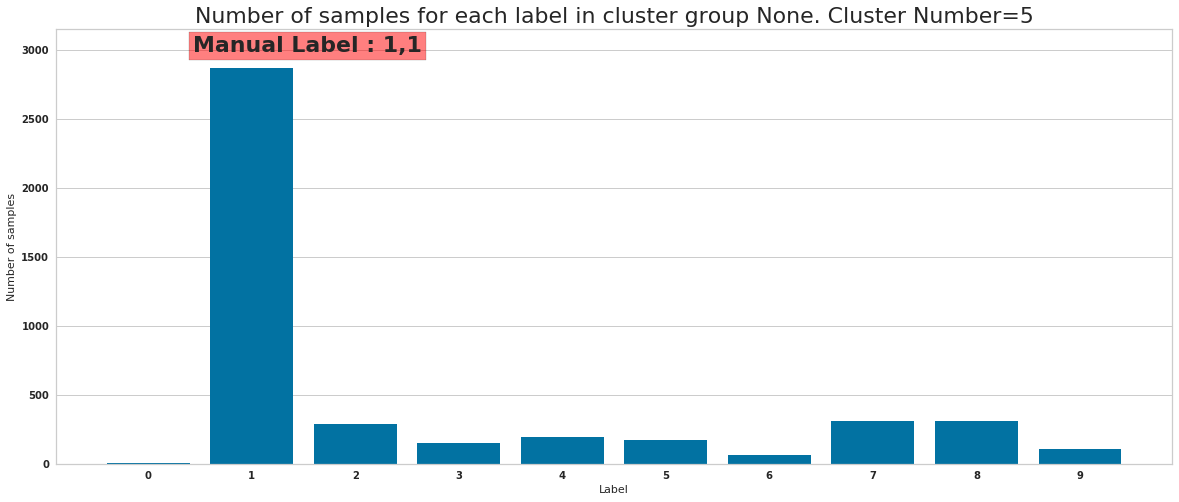

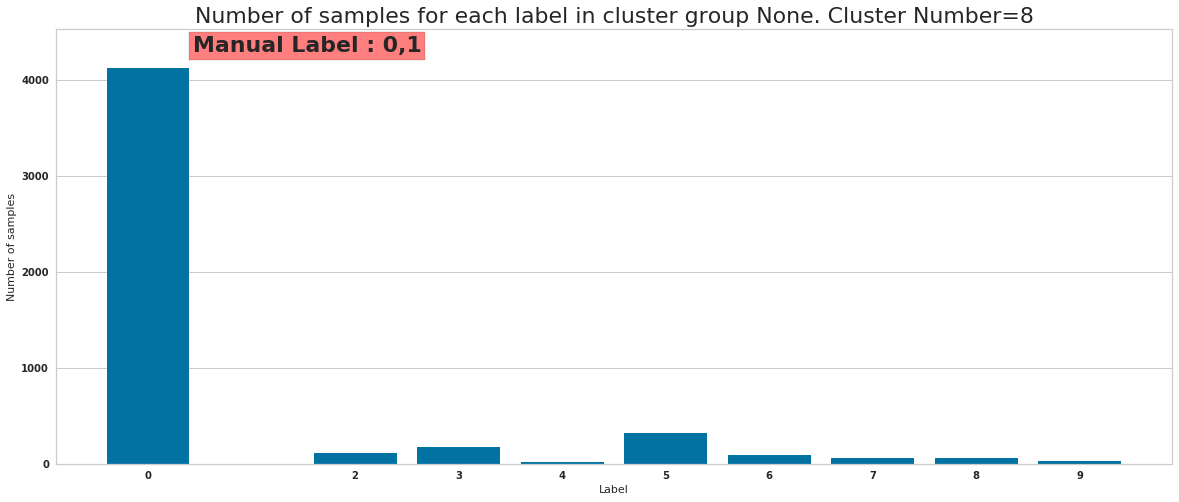

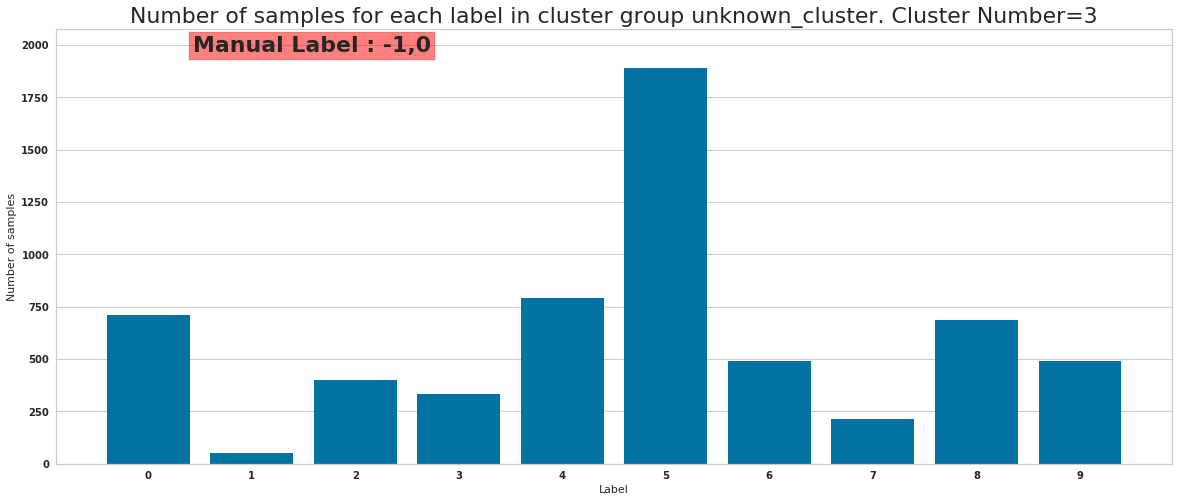

In [21]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

# For each sample, compute distance from respective cluster center

In [22]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


3
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-936
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification_gaussian/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-936
 [*] Success to read SemiSupervisedClassifierMnist.model-936
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


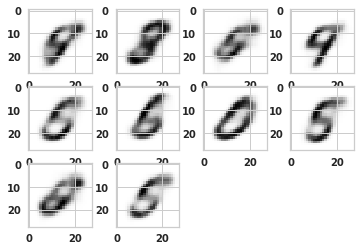

In [23]:
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



In [24]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1,8,-1,-1,
                                        -1,-1,0,5,
                                         -1,-1]
level_2_cluster_dict["manual_confidences"] = [0,0.6,0,0,
                                              0,0, 0.7,0.6,
                                              0,0]
level2_manual_annotations[3] = level_2_cluster_dict


# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [0,2,-1,2,
#                                         2,2,-1,-1,
#                                         -1,2]
# level_2_cluster_dict["manual_confidences"] = [0.8,0.7,0,0.7,
#                                               0.6,0.6,0,0,
#                                               0,0.6
#                                              ]

# level2_manual_annotations[6] = level_2_cluster_dict


# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,9,4,7,
#                                         9,4,9,4,
#                                         4, 9]
# level_2_cluster_dict["manual_confidences"] = [0,0.9,0.6,0.6,
#                                               0.9,0.8,0.8,0.8,
#                                               0.7,0.8
#                                              ]
# level2_manual_annotations[9] = level_2_cluster_dict


# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1, 1, -1,
#                                         -1, -1, -1, 1,
#                                         -1, 1]
# level_2_cluster_dict["manual_confidences"] = [0,0,0,0,
#                                               0,0,0,0,
#                                               0,0
#                                              ]

# level2_manual_annotations[4] = level_2_cluster_dict



In [25]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)

3


In [26]:
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


10
Skipping distance computation for unknown cluster
1 (623,)
7 (557,)
6 (550,)


In [27]:
#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster

In [28]:
level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [3,3,-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0.7,0.7,0,0]


In [29]:
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)

In [30]:
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


In [31]:
cluster_group_dict

{'good_clusters': <clearn.analysis.ClusterGroup at 0x7fe9100f77d0>,
 None: <clearn.analysis.ClusterGroup at 0x7fe917cef4d0>,
 'unknown_cluster': <clearn.analysis.ClusterGroup at 0x7fe917ceffd0>}

In [32]:
def assign_manual_label_and_confidence(df,
                                       manual_annotation_dict,
                                       dist_to_conf,
                                       cluster_group_dict,
                                       cluster_column_name_2,
                                       assign_only_correct=False
                                       ):
    def assign_label(_df, _manual_label):
        _indices = np.where((np.asarray(cluster_labels) == cluster.id)
                            & (_df[cluster_column_name_2].values == _cluster.id))[0]
        _df["manual_annotation"].iloc[_indices] = _manual_label
        dst = _distance_df.iloc[_indices]
        _df["manual_annotation_confidence"].iloc[_indices] = _cluster.manual_annotation.confidence * dist_to_conf(dst)
        _df["distance_to_confidence"].iloc[_indices] = dist_to_conf(dst)
        if assign_only_correct:
            wrong_indices = (_df["manual_annotation"] == _manual_label) & (_df["label"] != _manual_label)
            _df["manual_annotation_confidence"].loc[wrong_indices] = 0

    df["manual_annotation"] = np.ones(df.shape[0]) * -1
    df["manual_annotation_confidence"] = np.zeros(df.shape[0])
    df["distance_to_confidence"] = np.zeros(df.shape[0])
    # manually given label for each cluster center -1 for unknown (cluster which has no semantic meaning)
    manual_labels = manual_annotation_dict["manual_labels"]
    cluster_labels = np.asarray(manual_annotation_dict["cluster_labels"])

    num_clusters = len(manual_labels)
    for annotate_cluster in range(num_clusters):
        distance_df = df["distance_{}".format(annotate_cluster)]
        manual_label = manual_labels[annotate_cluster]
        _manual_confidence = manual_annotation_dict["manual_confidence"][annotate_cluster]
        if isinstance(manual_label, tuple) or isinstance(manual_label, list):
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            for _cluster in cluster.next_level_clusters["good_clusters"]:
                _distance_df = df[f"distance_level_2_{cluster.id}_{_cluster.id}"]
                _manual_label = _cluster.manual_annotation.label
                if isinstance(_manual_label, tuple) or isinstance(_manual_label, list):
                    # TODO add this code
                    pass
                elif _manual_label != -1:
                    assign_label(df, _manual_label)
        elif manual_label != -1:
            print("Manual Label", manual_label)
            indices = np.where(cluster_labels == annotate_cluster)

            df["manual_annotation"].iloc[indices] = manual_label
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            print(df[df["manual_annotation"] == manual_label].shape, cluster.details["cluster_data_frame"].shape)
            num_correct = df[(manual_label == df["manual_annotation"]) & (df["label"] == manual_label)].shape[0]
            print("Num correct={}".format(num_correct))

            percentage_correct = 100 * num_correct / df[df["manual_annotation"] == manual_label].shape[0]
            print(f"Cluster {annotate_cluster} Manual Label {manual_label} Percentage correct {percentage_correct}")
            dist = distance_df.iloc[indices]
            df["manual_annotation_confidence"].iloc[indices] = _manual_confidence * dist_to_conf(dist)
            if assign_only_correct:
                wrong_indices = (df["manual_annotation"] == manual_label) & (df["label"] != manual_label)
                print(len(wrong_indices), wrong_indices.shape)
                df["manual_annotation_confidence"].loc[wrong_indices] = 0
            df["distance_to_confidence"].iloc[indices] = dist_to_conf(dist)
        else:
            print("unknown")
            # TODO second level clustering is not used now so commenting the code
            # unknown, check if second level clustering is done or not
            _, cluster = get_cluster(annotate_cluster, cluster_group_dict)
            print(type(cluster.next_level_clusters))
            print(list(cluster.next_level_clusters.keys()))

            for cluster_group_name, cluster_group in cluster.next_level_clusters.items():
                for _cluster in cluster_group:
                    _distance_df = df[f"distance_level_2_{cluster.id}_{_cluster.id}"]
                    _manual_label = _cluster.manual_annotation.label
                    print(f"********{_manual_label}*******")
                    if isinstance(_manual_label, tuple) or isinstance(_manual_label, list):
                        # TODO add this code
                        pass
                    elif _manual_label != -1:
                        print("Manual_label", _manual_label)
                        assign_label(df, _manual_label)
                    else:
                        # Manual label is -1
                        # Label all the 600 samples in the second level cluster
                        indices = np.where((np.asarray(cluster_labels) == cluster.id)
                                           & (df[cluster_column_name_2].values == _cluster.id))[0]
                        print(f"Annotating individual samples {indices.shape}")
                        df["manual_annotation"].iloc[indices] = df["label"][indices].values
                        df["manual_annotation_confidence"].iloc[indices] = 1

                        _dist = _distance_df.iloc[indices]
                        df["distance_to_confidence"].iloc[indices] = dist_to_conf(_dist)

        print("********************************")


In [33]:
assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2,
                                   assign_only_correct=False
                                  )

Manual Label 2
(6143, 57) (6143, 33)
Num correct=4051
Cluster 0 Manual Label 2 Percentage correct 65.9449780237669
********************************
Manual Label 6
(5885, 57) (5885, 33)
Num correct=4339
Cluster 1 Manual Label 6 Percentage correct 73.72982158028887
********************************
Manual Label 1
(5139, 57) (5139, 33)
Num correct=3581
Cluster 2 Manual Label 1 Percentage correct 69.68281766880716
********************************
unknown
<class 'dict'>
['unknown_cluster', 'average_clusters', 'good_clusters']
********-1*******
Annotating individual samples (705,)
********-1*******
Annotating individual samples (630,)
********-1*******
Annotating individual samples (591,)
********-1*******
Annotating individual samples (582,)
********-1*******
Annotating individual samples (477,)
********-1*******
Annotating individual samples (674,)
********-1*******
Annotating individual samples (663,)
********8*******
Manual_label 8
********5*******
Manual_label 5
********0*******
Manual_l

# Save the dataframe with manual annotations

In [34]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

(array([6143., 5885., 5139., 6052., 7232., 4461., 6872., 6494., 4976.,
        6586.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

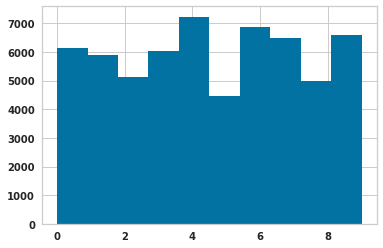

In [35]:
plt.hist(cluster_labels)

# Distribution of distance from cluster center

In [36]:
from clearn.analysis.cluster_utils import plot_distance_distribution

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


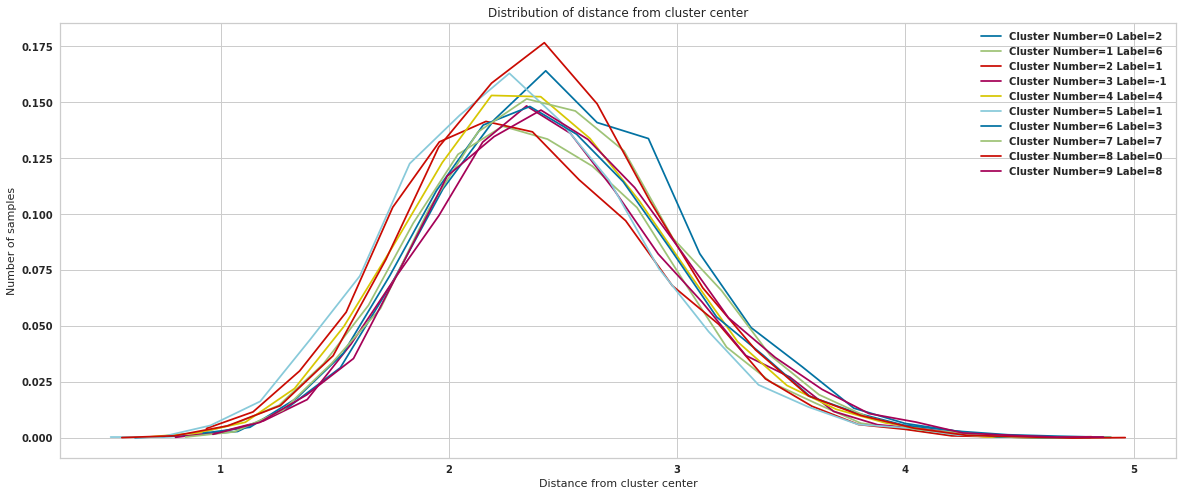

In [37]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

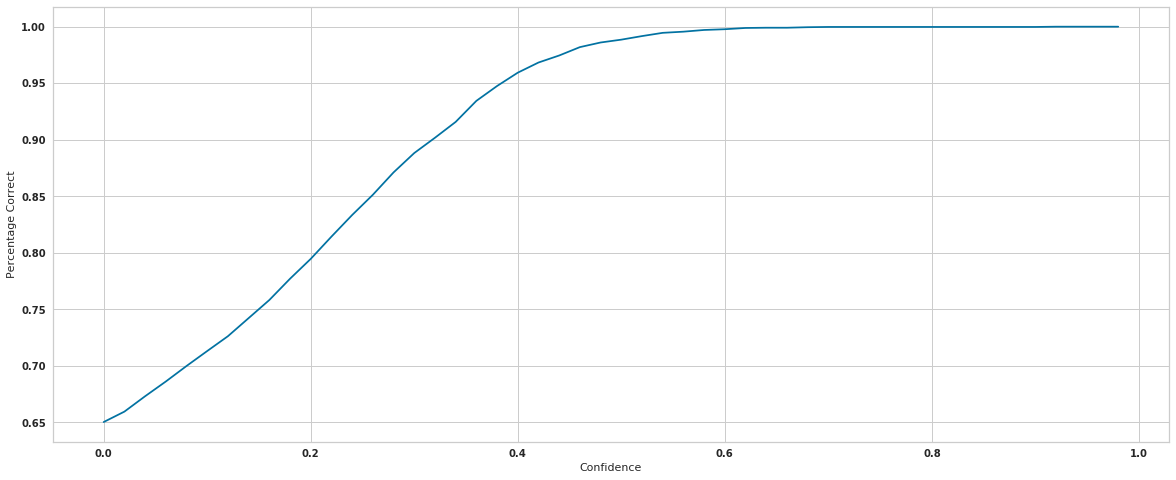

In [38]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

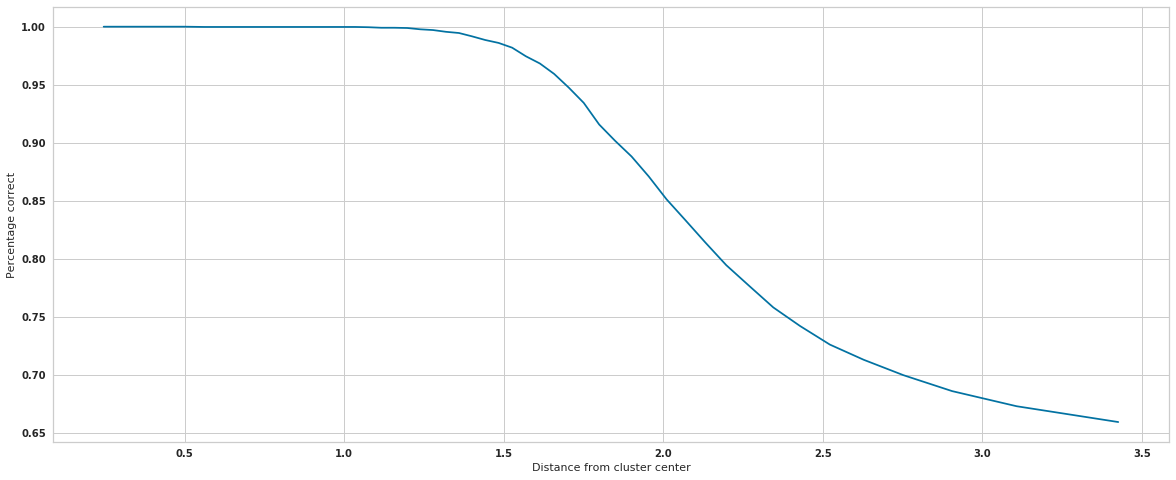

In [39]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [40]:
from shutil import copy2

In [41]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging 
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

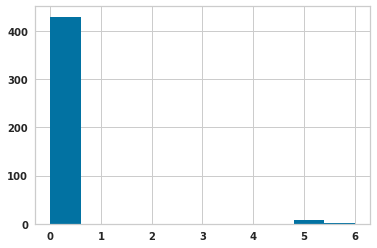

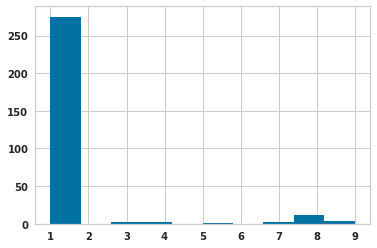

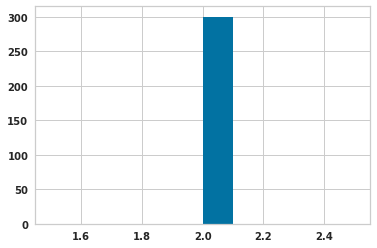

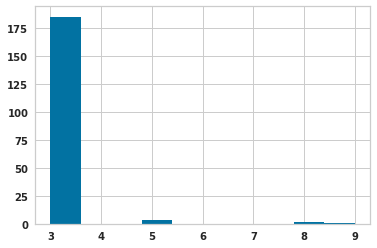

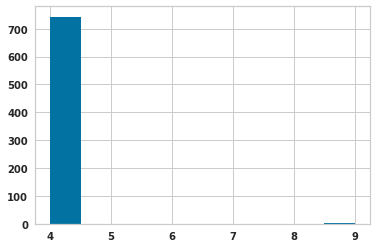

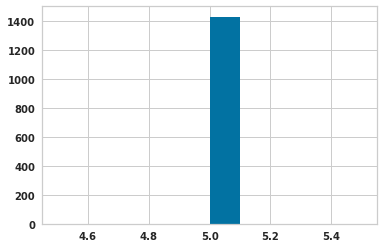

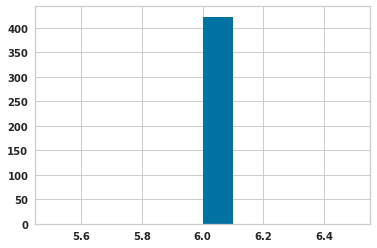

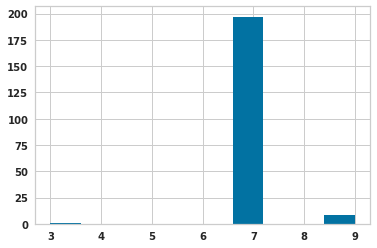

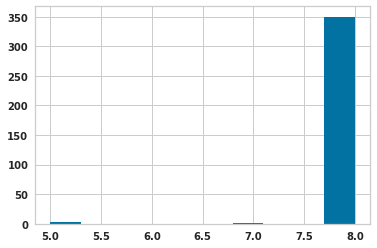

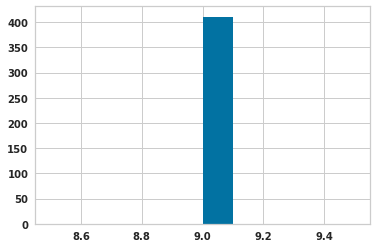

In [42]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [43]:
df.columns

Index(['label', 'label_predicted', 'mu_0', 'mu_1', 'mu_2', 'mu_3', 'mu_4',
       'mu_5', 'mu_6', 'mu_7', 'mu_8', 'mu_9', 'sigma_0', 'sigma_1', 'sigma_2',
       'sigma_3', 'sigma_4', 'sigma_5', 'sigma_6', 'sigma_7', 'sigma_8',
       'sigma_9', 'z_0', 'z_1', 'z_2', 'z_3', 'z_4', 'z_5', 'z_6', 'z_7',
       'z_8', 'z_9', 'cluster_level_1', 'distance_0', 'distance_1',
       'distance_2', 'distance_3', 'distance_4', 'distance_5', 'distance_6',
       'distance_7', 'distance_8', 'distance_9', 'cluster_level_2',
       'distance_level_2_3_0', 'distance_level_2_3_1', 'distance_level_2_3_2',
       'distance_level_2_3_3', 'distance_level_2_3_4', 'distance_level_2_3_5',
       'distance_level_2_3_6', 'distance_level_2_3_7', 'distance_level_2_3_8',
       'distance_level_2_3_9', 'manual_annotation',
       'manual_annotation_confidence', 'distance_to_confidence'],
      dtype='object')

# Iteration 2

In [44]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 45, 'ID': 1, 'name': 'semi_supervised_classification_gaussian'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 11745.476815267184
INFO:tensorflow:Summary name Neg

Epoch: 1/67, Nll_loss : 122.36079406738281 KLD:7.536264896392822  Supervised loss:0.30743172764778137
Epoch: 1/68, Nll_loss : 125.70124816894531 KLD:7.21865177154541  Supervised loss:0.296599805355072
Epoch: 1/69, Nll_loss : 134.72311401367188 KLD:7.581948280334473  Supervised loss:0.24224641919136047
Epoch: 1/70, Nll_loss : 141.44912719726562 KLD:7.523449897766113  Supervised loss:0.22340795397758484
Epoch: 1/71, Nll_loss : 132.9920196533203 KLD:7.326478958129883  Supervised loss:0.254413366317749
Epoch: 1/72, Nll_loss : 132.88687133789062 KLD:7.119809150695801  Supervised loss:0.41603612899780273
Epoch: 1/73, Nll_loss : 136.13746643066406 KLD:7.373752593994141  Supervised loss:0.30007076263427734
Epoch: 1/74, Nll_loss : 131.9263916015625 KLD:7.735881805419922  Supervised loss:0.22090336680412292
Epoch: 1/75, Nll_loss : 140.01846313476562 KLD:8.110652923583984  Supervised loss:0.15511822700500488
Epoch: 1/76, Nll_loss : 129.64898681640625 KLD:7.966636657714844  Supervised loss:0.27527

Epoch: 1/150, Nll_loss : 128.0889434814453 KLD:7.781480312347412  Supervised loss:0.2575286030769348
Epoch: 1/151, Nll_loss : 137.336181640625 KLD:8.56245231628418  Supervised loss:0.18727800250053406
Epoch: 1/152, Nll_loss : 130.69491577148438 KLD:8.027704238891602  Supervised loss:0.13194583356380463
Epoch: 1/153, Nll_loss : 128.4041748046875 KLD:7.902084827423096  Supervised loss:0.19804200530052185
Epoch: 1/154, Nll_loss : 125.93998718261719 KLD:8.357793807983398  Supervised loss:0.20993788540363312
Epoch: 1/155, Nll_loss : 133.46279907226562 KLD:8.134413719177246  Supervised loss:0.25565335154533386
Epoch: 1/156, Nll_loss : 138.9632568359375 KLD:7.650235176086426  Supervised loss:0.19398537278175354
Epoch: 1/157, Nll_loss : 134.68592834472656 KLD:7.179080486297607  Supervised loss:0.19107189774513245
Epoch: 1/158, Nll_loss : 133.79690551757812 KLD:7.966430187225342  Supervised loss:0.1940864771604538
Epoch: 1/159, Nll_loss : 130.72726440429688 KLD:7.316493034362793  Supervised los

Epoch: 1/231, Nll_loss : 133.6476593017578 KLD:7.834930896759033  Supervised loss:0.18659114837646484
Epoch: 1/232, Nll_loss : 134.420654296875 KLD:7.677596569061279  Supervised loss:0.23898202180862427
Epoch: 1/233, Nll_loss : 125.62059783935547 KLD:7.771613597869873  Supervised loss:0.15170660614967346
Epoch: 1/234, Nll_loss : 128.21713256835938 KLD:7.950593948364258  Supervised loss:0.15969818830490112
Epoch: 1/235, Nll_loss : 134.69876098632812 KLD:7.234029769897461  Supervised loss:0.16662809252738953
Epoch: 1/236, Nll_loss : 133.6611785888672 KLD:7.326859474182129  Supervised loss:0.16839846968650818
Epoch: 1/237, Nll_loss : 132.2017364501953 KLD:7.54134464263916  Supervised loss:0.21328334510326385
Epoch: 1/238, Nll_loss : 139.8199005126953 KLD:7.4588623046875  Supervised loss:0.17749807238578796
Epoch: 1/239, Nll_loss : 130.1296844482422 KLD:7.6389617919921875  Supervised loss:0.15594765543937683
Epoch: 1/240, Nll_loss : 128.3798828125 KLD:8.073363304138184  Supervised loss:0.2

Epoch: 1/313, Nll_loss : 136.89639282226562 KLD:8.336543083190918  Supervised loss:0.20842085778713226
Epoch: 1/314, Nll_loss : 135.8201446533203 KLD:8.044458389282227  Supervised loss:0.17098572850227356
Epoch: 1/315, Nll_loss : 122.8394775390625 KLD:8.220392227172852  Supervised loss:0.17783567309379578
Epoch: 1/316, Nll_loss : 123.09458923339844 KLD:8.228073120117188  Supervised loss:0.16931799054145813
Epoch: 1/317, Nll_loss : 124.302734375 KLD:8.054304122924805  Supervised loss:0.1828831136226654
Epoch: 1/318, Nll_loss : 124.88691711425781 KLD:7.800748825073242  Supervised loss:0.22609344124794006
Epoch: 1/319, Nll_loss : 123.1026611328125 KLD:8.07981014251709  Supervised loss:0.22402597963809967
Epoch: 1/320, Nll_loss : 131.28704833984375 KLD:7.908024311065674  Supervised loss:0.1638323813676834
Epoch: 1/321, Nll_loss : 126.8884048461914 KLD:7.3502044677734375  Supervised loss:0.21147114038467407
Epoch: 1/322, Nll_loss : 132.1846923828125 KLD:7.5045061111450195  Supervised loss:0

Epoch: 1/396, Nll_loss : 126.22500610351562 KLD:8.216133117675781  Supervised loss:0.18750494718551636
Epoch: 1/397, Nll_loss : 123.19596862792969 KLD:8.74026870727539  Supervised loss:0.12560728192329407
Epoch: 1/398, Nll_loss : 122.62493896484375 KLD:8.10325813293457  Supervised loss:0.15325003862380981
Epoch: 1/399, Nll_loss : 136.76315307617188 KLD:8.321365356445312  Supervised loss:0.11042505502700806
Epoch: 1/400, Nll_loss : 131.18606567382812 KLD:8.358590126037598  Supervised loss:0.2015911340713501
Epoch: 1/401, Nll_loss : 129.9041748046875 KLD:7.591342926025391  Supervised loss:0.16716107726097107
Epoch: 1/402, Nll_loss : 119.89192199707031 KLD:7.892399787902832  Supervised loss:0.19381341338157654
Epoch: 1/403, Nll_loss : 130.69512939453125 KLD:7.715785980224609  Supervised loss:0.16874045133590698
Epoch: 1/404, Nll_loss : 131.7471923828125 KLD:7.419419765472412  Supervised loss:0.2650749981403351
Epoch: 1/405, Nll_loss : 124.86675262451172 KLD:7.114587306976318  Supervised l

Epoch: 1/479, Nll_loss : 123.96875 KLD:8.48619270324707  Supervised loss:0.14271460473537445
Epoch: 1/480, Nll_loss : 130.25283813476562 KLD:8.707082748413086  Supervised loss:0.15852227807044983
Epoch: 1/481, Nll_loss : 124.26565551757812 KLD:8.464808464050293  Supervised loss:0.09804552793502808
Epoch: 1/482, Nll_loss : 131.29151916503906 KLD:8.144623756408691  Supervised loss:0.17286376655101776
Epoch: 1/483, Nll_loss : 133.96786499023438 KLD:7.984580039978027  Supervised loss:0.20473259687423706
Epoch: 1/484, Nll_loss : 129.19381713867188 KLD:7.68430233001709  Supervised loss:0.15384873747825623
Epoch: 1/485, Nll_loss : 128.55972290039062 KLD:7.614370346069336  Supervised loss:0.20067651569843292
Epoch: 1/486, Nll_loss : 126.47713470458984 KLD:7.991765022277832  Supervised loss:0.14241957664489746
Epoch: 1/487, Nll_loss : 136.9567108154297 KLD:7.748135089874268  Supervised loss:0.195268914103508
Epoch: 1/488, Nll_loss : 129.82064819335938 KLD:7.747361183166504  Supervised loss:0.14

Epoch: 1/560, Nll_loss : 125.9289321899414 KLD:8.110251426696777  Supervised loss:0.13398140668869019
Epoch: 1/561, Nll_loss : 121.12092590332031 KLD:7.840431213378906  Supervised loss:0.22405709326267242
Epoch: 1/562, Nll_loss : 123.89747619628906 KLD:7.826959609985352  Supervised loss:0.22382792830467224
Epoch: 1/563, Nll_loss : 125.69914245605469 KLD:7.839879035949707  Supervised loss:0.1919267624616623
Epoch: 1/564, Nll_loss : 126.32640075683594 KLD:7.991556644439697  Supervised loss:0.12743297219276428
Epoch: 1/565, Nll_loss : 128.7252655029297 KLD:8.04798698425293  Supervised loss:0.1706743985414505
Epoch: 1/566, Nll_loss : 122.13663482666016 KLD:7.804737567901611  Supervised loss:0.11016404628753662
Epoch: 1/567, Nll_loss : 131.85728454589844 KLD:7.716348648071289  Supervised loss:0.1579294502735138
Epoch: 1/568, Nll_loss : 125.7041015625 KLD:7.9534382820129395  Supervised loss:0.1897604763507843
Epoch: 1/569, Nll_loss : 123.67647552490234 KLD:7.779459476470947  Supervised loss:

Epoch: 1/641, Nll_loss : 122.57617950439453 KLD:8.437967300415039  Supervised loss:0.10614298284053802
Epoch: 1/642, Nll_loss : 124.19570922851562 KLD:8.550912857055664  Supervised loss:0.2534130811691284
Epoch: 1/643, Nll_loss : 138.0008544921875 KLD:8.409283638000488  Supervised loss:0.19218696653842926
Epoch: 1/644, Nll_loss : 130.0186309814453 KLD:8.357358932495117  Supervised loss:0.16590413451194763
Epoch: 1/645, Nll_loss : 127.32079315185547 KLD:8.212196350097656  Supervised loss:0.13829496502876282
Epoch: 1/646, Nll_loss : 121.17638397216797 KLD:8.185484886169434  Supervised loss:0.2395830601453781
Epoch: 1/647, Nll_loss : 128.364013671875 KLD:7.879315376281738  Supervised loss:0.17562076449394226
Epoch: 1/648, Nll_loss : 127.33982849121094 KLD:7.83872127532959  Supervised loss:0.16337408125400543
Epoch: 1/649, Nll_loss : 129.75558471679688 KLD:8.226179122924805  Supervised loss:0.14281466603279114
Epoch: 1/650, Nll_loss : 131.38442993164062 KLD:7.806487083435059  Supervised lo

Epoch: 1/722, Nll_loss : 121.6571044921875 KLD:8.477975845336914  Supervised loss:0.1699148714542389
Epoch: 1/723, Nll_loss : 115.34659576416016 KLD:8.550684928894043  Supervised loss:0.21482917666435242
Epoch: 1/724, Nll_loss : 123.86774444580078 KLD:8.668224334716797  Supervised loss:0.11796195805072784
Epoch: 1/725, Nll_loss : 130.10386657714844 KLD:8.452690124511719  Supervised loss:0.12964162230491638
Epoch: 1/726, Nll_loss : 127.03768920898438 KLD:8.305917739868164  Supervised loss:0.1573951095342636
Epoch: 1/727, Nll_loss : 128.49856567382812 KLD:7.873520851135254  Supervised loss:0.21181461215019226
Epoch: 1/728, Nll_loss : 122.90047454833984 KLD:7.653124809265137  Supervised loss:0.18793120980262756
Epoch: 1/729, Nll_loss : 124.16840362548828 KLD:7.757660865783691  Supervised loss:0.1437447965145111
Epoch: 1/730, Nll_loss : 121.15165710449219 KLD:7.391402244567871  Supervised loss:0.12143329530954361
Epoch: 1/731, Nll_loss : 125.06288146972656 KLD:7.685481071472168  Supervised

Epoch: 1/803, Nll_loss : 124.6237564086914 KLD:8.34665298461914  Supervised loss:0.09725126624107361
Epoch: 1/804, Nll_loss : 120.42566680908203 KLD:7.897940158843994  Supervised loss:0.14082270860671997
Epoch: 1/805, Nll_loss : 124.52159881591797 KLD:7.885553359985352  Supervised loss:0.10741015523672104
Epoch: 1/806, Nll_loss : 130.6703643798828 KLD:7.708783149719238  Supervised loss:0.08847557008266449
Epoch: 1/807, Nll_loss : 123.57292175292969 KLD:8.037740707397461  Supervised loss:0.15185707807540894
Epoch: 1/808, Nll_loss : 124.37999725341797 KLD:7.591853141784668  Supervised loss:0.14292623102664948
Epoch: 1/809, Nll_loss : 121.47023010253906 KLD:7.742015361785889  Supervised loss:0.17476865649223328
Epoch: 1/810, Nll_loss : 127.4936752319336 KLD:7.7197771072387695  Supervised loss:0.2292449176311493
Epoch: 1/811, Nll_loss : 130.4398651123047 KLD:7.915729522705078  Supervised loss:0.17566785216331482
Epoch: 1/812, Nll_loss : 127.97284698486328 KLD:7.728644371032715  Supervised 

Epoch: 1/884, Nll_loss : 115.31919860839844 KLD:8.289628028869629  Supervised loss:0.15059328079223633
Epoch: 1/885, Nll_loss : 129.31704711914062 KLD:8.30501937866211  Supervised loss:0.11827655136585236
Epoch: 1/886, Nll_loss : 121.48961639404297 KLD:7.983066558837891  Supervised loss:0.1337878257036209
Epoch: 1/887, Nll_loss : 124.60128021240234 KLD:8.309314727783203  Supervised loss:0.2015354186296463
Epoch: 1/888, Nll_loss : 129.17864990234375 KLD:7.64134407043457  Supervised loss:0.14663676917552948
Epoch: 1/889, Nll_loss : 119.58512878417969 KLD:7.862404823303223  Supervised loss:0.14905592799186707
Epoch: 1/890, Nll_loss : 125.17013549804688 KLD:7.792016983032227  Supervised loss:0.14227166771888733
Epoch: 1/891, Nll_loss : 132.0596466064453 KLD:7.5356268882751465  Supervised loss:0.13593855500221252
Epoch: 1/892, Nll_loss : 135.8820343017578 KLD:7.973908424377441  Supervised loss:0.1589653342962265
Epoch: 1/893, Nll_loss : 125.97595977783203 KLD:8.284873008728027  Supervised l

In [45]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-1870
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification_gaussian/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-1870
 [*] Success to read SemiSupervisedClassifierMnist.model-1870
 [*] Load SUCCESS
Number of steps completed=1870
Number of epochs completed 2.0


In [46]:
filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)


run_id=45 z_min=-4.1833196 z_max=4.2373085
Latent vectors shape (59840, 10)


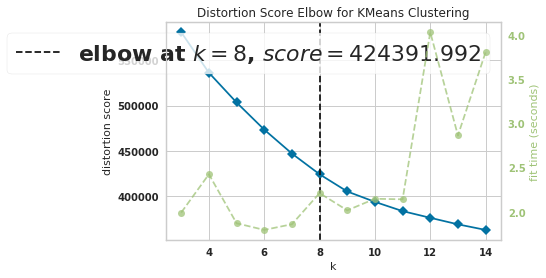

In [47]:
kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-1870
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification_gaussian/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-1870
 [*] Success to read SemiSupervisedClassifierMnist.model-1870
 [*] Load SUCCESS


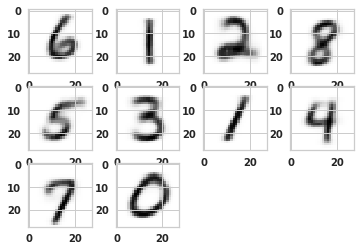

In [48]:
num_clusters = 10
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [54]:
import json
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [6, 1, 2, 8,
                                           5, 3, 1, 4,
                                           7, 0
                                          ]
manual_annotation_json["manual_confidence"] = [0.9, 1, 0.9,0.9,
                                               0.7,0.8,1,0.8,
                                               0.8,1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)

Getting manual_annotation


In [55]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

In [57]:
cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df) 

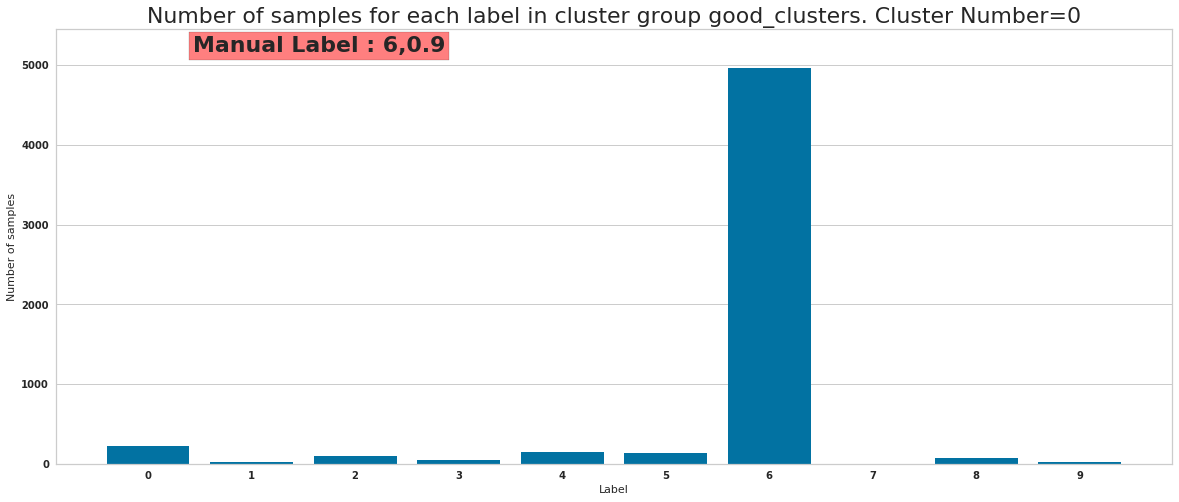

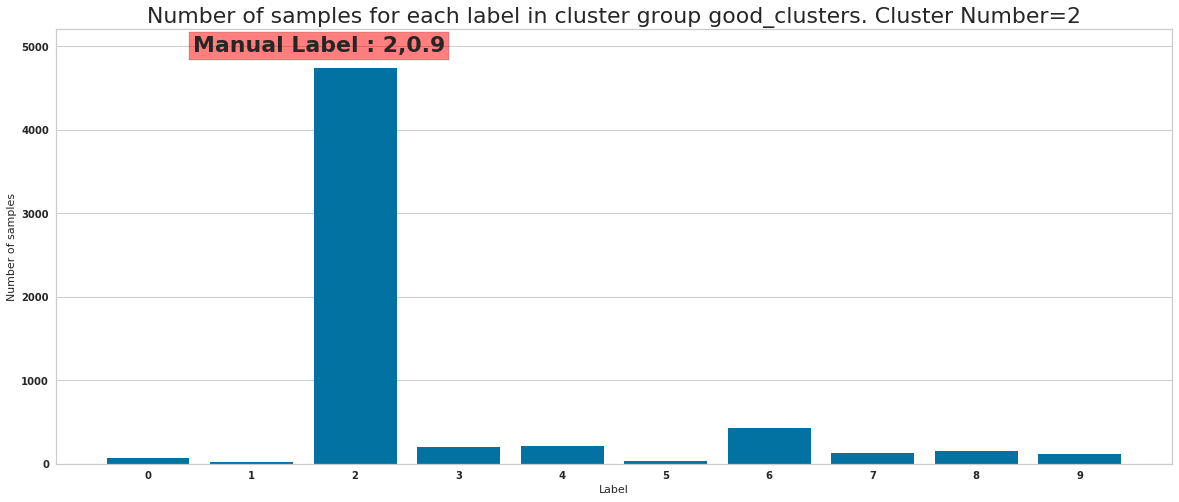

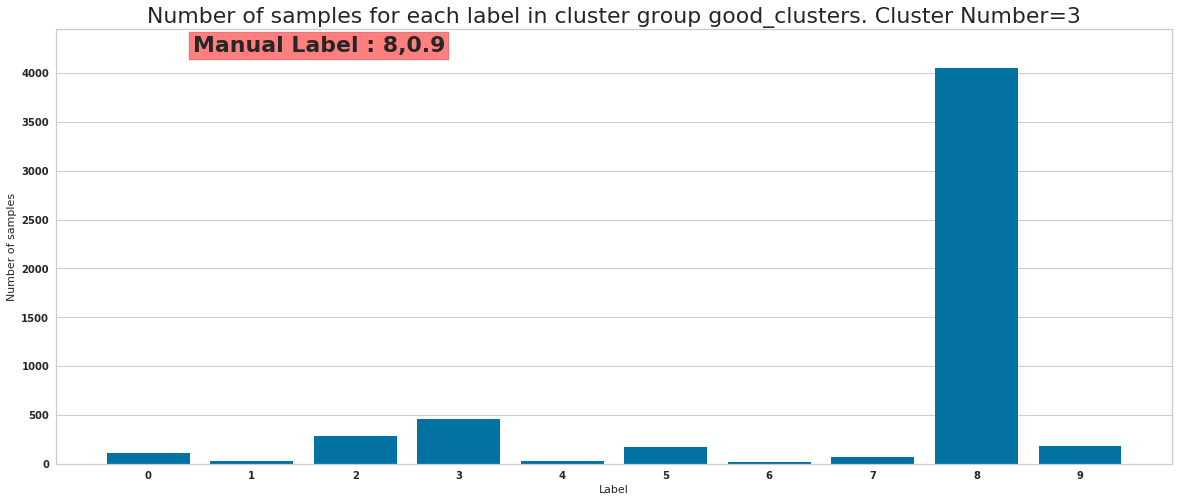

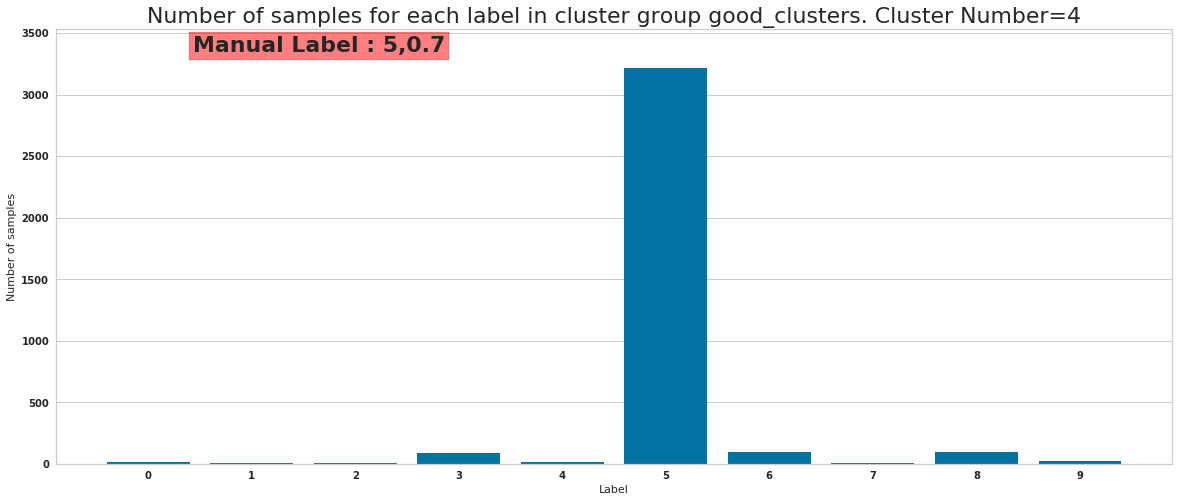

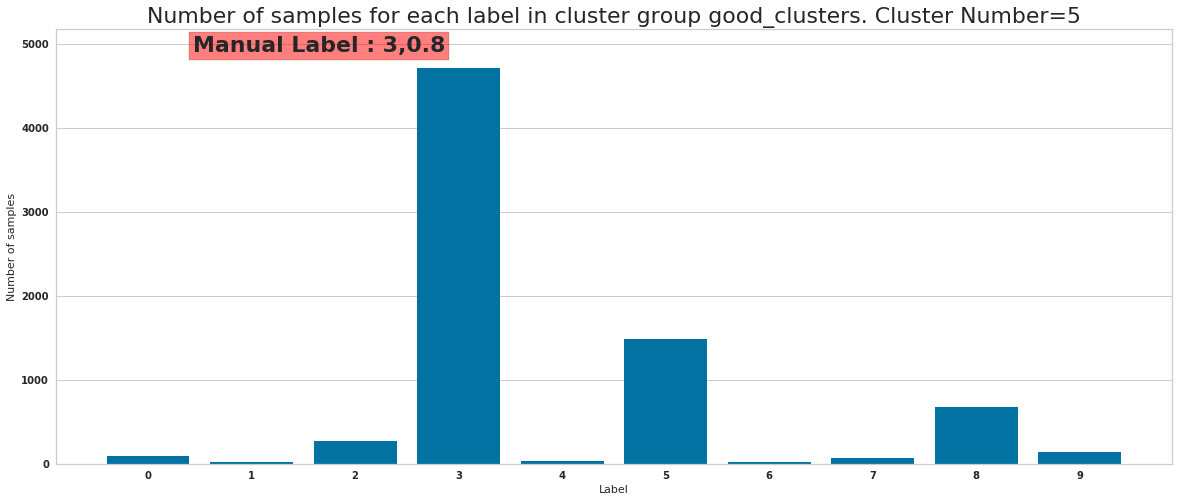

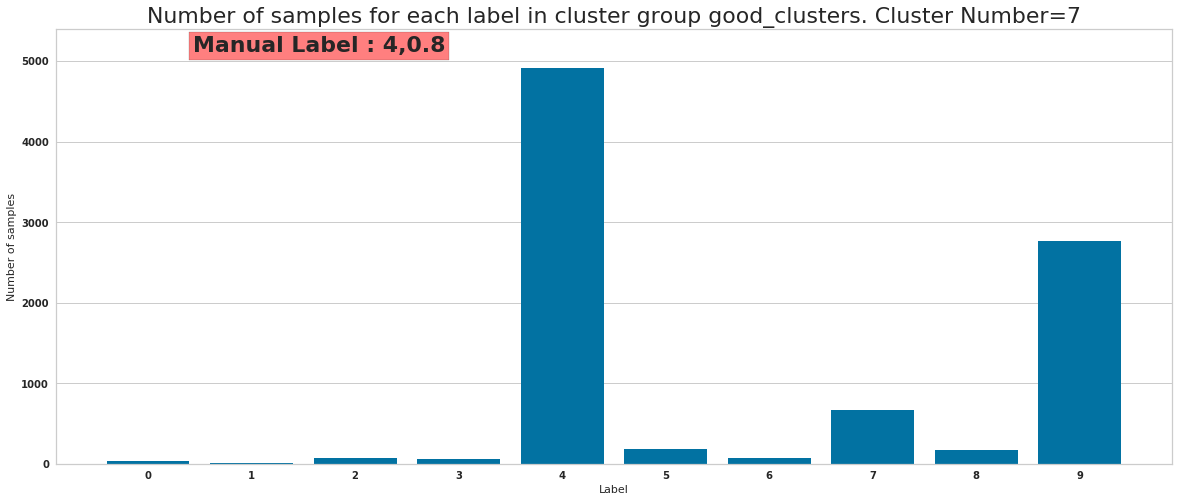

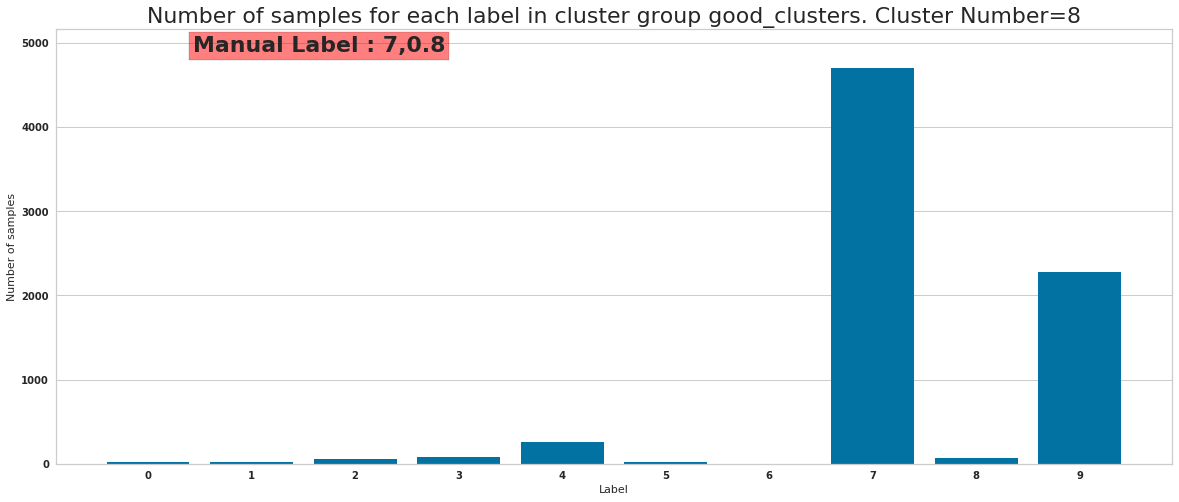

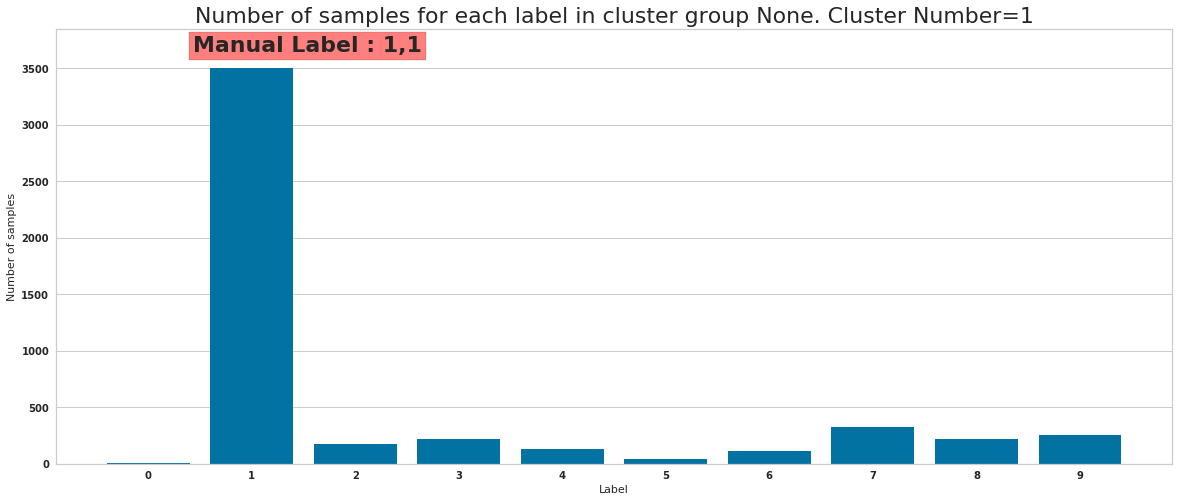

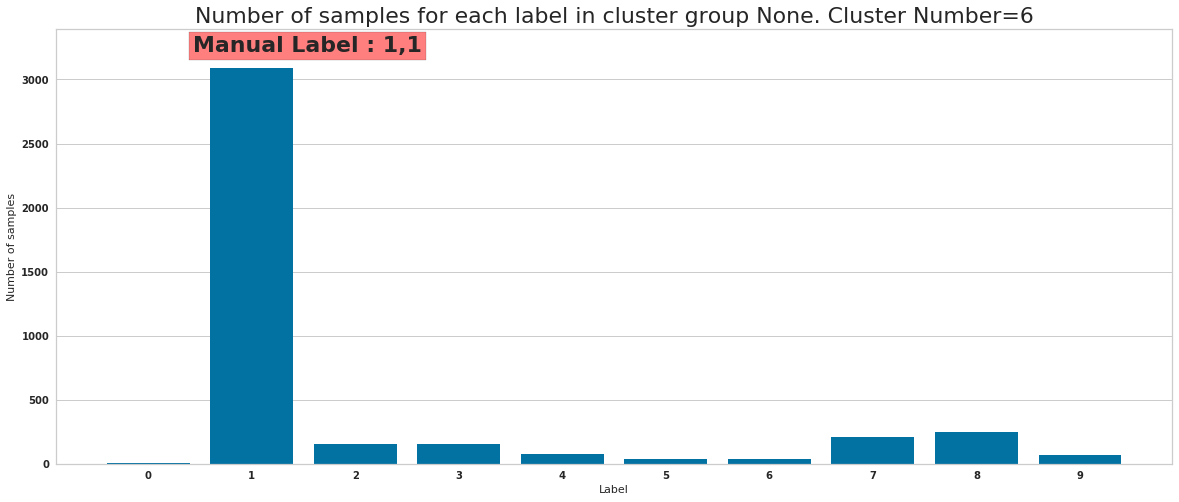

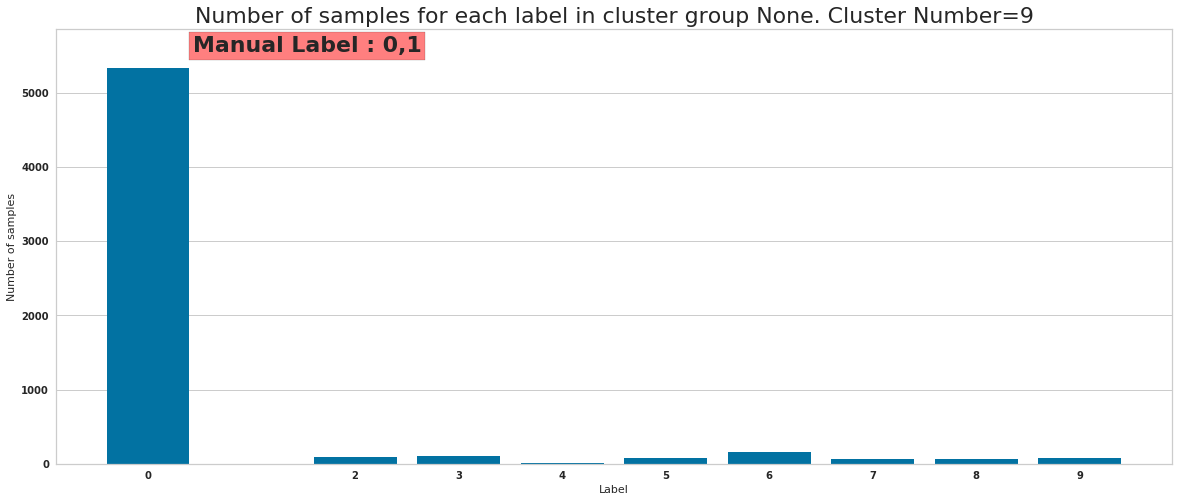

In [58]:
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [59]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)

In [60]:
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



In [61]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,3,0,5,
#                                         -1,5,-1,-1,
#                                         -1,8]
# level_2_cluster_dict["manual_confidences"] = [0,0.7,0.9,0.6,
#                                              0,0.6,0,0,
#                                              0, 0.7]
# level2_manual_annotations[0] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [1,5,-1,-1,
#                                         -1,5,8,-1,
#                                         -1,-1]
# level_2_cluster_dict["manual_confidences"] = [1,0.6,0,0,
#                                              0,0.6,0.6,0,
#                                              0,0]
# level2_manual_annotations[7] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [4,9,9,9,
#                                         4,9,9,9,
#                                         4,9]
# level_2_cluster_dict["manual_confidences"] = [0.8,0.9,0.9,0.9,
#                                               0.8,0.9,0.9,0.9,
#                                               0.8,0.9
#                                              ]
# level2_manual_annotations[6] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [0, -1]
# level_2_cluster_dict["manual_confidences"] = [0.7, 0]
# level2_manual_annotations[14] = level_2_cluster_dict



In [62]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 6
(5728, 47) (5728, 44)
Num correct=4957
Cluster 0 Manual Label 6 Percentage correct 86.53980446927375
********************************
Manual Label 1
(4966, 47) (4966, 44)
Num correct=3498
Cluster 1 Manual Label 1 Percentage correct 70.43898509867097
********************************
Manual Label 2
(6105, 47) (6105, 44)
Num correct=4736
Cluster 2 Manual Label 2 Percentage correct 77.57575757575758
********************************
Manual Label 8
(5412, 47) (5412, 44)
Num correct=4048
Cluster 3 Manual Label 8 Percentage correct 74.79674796747967
********************************
Manual Label 5
(3560, 47) (3560, 44)
Num correct=3213
Cluster 4 Manual Label 5 Percentage correct 90.25280898876404
********************************
Manual Label 3
(7539, 47) (7539, 44)
Num correct=4711
Cluster 5 Manual Label 3 Percentage correct 62.488393686165274
********************************
Manual Label 1
(9055, 47) (4089, 44)
Num correct=6584
Cluster 6 Manual Label 1 Percentage correct 72.7112

In [63]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

(array([5728., 4966., 6105., 5412., 3560., 7539., 4089., 8953., 7516.,
        5972.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

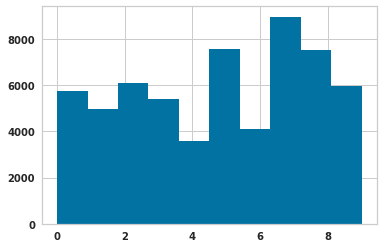

In [64]:
plt.hist(cluster_labels)

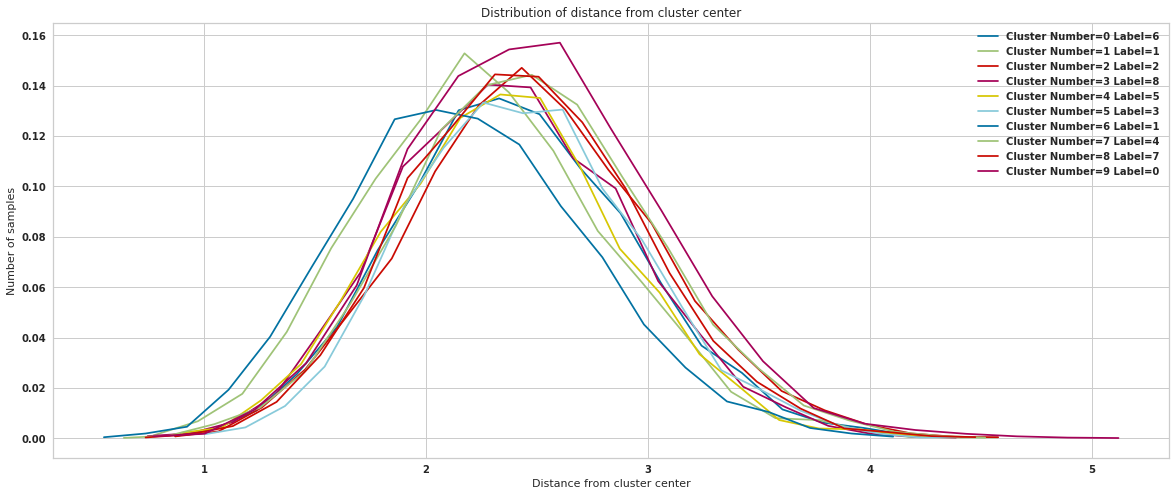

In [65]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

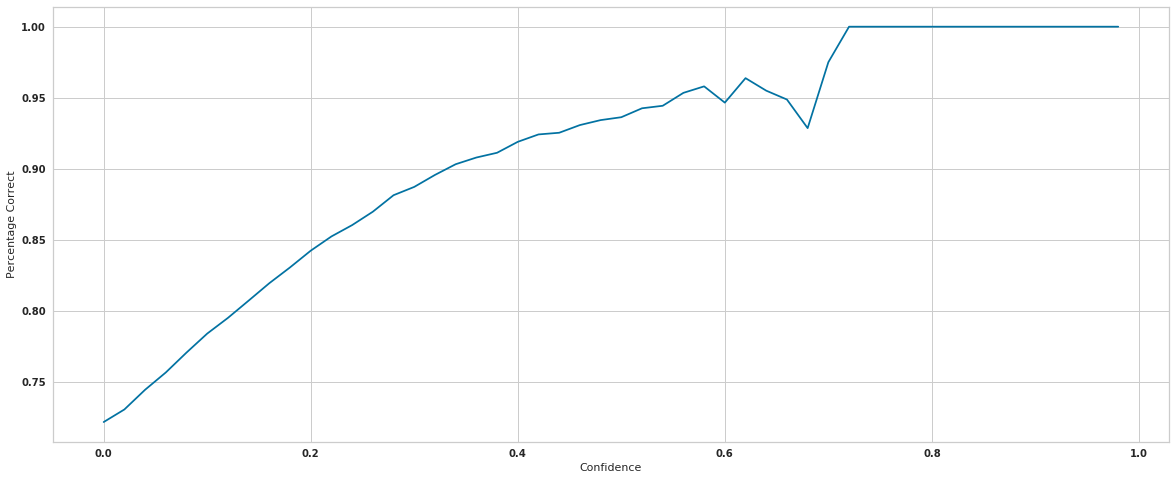

In [66]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

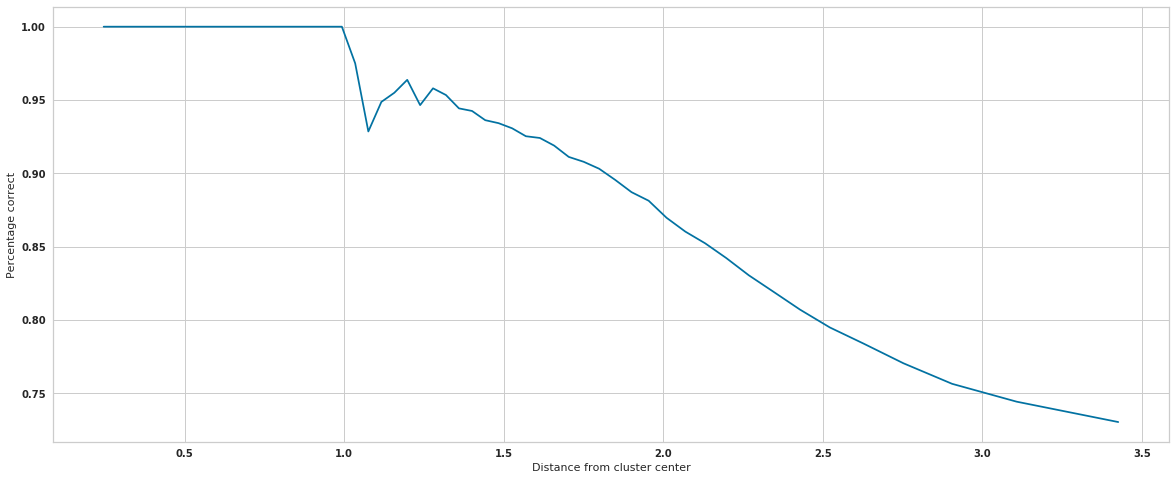

In [67]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

In [68]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

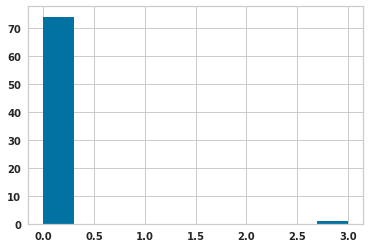

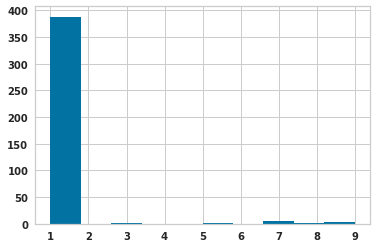

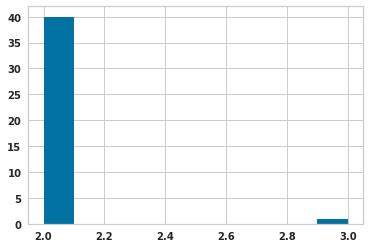

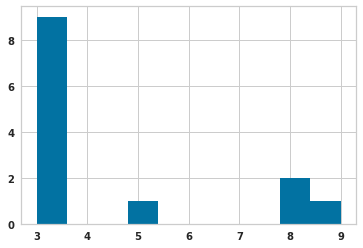

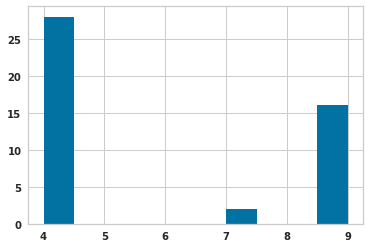

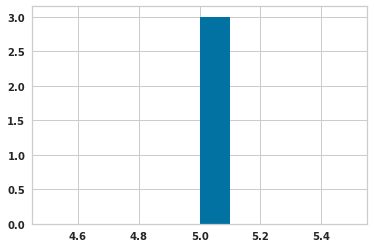

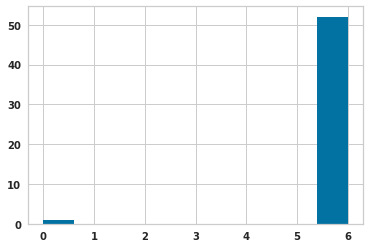

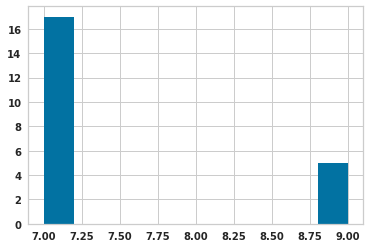

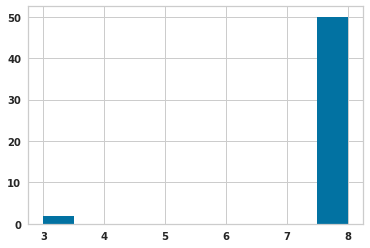

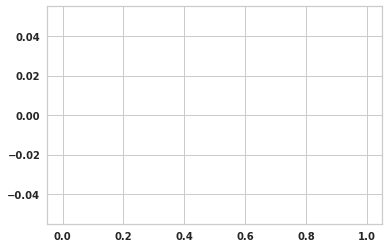

In [69]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 3

In [70]:
num_epochs
num_epochs += 1
print(num_epochs)

3


In [71]:
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
print(manual_annotation_file)

manual_annotation_epoch_2.0.csv


In [72]:
#num_epochs += 1
#manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 45, 'ID': 1, 'name': 'semi_supervised_classification_gaussian'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 8361.736284554481
INFO:tensorflow:Summary name Nega

Epoch: 2/66, Nll_loss : 114.2496337890625 KLD:7.519774913787842  Supervised loss:0.07397274672985077
Epoch: 2/67, Nll_loss : 119.59552764892578 KLD:7.0056257247924805  Supervised loss:0.07881373912096024
Epoch: 2/68, Nll_loss : 127.4764175415039 KLD:7.449833393096924  Supervised loss:0.07342778891324997
Epoch: 2/69, Nll_loss : 130.9775390625 KLD:7.502484321594238  Supervised loss:0.06815114617347717
Epoch: 2/70, Nll_loss : 121.07138061523438 KLD:7.6341142654418945  Supervised loss:0.06021493673324585
Epoch: 2/71, Nll_loss : 122.4083480834961 KLD:7.5263166427612305  Supervised loss:0.05956006795167923
Epoch: 2/72, Nll_loss : 129.27964782714844 KLD:7.477112770080566  Supervised loss:0.08320315927267075
Epoch: 2/73, Nll_loss : 124.98770904541016 KLD:7.48199462890625  Supervised loss:0.07868625223636627
Epoch: 2/74, Nll_loss : 131.93121337890625 KLD:7.800164222717285  Supervised loss:0.05021045356988907
Epoch: 2/75, Nll_loss : 125.07620239257812 KLD:7.476928234100342  Supervised loss:0.063

Epoch: 2/147, Nll_loss : 125.1006088256836 KLD:8.434087753295898  Supervised loss:0.06665150821208954
Epoch: 2/148, Nll_loss : 130.24591064453125 KLD:8.232769012451172  Supervised loss:0.06455859541893005
Epoch: 2/149, Nll_loss : 120.2662582397461 KLD:7.8687334060668945  Supervised loss:0.06735067069530487
Epoch: 2/150, Nll_loss : 127.79823303222656 KLD:8.057979583740234  Supervised loss:0.06978128105401993
Epoch: 2/151, Nll_loss : 124.03262329101562 KLD:7.578799724578857  Supervised loss:0.06868474930524826
Epoch: 2/152, Nll_loss : 128.8226318359375 KLD:7.391217231750488  Supervised loss:0.0755266398191452
Epoch: 2/153, Nll_loss : 120.61648559570312 KLD:7.593876838684082  Supervised loss:0.07188716530799866
Epoch: 2/154, Nll_loss : 130.7169952392578 KLD:7.579562187194824  Supervised loss:0.061553362756967545
Epoch: 2/155, Nll_loss : 132.5306396484375 KLD:7.690340518951416  Supervised loss:0.0791766420006752
Epoch: 2/156, Nll_loss : 125.66716766357422 KLD:7.651949405670166  Supervised 

Epoch: 2/228, Nll_loss : 127.11672973632812 KLD:8.186808586120605  Supervised loss:0.06373052299022675
Epoch: 2/229, Nll_loss : 122.7550277709961 KLD:8.600022315979004  Supervised loss:0.06497638672590256
Epoch: 2/230, Nll_loss : 127.00727081298828 KLD:8.341053009033203  Supervised loss:0.07460038363933563
Epoch: 2/231, Nll_loss : 127.07476806640625 KLD:8.434408187866211  Supervised loss:0.056808747351169586
Epoch: 2/232, Nll_loss : 118.26341247558594 KLD:8.613142013549805  Supervised loss:0.050091568380594254
Epoch: 2/233, Nll_loss : 117.87713623046875 KLD:8.803354263305664  Supervised loss:0.04045849293470383
Epoch: 2/234, Nll_loss : 125.00062561035156 KLD:7.9842610359191895  Supervised loss:0.06765541434288025
Epoch: 2/235, Nll_loss : 122.86807250976562 KLD:8.032228469848633  Supervised loss:0.07881613075733185
Epoch: 2/236, Nll_loss : 123.49465942382812 KLD:7.989776611328125  Supervised loss:0.05116288736462593
Epoch: 2/237, Nll_loss : 130.44915771484375 KLD:7.596242904663086  Supe

Epoch: 2/309, Nll_loss : 120.15856170654297 KLD:7.405766487121582  Supervised loss:0.05417545139789581
Epoch: 2/310, Nll_loss : 130.0767822265625 KLD:7.825861930847168  Supervised loss:0.07921972125768661
Epoch: 2/311, Nll_loss : 131.41189575195312 KLD:7.74240779876709  Supervised loss:0.0783000960946083
Epoch: 2/312, Nll_loss : 129.5114288330078 KLD:8.050277709960938  Supervised loss:0.04867958649992943
Epoch: 2/313, Nll_loss : 127.80746459960938 KLD:7.88028621673584  Supervised loss:0.060112323611974716
Epoch: 2/314, Nll_loss : 118.50181579589844 KLD:7.90442419052124  Supervised loss:0.059619784355163574
Epoch: 2/315, Nll_loss : 120.15098571777344 KLD:7.9061174392700195  Supervised loss:0.06657014042139053
Epoch: 2/316, Nll_loss : 121.01618957519531 KLD:7.846492767333984  Supervised loss:0.06103719025850296
Epoch: 2/317, Nll_loss : 120.72019958496094 KLD:7.662367343902588  Supervised loss:0.07131600379943848
Epoch: 2/318, Nll_loss : 115.8289794921875 KLD:7.912941932678223  Supervised

Epoch: 2/389, Nll_loss : 125.25828552246094 KLD:8.003087997436523  Supervised loss:0.06270463764667511
Epoch: 2/390, Nll_loss : 124.68671417236328 KLD:8.303518295288086  Supervised loss:0.05554593726992607
Epoch: 2/391, Nll_loss : 119.44551086425781 KLD:8.049665451049805  Supervised loss:0.06535426527261734
Epoch: 2/392, Nll_loss : 121.62109375 KLD:8.093984603881836  Supervised loss:0.06164851412177086
Epoch: 2/393, Nll_loss : 127.5906753540039 KLD:8.307351112365723  Supervised loss:0.05563100427389145
Epoch: 2/394, Nll_loss : 123.21826171875 KLD:8.123112678527832  Supervised loss:0.05201151221990585
Epoch: 2/395, Nll_loss : 122.3291015625 KLD:7.913690567016602  Supervised loss:0.06682145595550537
Epoch: 2/396, Nll_loss : 120.95559692382812 KLD:8.292770385742188  Supervised loss:0.0661262571811676
Epoch: 2/397, Nll_loss : 117.32135772705078 KLD:7.687633514404297  Supervised loss:0.08183704316616058
Epoch: 2/398, Nll_loss : 128.21188354492188 KLD:8.376100540161133  Supervised loss:0.061

Epoch: 2/472, Nll_loss : 126.88833618164062 KLD:7.903254508972168  Supervised loss:0.051971543580293655
Epoch: 2/473, Nll_loss : 116.96456909179688 KLD:8.166254997253418  Supervised loss:0.07403506338596344
Epoch: 2/474, Nll_loss : 119.46697998046875 KLD:8.026006698608398  Supervised loss:0.0654444694519043
Epoch: 2/475, Nll_loss : 123.61036682128906 KLD:8.284777641296387  Supervised loss:0.0828324407339096
Epoch: 2/476, Nll_loss : 119.55033874511719 KLD:8.538814544677734  Supervised loss:0.056242167949676514
Epoch: 2/477, Nll_loss : 125.32264709472656 KLD:8.312005043029785  Supervised loss:0.058945223689079285
Epoch: 2/478, Nll_loss : 119.34617614746094 KLD:8.283121109008789  Supervised loss:0.04986951872706413
Epoch: 2/479, Nll_loss : 126.10079193115234 KLD:8.188697814941406  Supervised loss:0.058269254863262177
Epoch: 2/480, Nll_loss : 118.94576263427734 KLD:8.000184059143066  Supervised loss:0.046280764043331146
Epoch: 2/481, Nll_loss : 127.26648712158203 KLD:7.722745895385742  Sup

Epoch: 2/553, Nll_loss : 125.404296875 KLD:8.125015258789062  Supervised loss:0.09285779297351837
Epoch: 2/554, Nll_loss : 124.77388000488281 KLD:8.08069133758545  Supervised loss:0.054862409830093384
Epoch: 2/555, Nll_loss : 121.4197998046875 KLD:8.349900245666504  Supervised loss:0.06937769800424576
Epoch: 2/556, Nll_loss : 126.36089324951172 KLD:8.186014175415039  Supervised loss:0.04602671042084694
Epoch: 2/557, Nll_loss : 120.5520248413086 KLD:8.186803817749023  Supervised loss:0.044338077306747437
Epoch: 2/558, Nll_loss : 122.370361328125 KLD:7.797464847564697  Supervised loss:0.06837146729230881
Epoch: 2/559, Nll_loss : 122.6837158203125 KLD:8.09141731262207  Supervised loss:0.06481123715639114
Epoch: 2/560, Nll_loss : 116.93592071533203 KLD:8.004591941833496  Supervised loss:0.05105360224843025
Epoch: 2/561, Nll_loss : 120.29146575927734 KLD:7.80242395401001  Supervised loss:0.058398425579071045
Epoch: 2/562, Nll_loss : 121.54444885253906 KLD:7.882396221160889  Supervised loss:

Epoch: 2/633, Nll_loss : 121.65013122558594 KLD:7.898186683654785  Supervised loss:0.05072266608476639
Epoch: 2/634, Nll_loss : 122.7527084350586 KLD:7.909066200256348  Supervised loss:0.06668640673160553
Epoch: 2/635, Nll_loss : 121.58015441894531 KLD:8.389263153076172  Supervised loss:0.07316724210977554
Epoch: 2/636, Nll_loss : 117.47538757324219 KLD:8.465011596679688  Supervised loss:0.06752713769674301
Epoch: 2/637, Nll_loss : 114.33419036865234 KLD:8.08329963684082  Supervised loss:0.05072805657982826
Epoch: 2/638, Nll_loss : 124.83282470703125 KLD:7.855198383331299  Supervised loss:0.0900128036737442
Epoch: 2/639, Nll_loss : 131.34365844726562 KLD:7.9942803382873535  Supervised loss:0.07547543942928314
Epoch: 2/640, Nll_loss : 121.97506713867188 KLD:7.7737908363342285  Supervised loss:0.05331811681389809
Epoch: 2/641, Nll_loss : 122.91287994384766 KLD:7.699118614196777  Supervised loss:0.05167543888092041
Epoch: 2/642, Nll_loss : 133.84881591796875 KLD:7.867023468017578  Supervi

Epoch: 2/714, Nll_loss : 118.0116958618164 KLD:8.138096809387207  Supervised loss:0.049541451036930084
Epoch: 2/715, Nll_loss : 122.21485900878906 KLD:7.927863121032715  Supervised loss:0.06065310537815094
Epoch: 2/716, Nll_loss : 116.98468780517578 KLD:8.228010177612305  Supervised loss:0.052587173879146576
Epoch: 2/717, Nll_loss : 126.44747924804688 KLD:8.56671142578125  Supervised loss:0.05410097539424896
Epoch: 2/718, Nll_loss : 115.48744201660156 KLD:8.117557525634766  Supervised loss:0.043810319155454636
Epoch: 2/719, Nll_loss : 125.66309356689453 KLD:7.769962310791016  Supervised loss:0.09794905036687851
Epoch: 2/720, Nll_loss : 124.02062225341797 KLD:8.119603157043457  Supervised loss:0.05940797179937363
Epoch: 2/721, Nll_loss : 122.01747131347656 KLD:8.163703918457031  Supervised loss:0.052584458142519
Epoch: 2/722, Nll_loss : 114.14633178710938 KLD:8.072408676147461  Supervised loss:0.052849091589450836
Epoch: 2/723, Nll_loss : 122.94569396972656 KLD:8.315092086791992  Superv

Epoch: 2/795, Nll_loss : 120.04351806640625 KLD:8.362110137939453  Supervised loss:0.05138271301984787
Epoch: 2/796, Nll_loss : 130.2795867919922 KLD:8.357596397399902  Supervised loss:0.07794740796089172
Epoch: 2/797, Nll_loss : 122.96817016601562 KLD:8.247952461242676  Supervised loss:0.055552028119564056
Epoch: 2/798, Nll_loss : 125.1907730102539 KLD:7.503617286682129  Supervised loss:0.10901426523923874
Epoch: 2/799, Nll_loss : 132.42376708984375 KLD:7.966189384460449  Supervised loss:0.050785016268491745
Epoch: 2/800, Nll_loss : 125.65225219726562 KLD:7.942059516906738  Supervised loss:0.05246374011039734
Epoch: 2/801, Nll_loss : 117.93295288085938 KLD:7.514266490936279  Supervised loss:0.0702027827501297
Epoch: 2/802, Nll_loss : 119.27802276611328 KLD:7.954890727996826  Supervised loss:0.05419816076755524
Epoch: 2/803, Nll_loss : 118.85694122314453 KLD:7.701476097106934  Supervised loss:0.07069835066795349
Epoch: 2/804, Nll_loss : 121.49583435058594 KLD:8.213486671447754  Supervi

Epoch: 2/876, Nll_loss : 118.82617950439453 KLD:7.786558151245117  Supervised loss:0.0508011057972908
Epoch: 2/877, Nll_loss : 125.44854736328125 KLD:8.104118347167969  Supervised loss:0.07860109210014343
Epoch: 2/878, Nll_loss : 128.90484619140625 KLD:8.179569244384766  Supervised loss:0.049910761415958405
Epoch: 2/879, Nll_loss : 114.03069305419922 KLD:8.335821151733398  Supervised loss:0.04521225765347481
Epoch: 2/880, Nll_loss : 117.20741271972656 KLD:8.070547103881836  Supervised loss:0.06772653758525848
Epoch: 2/881, Nll_loss : 120.8359146118164 KLD:8.406200408935547  Supervised loss:0.056193504482507706
Epoch: 2/882, Nll_loss : 122.02375793457031 KLD:8.357419967651367  Supervised loss:0.05142322927713394
Epoch: 2/883, Nll_loss : 112.91352081298828 KLD:8.19506549835205  Supervised loss:0.032052453607320786
Epoch: 2/884, Nll_loss : 123.24748229980469 KLD:8.37129020690918  Supervised loss:0.04751041531562805
Epoch: 2/885, Nll_loss : 115.89974975585938 KLD:7.842171669006348  Supervi

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-2805
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification_gaussian/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-2805
 [*] Success to read SemiSupervisedClassifierMnist.model-2805
 [*] Load SUCCESS
Number of steps completed=2805
Number of epochs completed 3.0
run_id=45 z_min=-4.2904725 z_max=4.3213919999999995
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Di

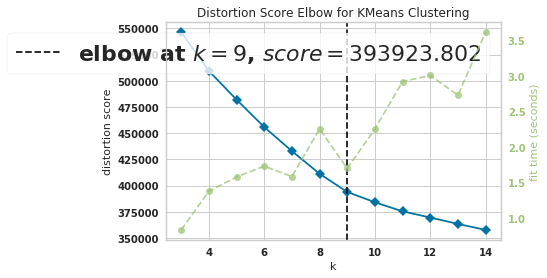

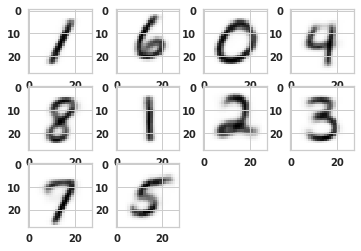

In [73]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [74]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [1,6,0,4,
                                           8,1,2,3,
                                           7,5
                                          ]
manual_annotation_json["manual_confidence"] = [1,1,1,0.9,
                                               1,1,1,1,
                                               0.9,0.85
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    


Getting manual_annotation


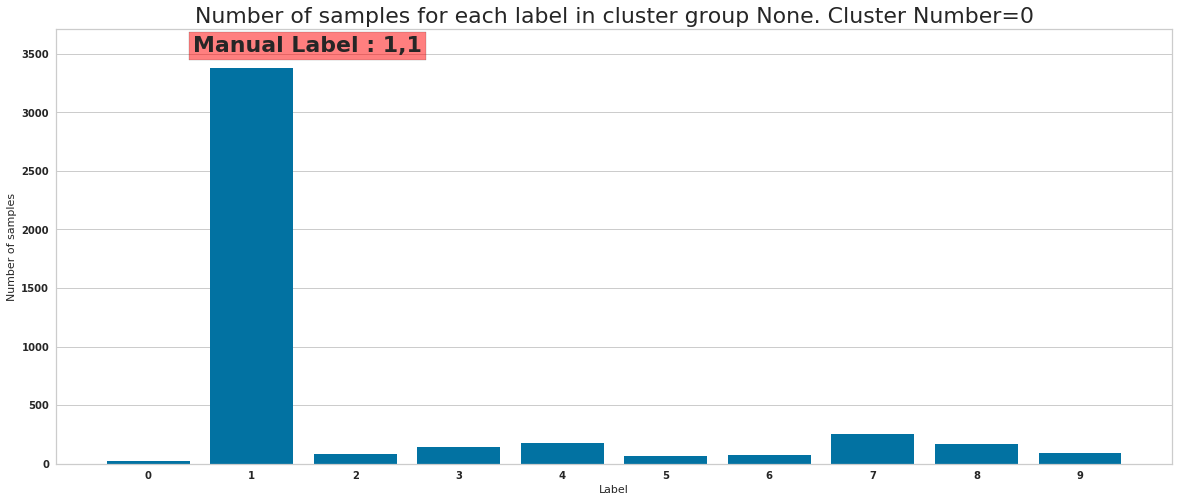

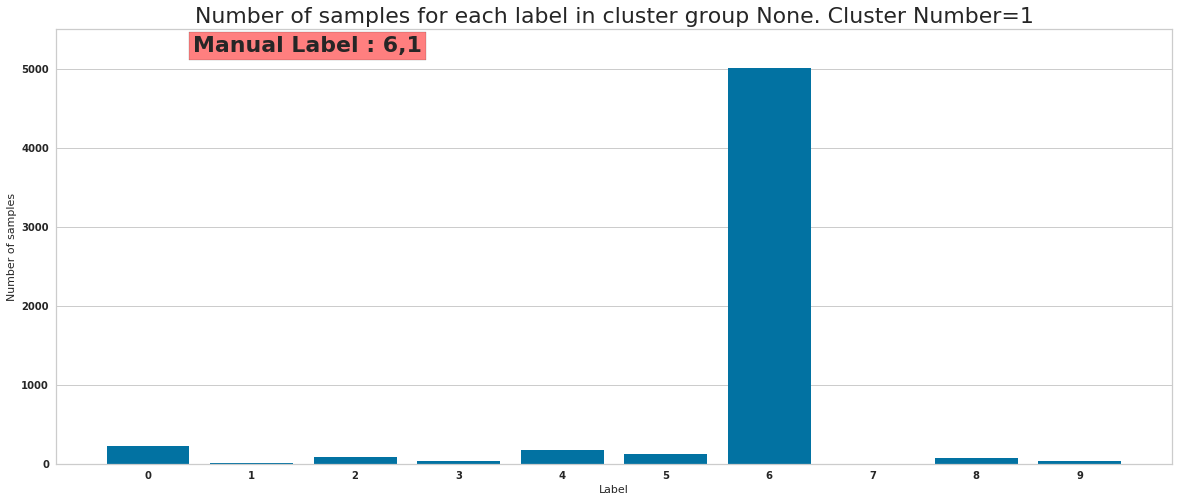

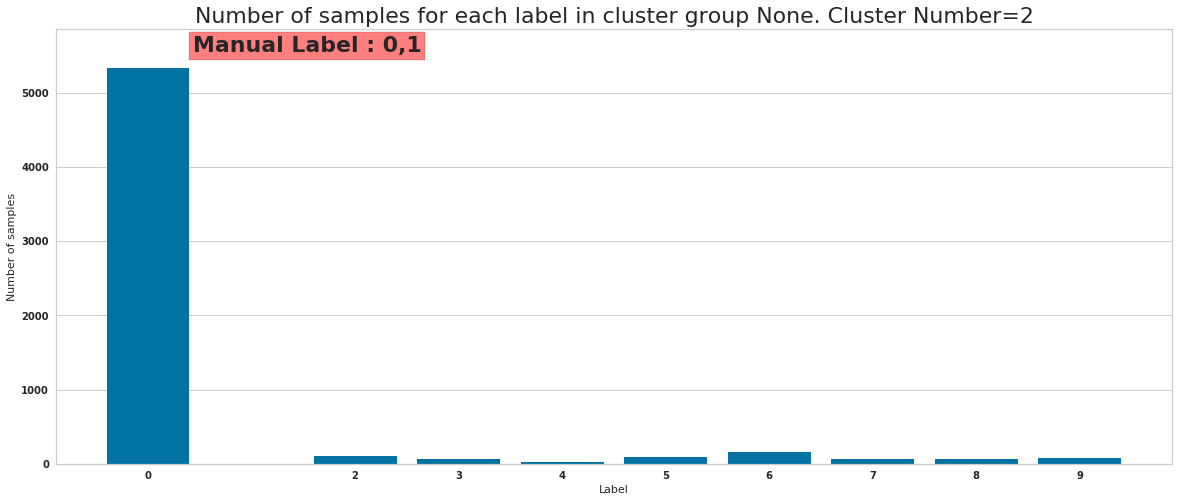

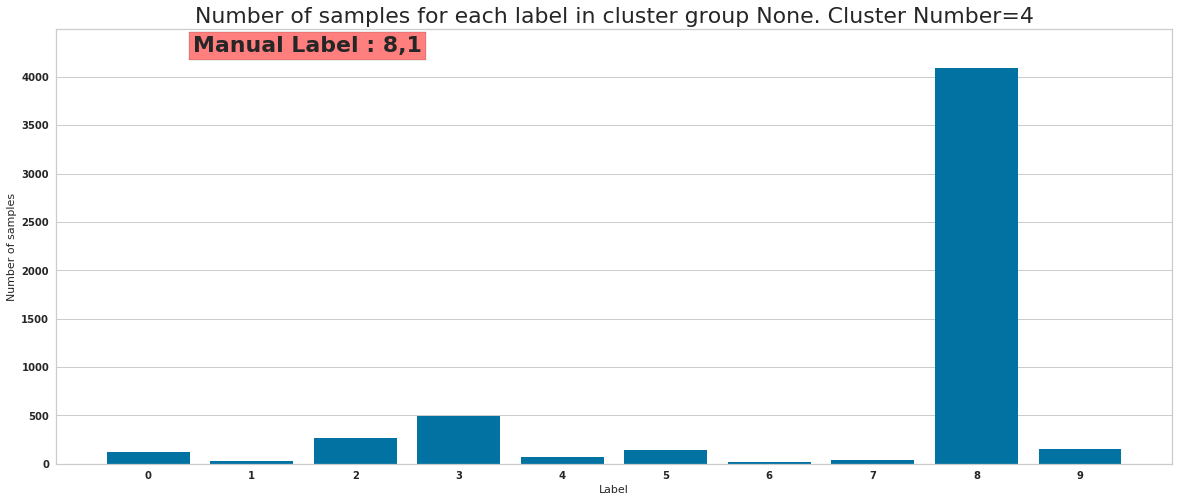

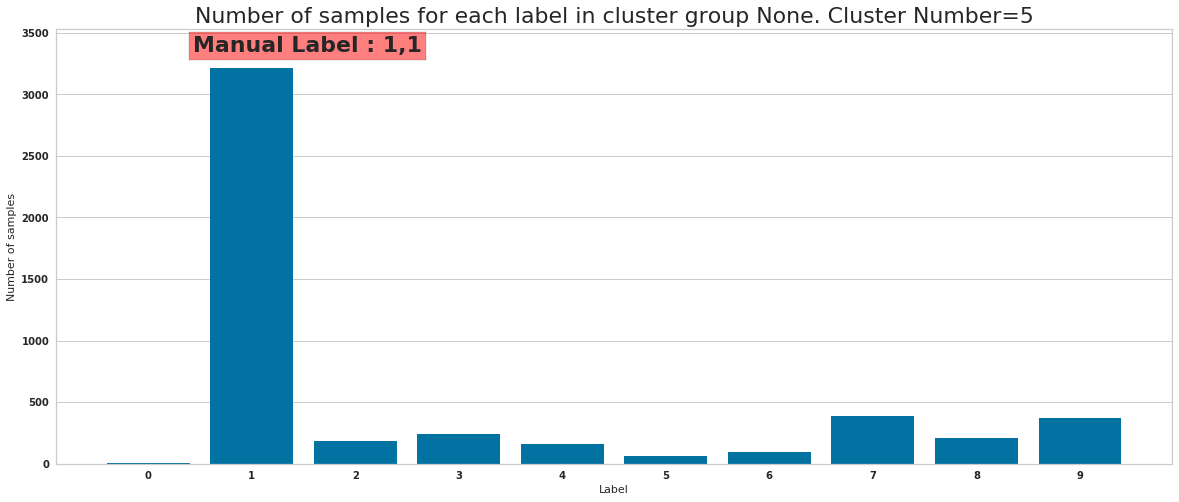

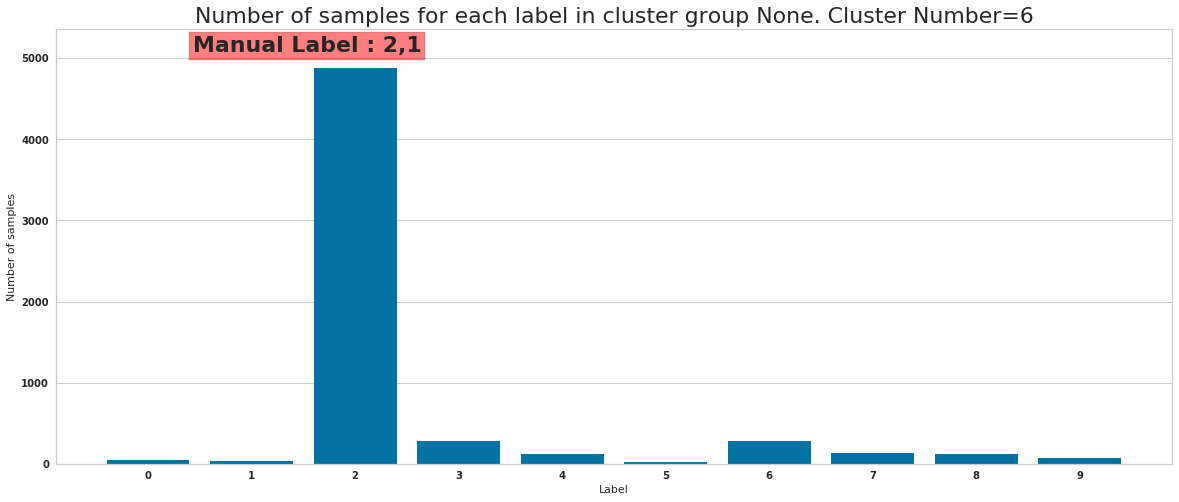

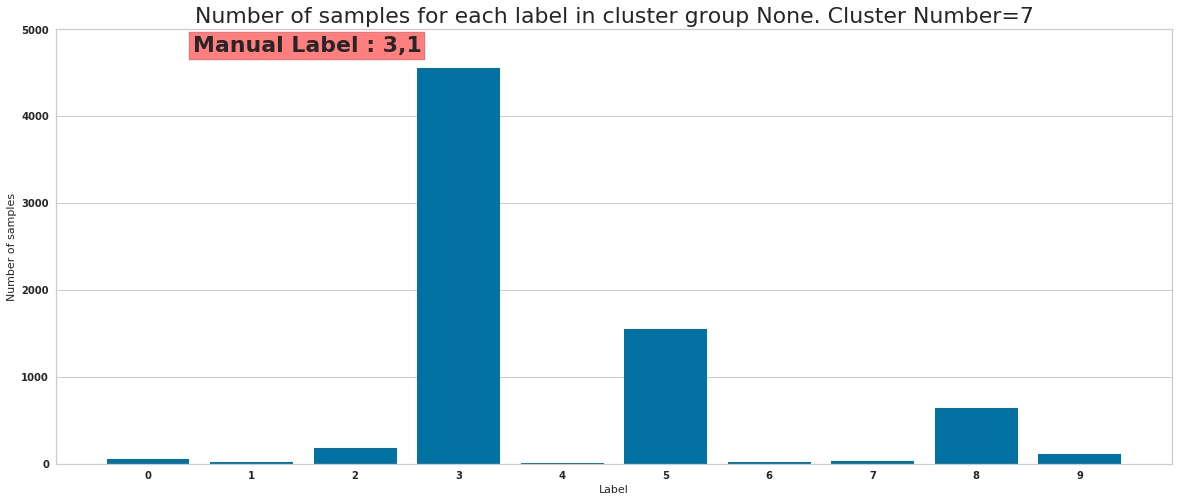

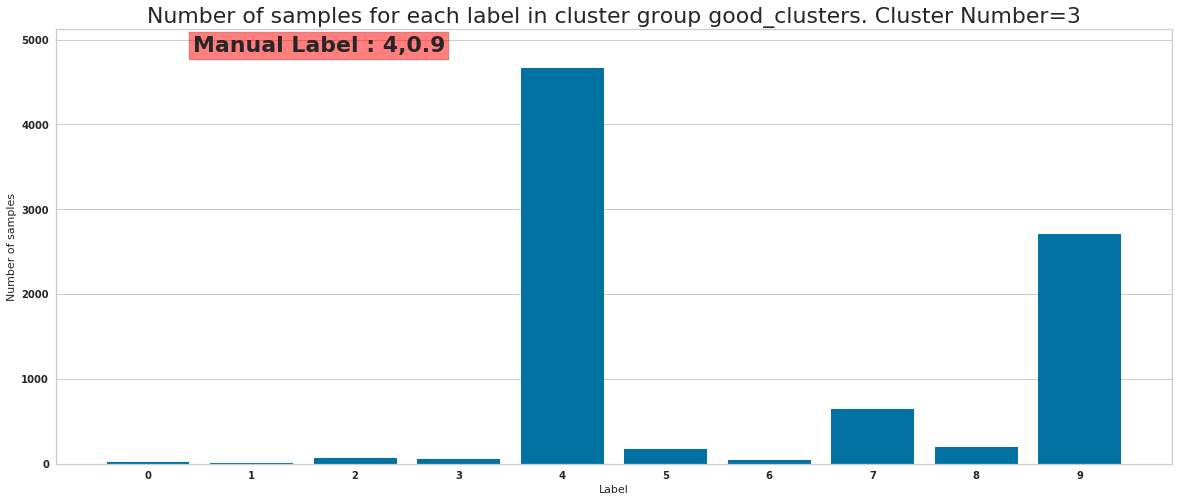

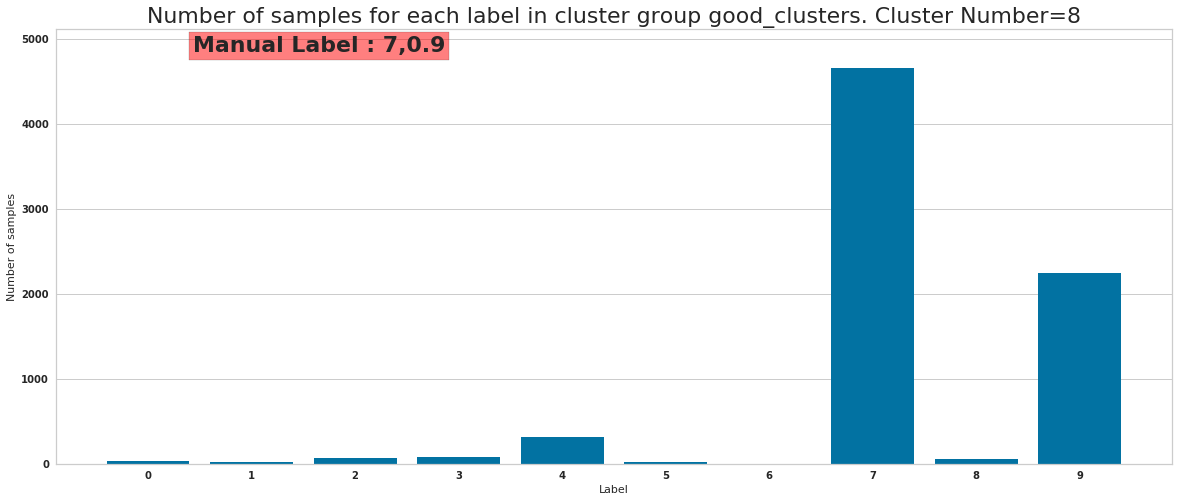

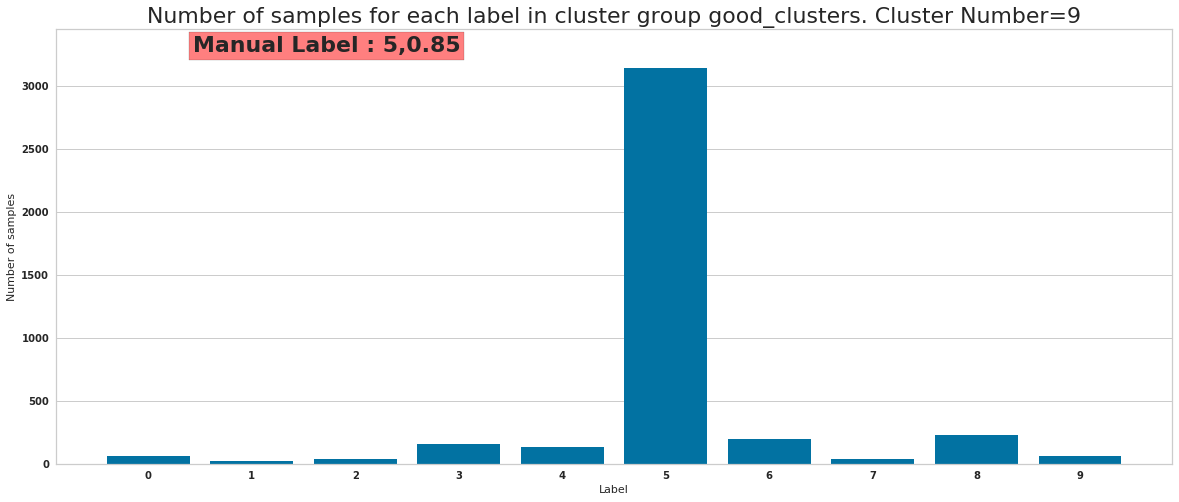

In [75]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [76]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [77]:
# level2_manual_annotations =dict()

# #TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [4,-1,-1,7,
#                                          4,4,9,-1,
#                                          -1,9
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0.7,0,0,0.6,
#                                              0.8,0.8,0.9,0,
#                                              0,0.9]
# level2_manual_annotations[1] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [1,-1,-1,5,
#                                         1,1,8,-1,
#                                         -1,-1
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [1,0,0,0.7,
#                                              1,1,0.8,0,
#                                              0,0]
# level2_manual_annotations[2] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0,0]
# # level2_manual_annotations[9] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0, 0]
# # level2_manual_annotations[13] = level_2_cluster_dict



In [78]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 1
(4455, 47) (4455, 33)
Num correct=3374
Cluster 0 Manual Label 1 Percentage correct 75.7351290684624
********************************
Manual Label 6
(5765, 47) (5765, 33)
Num correct=5004
Cluster 1 Manual Label 6 Percentage correct 86.79965307892455
********************************
Manual Label 0
(5974, 47) (5974, 33)
Num correct=5324
Cluster 2 Manual Label 0 Percentage correct 89.11951791094744
********************************
Manual Label 4
(8579, 47) (8579, 33)
Num correct=4659
Cluster 3 Manual Label 4 Percentage correct 54.30702879123441
********************************
Manual Label 8
(5415, 47) (5415, 33)
Num correct=4086
Cluster 4 Manual Label 8 Percentage correct 75.45706371191136
********************************
Manual Label 1
(9395, 47) (4940, 33)
Num correct=6584
Cluster 5 Manual Label 1 Percentage correct 70.07982969664715
********************************
Manual Label 2
(5975, 47) (5975, 33)
Num correct=4873
Cluster 6 Manual Label 2 Percentage correct 81.556485

In [79]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)

In [80]:
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

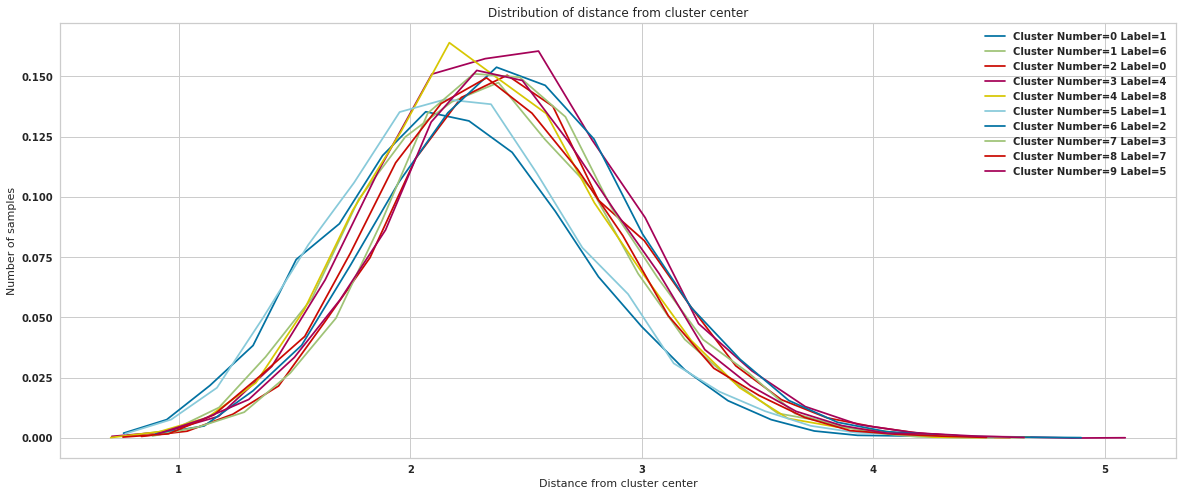

In [81]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

Text(0, 0.5, 'Percentage Correct')

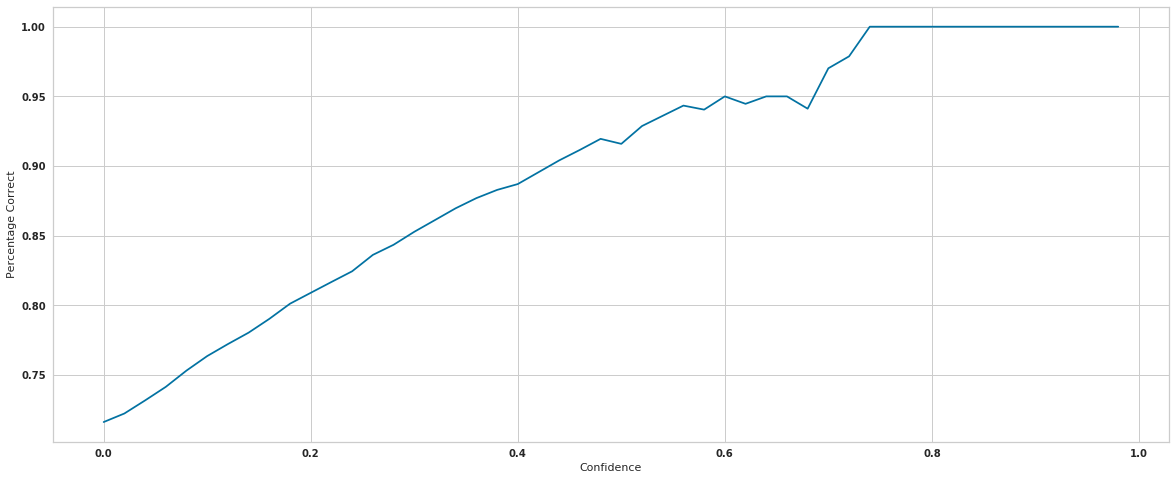

In [82]:
num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

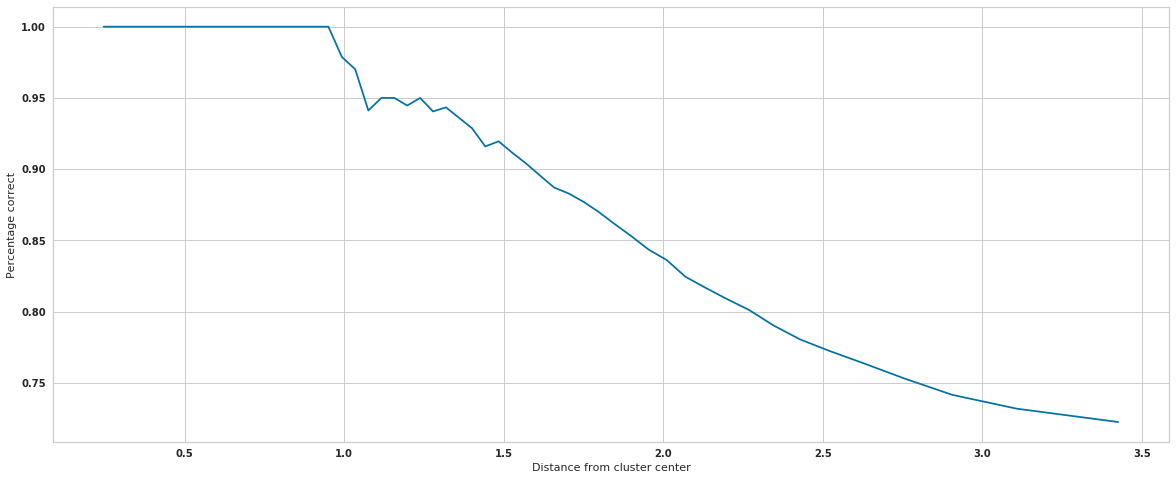

In [83]:
vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

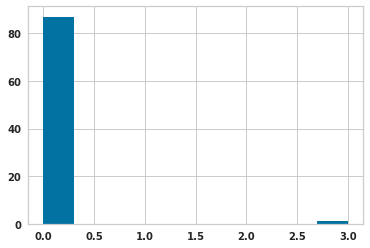

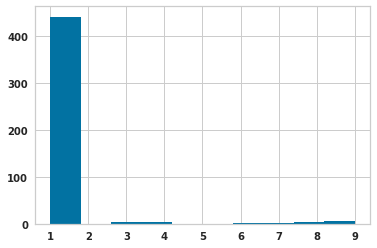

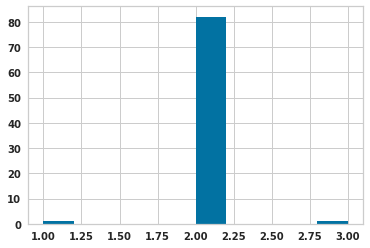

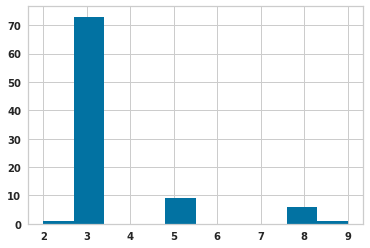

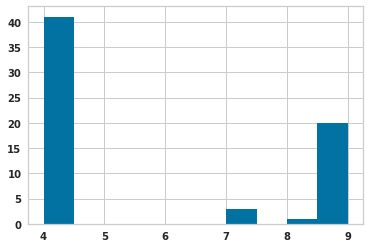

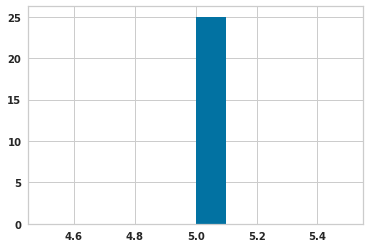

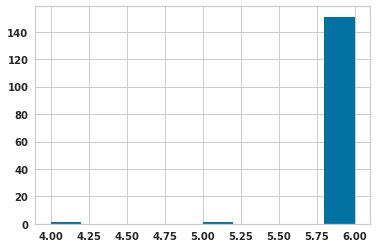

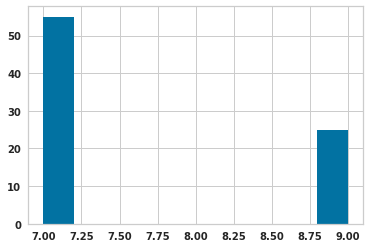

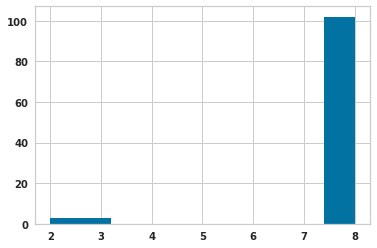

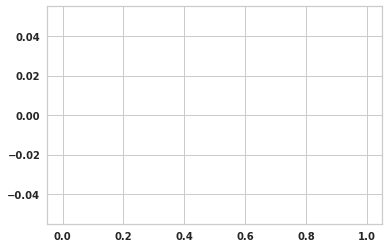

In [84]:
for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# Iteration 4

In [85]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 45, 'ID': 1, 'name': 'semi_supervised_classification_gaussian'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 9585.198523873205
INFO:tensorflow:Summary name Nega

Epoch: 3/65, Nll_loss : 125.23395538330078 KLD:8.297582626342773  Supervised loss:0.05649895966053009
Epoch: 3/66, Nll_loss : 112.86414337158203 KLD:8.083759307861328  Supervised loss:0.062357112765312195
Epoch: 3/67, Nll_loss : 113.57440185546875 KLD:7.975770950317383  Supervised loss:0.05677764117717743
Epoch: 3/68, Nll_loss : 122.98963165283203 KLD:8.578930854797363  Supervised loss:0.05361093208193779
Epoch: 3/69, Nll_loss : 123.58170318603516 KLD:8.702659606933594  Supervised loss:0.05908900499343872
Epoch: 3/70, Nll_loss : 117.29154968261719 KLD:8.859942436218262  Supervised loss:0.05707663297653198
Epoch: 3/71, Nll_loss : 117.02220153808594 KLD:8.659666061401367  Supervised loss:0.07743154466152191
Epoch: 3/72, Nll_loss : 121.20172882080078 KLD:8.584278106689453  Supervised loss:0.060940295457839966
Epoch: 3/73, Nll_loss : 116.95682525634766 KLD:8.316513061523438  Supervised loss:0.06129898503422737
Epoch: 3/74, Nll_loss : 126.248291015625 KLD:8.184392929077148  Supervised loss:

Epoch: 3/146, Nll_loss : 115.88813781738281 KLD:8.636720657348633  Supervised loss:0.05432383716106415
Epoch: 3/147, Nll_loss : 120.84117126464844 KLD:8.659358978271484  Supervised loss:0.06495483964681625
Epoch: 3/148, Nll_loss : 128.74609375 KLD:8.594139099121094  Supervised loss:0.0689404159784317
Epoch: 3/149, Nll_loss : 113.91353607177734 KLD:8.38535213470459  Supervised loss:0.07747422158718109
Epoch: 3/150, Nll_loss : 125.32943725585938 KLD:8.487226486206055  Supervised loss:0.051507629454135895
Epoch: 3/151, Nll_loss : 121.26565551757812 KLD:8.080254554748535  Supervised loss:0.059537552297115326
Epoch: 3/152, Nll_loss : 120.19559478759766 KLD:8.011796951293945  Supervised loss:0.053759440779685974
Epoch: 3/153, Nll_loss : 117.66380310058594 KLD:8.145696640014648  Supervised loss:0.05177922174334526
Epoch: 3/154, Nll_loss : 125.26243591308594 KLD:8.197403907775879  Supervised loss:0.05868271738290787
Epoch: 3/155, Nll_loss : 126.29205322265625 KLD:8.43766975402832  Supervised l

Epoch: 3/226, Nll_loss : 122.59593200683594 KLD:8.357431411743164  Supervised loss:0.071466363966465
Epoch: 3/227, Nll_loss : 119.50505065917969 KLD:7.940659999847412  Supervised loss:0.08291508257389069
Epoch: 3/228, Nll_loss : 121.96034240722656 KLD:7.970019340515137  Supervised loss:0.059352532029151917
Epoch: 3/229, Nll_loss : 121.80557250976562 KLD:7.981788158416748  Supervised loss:0.09186795353889465
Epoch: 3/230, Nll_loss : 124.06452178955078 KLD:7.569159030914307  Supervised loss:0.06287555396556854
Epoch: 3/231, Nll_loss : 127.44356536865234 KLD:7.583795547485352  Supervised loss:0.08095604926347733
Epoch: 3/232, Nll_loss : 120.77506256103516 KLD:7.692904949188232  Supervised loss:0.060331832617521286
Epoch: 3/233, Nll_loss : 121.94744110107422 KLD:7.938006401062012  Supervised loss:0.05685602128505707
Epoch: 3/234, Nll_loss : 127.81539154052734 KLD:7.590673446655273  Supervised loss:0.08066338300704956
Epoch: 3/235, Nll_loss : 120.65861511230469 KLD:8.294625282287598  Superv

Epoch: 3/307, Nll_loss : 116.97245788574219 KLD:8.151581764221191  Supervised loss:0.035106368362903595
Epoch: 3/308, Nll_loss : 132.97064208984375 KLD:8.200565338134766  Supervised loss:0.09993129223585129
Epoch: 3/309, Nll_loss : 116.14950561523438 KLD:8.028564453125  Supervised loss:0.08537052571773529
Epoch: 3/310, Nll_loss : 127.6959228515625 KLD:8.327875137329102  Supervised loss:0.0721261128783226
Epoch: 3/311, Nll_loss : 126.0870361328125 KLD:8.14659309387207  Supervised loss:0.08786597847938538
Epoch: 3/312, Nll_loss : 125.1833724975586 KLD:8.419241905212402  Supervised loss:0.06209421157836914
Epoch: 3/313, Nll_loss : 124.73133850097656 KLD:8.1818265914917  Supervised loss:0.0497342124581337
Epoch: 3/314, Nll_loss : 116.43973541259766 KLD:8.103031158447266  Supervised loss:0.09281391650438309
Epoch: 3/315, Nll_loss : 116.4246597290039 KLD:8.044397354125977  Supervised loss:0.04973477125167847
Epoch: 3/316, Nll_loss : 118.72689056396484 KLD:8.015741348266602  Supervised loss:0

Epoch: 3/388, Nll_loss : 123.13729858398438 KLD:8.261003494262695  Supervised loss:0.07475975155830383
Epoch: 3/389, Nll_loss : 119.42181396484375 KLD:8.378166198730469  Supervised loss:0.09407586604356766
Epoch: 3/390, Nll_loss : 123.94682312011719 KLD:8.616878509521484  Supervised loss:0.10138796269893646
Epoch: 3/391, Nll_loss : 114.66156005859375 KLD:8.479477882385254  Supervised loss:0.07466378808021545
Epoch: 3/392, Nll_loss : 117.00442504882812 KLD:8.414196014404297  Supervised loss:0.04441213980317116
Epoch: 3/393, Nll_loss : 126.05635070800781 KLD:8.681722640991211  Supervised loss:0.04977007955312729
Epoch: 3/394, Nll_loss : 117.89075469970703 KLD:8.557544708251953  Supervised loss:0.0774369090795517
Epoch: 3/395, Nll_loss : 121.47440338134766 KLD:8.343019485473633  Supervised loss:0.07395806908607483
Epoch: 3/396, Nll_loss : 115.44775390625 KLD:8.685468673706055  Supervised loss:0.06250591576099396
Epoch: 3/397, Nll_loss : 114.22818756103516 KLD:8.076200485229492  Supervised

Epoch: 3/470, Nll_loss : 120.54499816894531 KLD:8.248382568359375  Supervised loss:0.05939510837197304
Epoch: 3/471, Nll_loss : 119.54554748535156 KLD:8.165117263793945  Supervised loss:0.05876784771680832
Epoch: 3/472, Nll_loss : 122.71498107910156 KLD:8.361959457397461  Supervised loss:0.061654482036828995
Epoch: 3/473, Nll_loss : 116.1920394897461 KLD:8.682008743286133  Supervised loss:0.049358103424310684
Epoch: 3/474, Nll_loss : 118.81147766113281 KLD:8.617256164550781  Supervised loss:0.06663425266742706
Epoch: 3/475, Nll_loss : 119.72323608398438 KLD:8.818286895751953  Supervised loss:0.06384626775979996
Epoch: 3/476, Nll_loss : 114.49308013916016 KLD:9.0867919921875  Supervised loss:0.054118044674396515
Epoch: 3/477, Nll_loss : 120.3333740234375 KLD:8.749228477478027  Supervised loss:0.07021468877792358
Epoch: 3/478, Nll_loss : 117.108642578125 KLD:8.466825485229492  Supervised loss:0.09309221804141998
Epoch: 3/479, Nll_loss : 124.84574890136719 KLD:8.292909622192383  Supervise

Epoch: 3/551, Nll_loss : 123.20960235595703 KLD:7.763025283813477  Supervised loss:0.05801047384738922
Epoch: 3/552, Nll_loss : 115.91270446777344 KLD:7.4295196533203125  Supervised loss:0.07062025368213654
Epoch: 3/553, Nll_loss : 123.26107788085938 KLD:7.935678005218506  Supervised loss:0.05560675263404846
Epoch: 3/554, Nll_loss : 127.15486907958984 KLD:7.893383502960205  Supervised loss:0.07029344141483307
Epoch: 3/555, Nll_loss : 120.42181396484375 KLD:8.355369567871094  Supervised loss:0.07182419300079346
Epoch: 3/556, Nll_loss : 125.22637939453125 KLD:8.45734977722168  Supervised loss:0.05003347992897034
Epoch: 3/557, Nll_loss : 117.96723937988281 KLD:8.600017547607422  Supervised loss:0.05852581560611725
Epoch: 3/558, Nll_loss : 118.2390365600586 KLD:8.253342628479004  Supervised loss:0.05409351736307144
Epoch: 3/559, Nll_loss : 116.17015075683594 KLD:8.679431915283203  Supervised loss:0.05078461021184921
Epoch: 3/560, Nll_loss : 112.3975601196289 KLD:8.507944107055664  Supervis

Epoch: 3/631, Nll_loss : 115.53521728515625 KLD:7.771770477294922  Supervised loss:0.07077544182538986
Epoch: 3/632, Nll_loss : 113.1518783569336 KLD:7.87615966796875  Supervised loss:0.0726793110370636
Epoch: 3/633, Nll_loss : 115.11996459960938 KLD:8.128400802612305  Supervised loss:0.06647614389657974
Epoch: 3/634, Nll_loss : 119.80781555175781 KLD:8.249275207519531  Supervised loss:0.06929229944944382
Epoch: 3/635, Nll_loss : 116.34146118164062 KLD:8.818514823913574  Supervised loss:0.07095928490161896
Epoch: 3/636, Nll_loss : 113.78977966308594 KLD:8.809409141540527  Supervised loss:0.05145804584026337
Epoch: 3/637, Nll_loss : 110.75151062011719 KLD:8.383634567260742  Supervised loss:0.06280940771102905
Epoch: 3/638, Nll_loss : 119.27488708496094 KLD:8.222785949707031  Supervised loss:0.08142589777708054
Epoch: 3/639, Nll_loss : 125.66963195800781 KLD:8.287561416625977  Supervised loss:0.09865254163742065
Epoch: 3/640, Nll_loss : 117.31514739990234 KLD:7.939016819000244  Supervise

Epoch: 3/712, Nll_loss : 120.34934997558594 KLD:8.484455108642578  Supervised loss:0.05177179351449013
Epoch: 3/713, Nll_loss : 119.31585693359375 KLD:8.209765434265137  Supervised loss:0.06053374707698822
Epoch: 3/714, Nll_loss : 113.72660827636719 KLD:8.459217071533203  Supervised loss:0.04894137755036354
Epoch: 3/715, Nll_loss : 117.35820007324219 KLD:7.993329048156738  Supervised loss:0.08057566732168198
Epoch: 3/716, Nll_loss : 118.07415008544922 KLD:8.069426536560059  Supervised loss:0.06881198287010193
Epoch: 3/717, Nll_loss : 122.33161163330078 KLD:8.255912780761719  Supervised loss:0.05238548666238785
Epoch: 3/718, Nll_loss : 113.93745422363281 KLD:7.760485649108887  Supervised loss:0.07818780839443207
Epoch: 3/719, Nll_loss : 127.12651062011719 KLD:7.704988956451416  Supervised loss:0.08530288934707642
Epoch: 3/720, Nll_loss : 120.03746032714844 KLD:8.06192398071289  Supervised loss:0.0841081291437149
Epoch: 3/721, Nll_loss : 120.55664825439453 KLD:8.254766464233398  Supervis

Epoch: 3/793, Nll_loss : 112.90985107421875 KLD:8.296575546264648  Supervised loss:0.0733254998922348
Epoch: 3/794, Nll_loss : 118.89681243896484 KLD:8.879671096801758  Supervised loss:0.05046574026346207
Epoch: 3/795, Nll_loss : 116.23464965820312 KLD:8.477396965026855  Supervised loss:0.06079515814781189
Epoch: 3/796, Nll_loss : 128.148193359375 KLD:8.459081649780273  Supervised loss:0.04878828674554825
Epoch: 3/797, Nll_loss : 119.20359802246094 KLD:8.218221664428711  Supervised loss:0.06990498304367065
Epoch: 3/798, Nll_loss : 123.0224609375 KLD:7.581442832946777  Supervised loss:0.11414852738380432
Epoch: 3/799, Nll_loss : 127.52369689941406 KLD:8.132803916931152  Supervised loss:0.06495898962020874
Epoch: 3/800, Nll_loss : 125.94302368164062 KLD:8.004491806030273  Supervised loss:0.06285609304904938
Epoch: 3/801, Nll_loss : 116.53645324707031 KLD:7.822324752807617  Supervised loss:0.0806390717625618
Epoch: 3/802, Nll_loss : 114.10063171386719 KLD:8.392834663391113  Supervised los

Epoch: 3/873, Nll_loss : 120.79007720947266 KLD:7.8550190925598145  Supervised loss:0.08097393810749054
Epoch: 3/874, Nll_loss : 121.30936431884766 KLD:7.954465866088867  Supervised loss:0.09365290403366089
Epoch: 3/875, Nll_loss : 122.14417266845703 KLD:8.158308029174805  Supervised loss:0.05240268260240555
Epoch: 3/876, Nll_loss : 115.65541076660156 KLD:8.139643669128418  Supervised loss:0.041593246161937714
Epoch: 3/877, Nll_loss : 119.49345397949219 KLD:8.577924728393555  Supervised loss:0.06558354198932648
Epoch: 3/878, Nll_loss : 125.91981506347656 KLD:8.520987510681152  Supervised loss:0.05385930836200714
Epoch: 3/879, Nll_loss : 112.03755187988281 KLD:8.63893985748291  Supervised loss:0.041698239743709564
Epoch: 3/880, Nll_loss : 110.8174819946289 KLD:8.284080505371094  Supervised loss:0.060773491859436035
Epoch: 3/881, Nll_loss : 119.80457305908203 KLD:8.480972290039062  Supervised loss:0.06554713845252991
Epoch: 3/882, Nll_loss : 119.97140502929688 KLD:8.366656303405762  Supe

In [86]:
num_cluster=10
num_clusters=10

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-3740
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification_gaussian/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-3740
 [*] Success to read SemiSupervisedClassifierMnist.model-3740
 [*] Load SUCCESS
Number of steps completed=3740
Number of epochs completed 4.0
run_id=45 z_min=-4.327808999999999 z_max=4.5933459999999995
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary nam

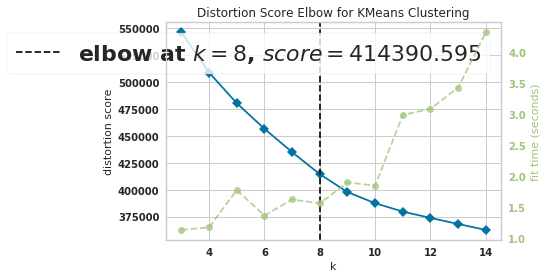

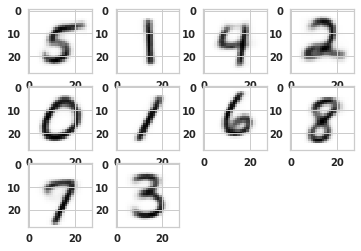

In [87]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [88]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [5,1,4,2,
                                           0,1,6,8,
                                           7, 3
                                          ]
manual_annotation_json["manual_confidence"] = [1,1,0.8,1,
                                               1,1,1,1,
                                               0.9,0.9
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    

    

Getting manual_annotation


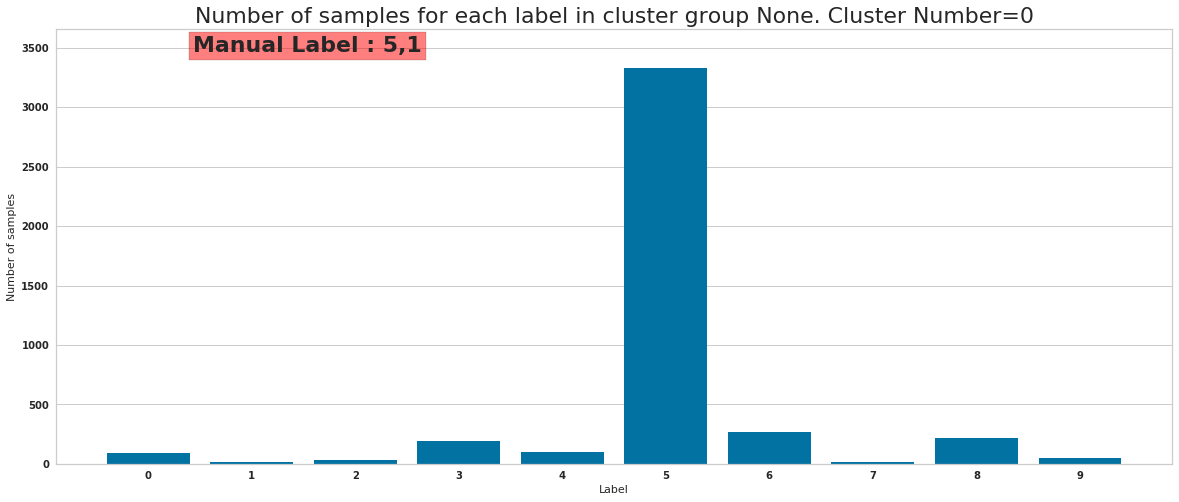

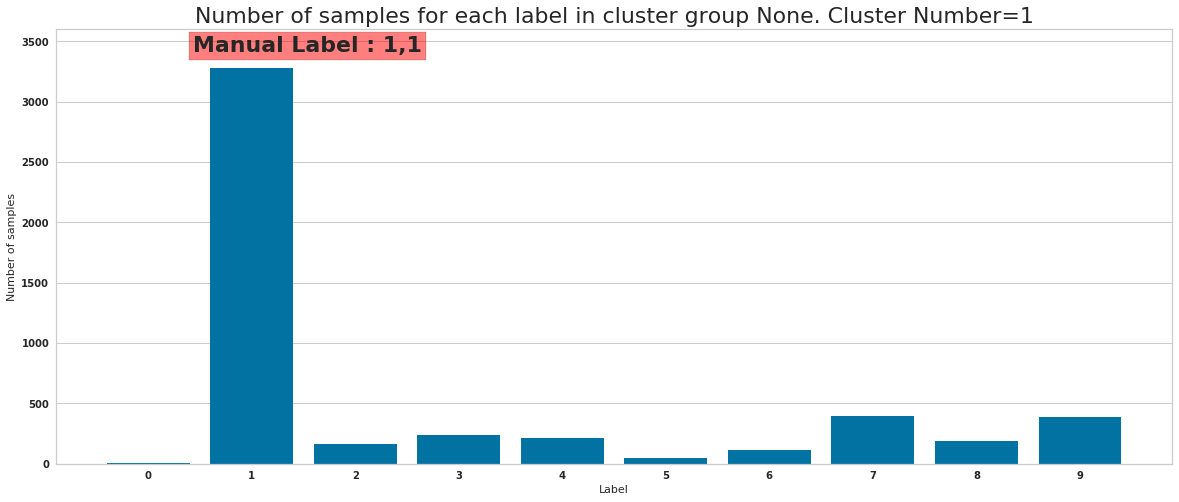

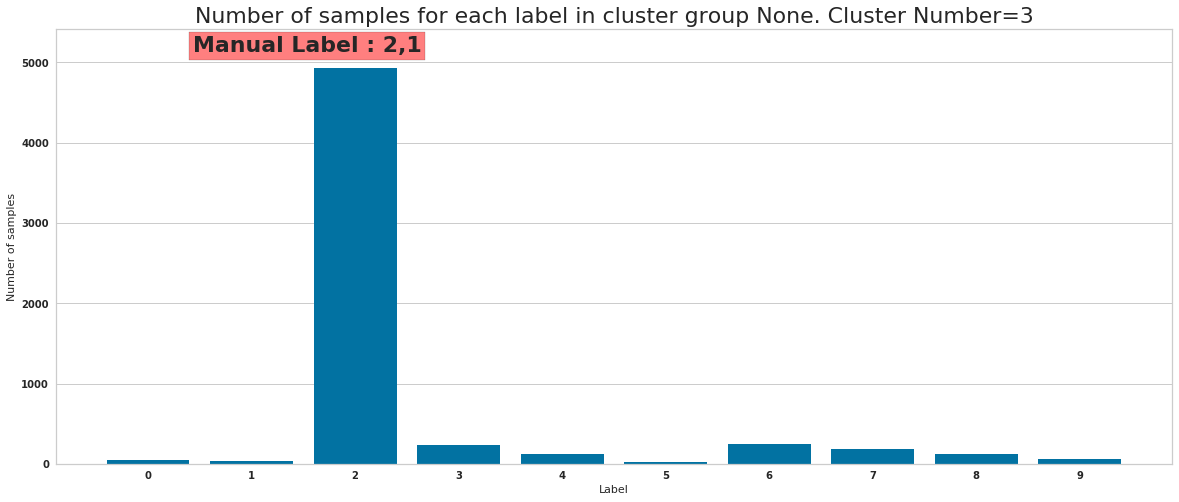

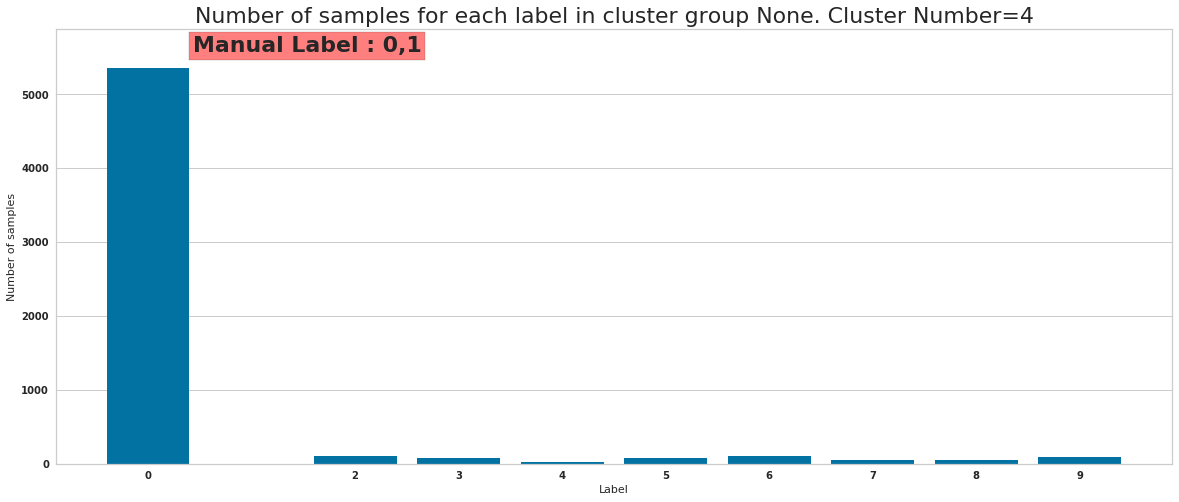

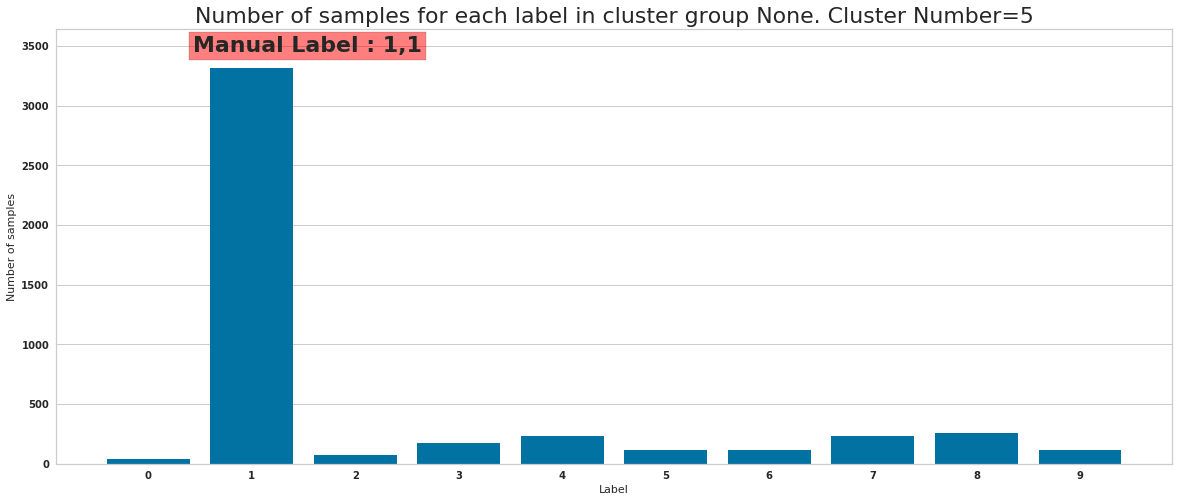

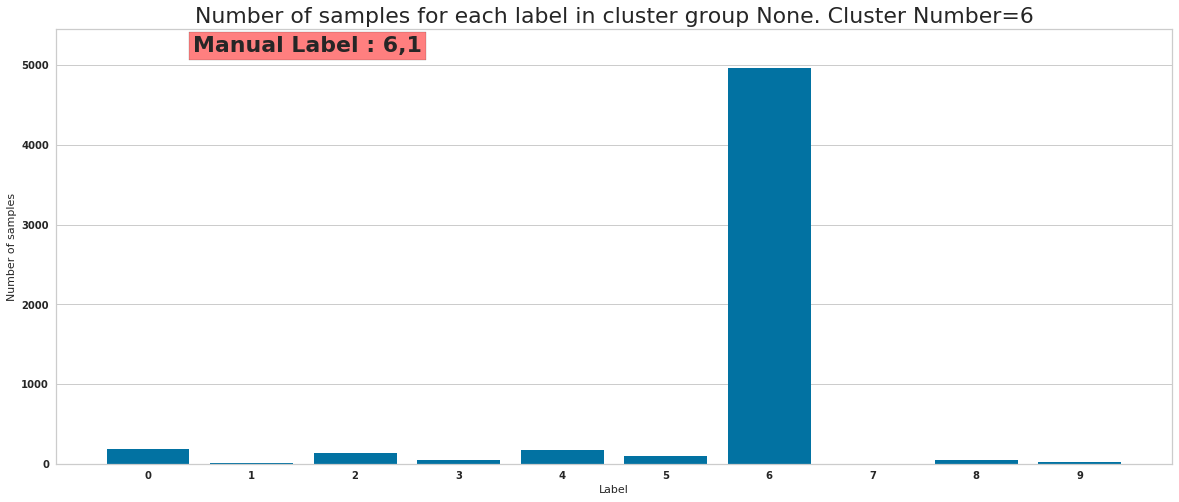

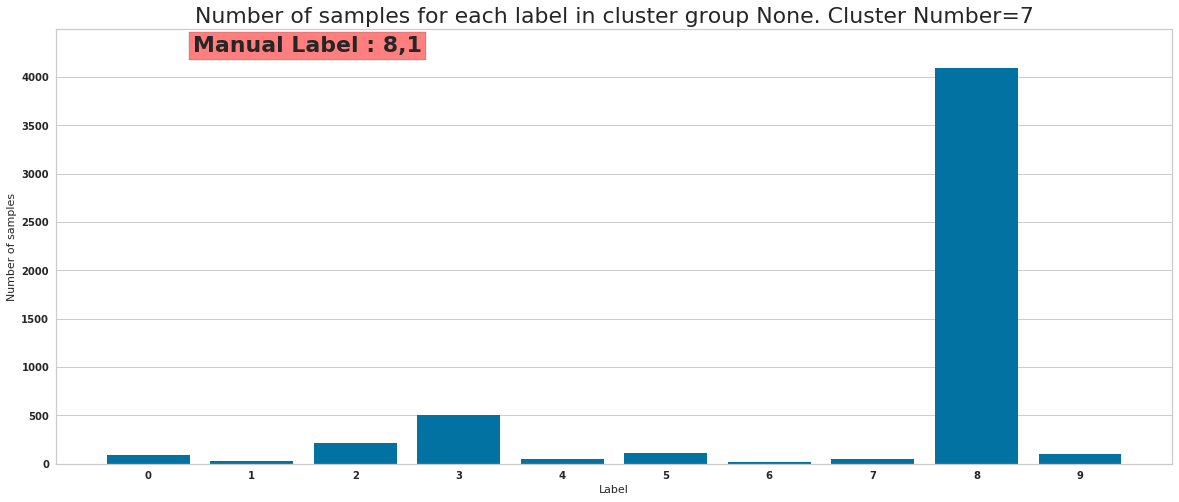

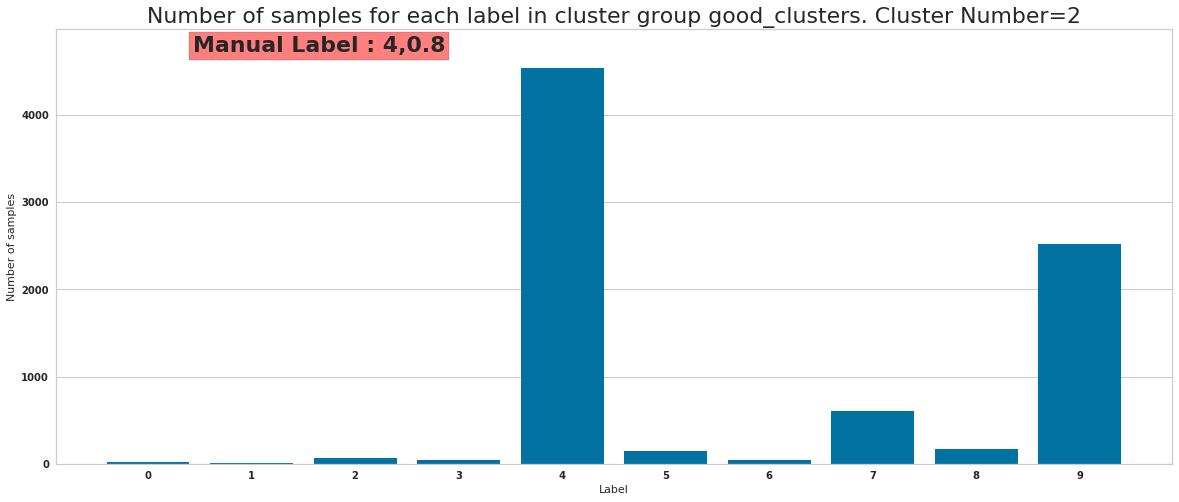

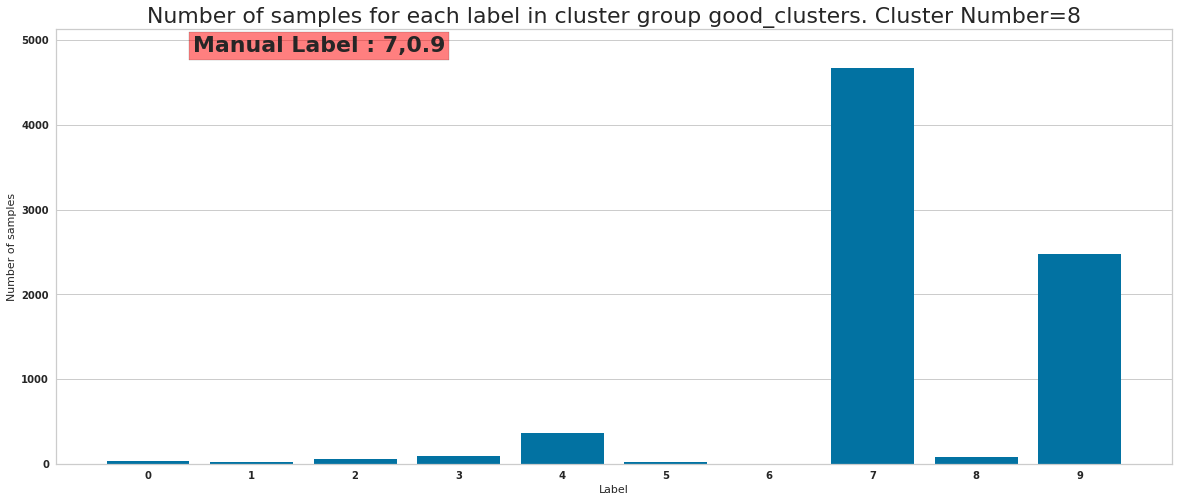

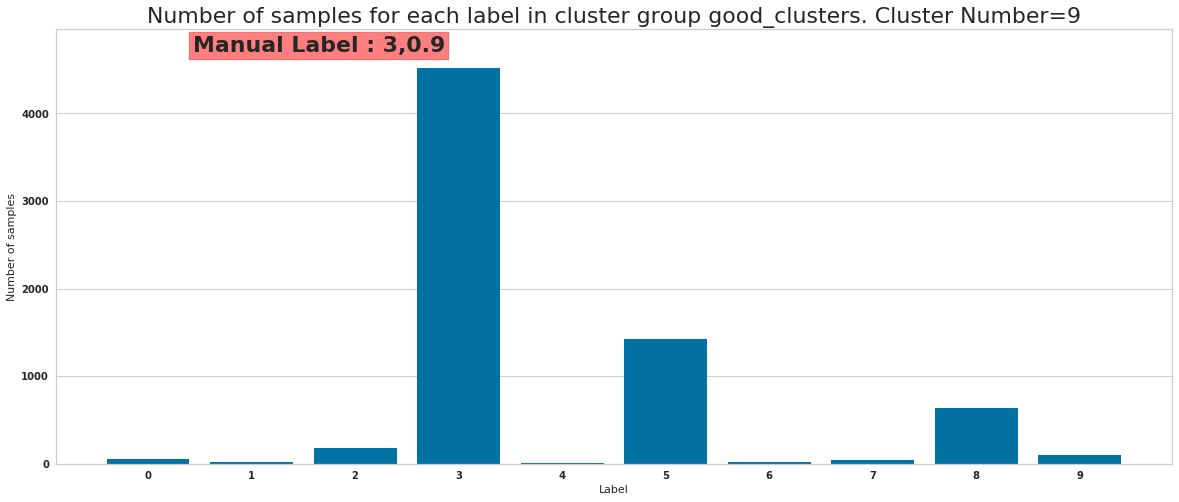

In [89]:
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )

In [90]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [91]:
# level2_manual_annotations =dict()

# #TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [5,0,-1,5,
#                                          5,8,1,5,
#                                          -1,-1
#                                         ]
# level_2_cluster_dict["manual_confidences"] = [0.7,0.7,0,0.7,
#                                              0.8,0.8,0.9,0.7,
#                                              0,0]
# level2_manual_annotations[0] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [3,-1,3,3,
# #                                         3,3,3,3,
# #                                         -1,3]
# # level_2_cluster_dict["manual_confidences"] = [0.9,0,0.9,0.9,
# #                                              0.9,0.9,0.9,0.9,
# #                                              0,0.9]
# # level2_manual_annotations[7] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0,0]
# # level2_manual_annotations[9] = level_2_cluster_dict

# # level_2_cluster_dict = dict()
# # level_2_cluster_dict["manual_labels"] = [-1, -1]
# # level_2_cluster_dict["manual_confidences"] = [0, 0]
# # level2_manual_annotations[13] = level_2_cluster_dict



In [92]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 5
(4297, 47) (4297, 33)
Num correct=3326
Cluster 0 Manual Label 5 Percentage correct 77.40283919013265
********************************
Manual Label 1
(5031, 47) (5031, 33)
Num correct=3275
Cluster 1 Manual Label 1 Percentage correct 65.09640230570463
********************************
Manual Label 4
(8156, 47) (8156, 33)
Num correct=4533
Cluster 2 Manual Label 4 Percentage correct 55.5787150564002
********************************
Manual Label 2
(6001, 47) (6001, 33)
Num correct=4924
Cluster 3 Manual Label 2 Percentage correct 82.05299116813865
********************************
Manual Label 0
(5934, 47) (5934, 33)
Num correct=5350
Cluster 4 Manual Label 0 Percentage correct 90.15840916750926
********************************
Manual Label 1
(9700, 47) (4669, 33)
Num correct=6588
Cluster 5 Manual Label 1 Percentage correct 67.91752577319588
********************************
Manual Label 6
(5686, 47) (5686, 33)
Num correct=4958
Cluster 6 Manual Label 6 Percentage correct 87.196623

In [93]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

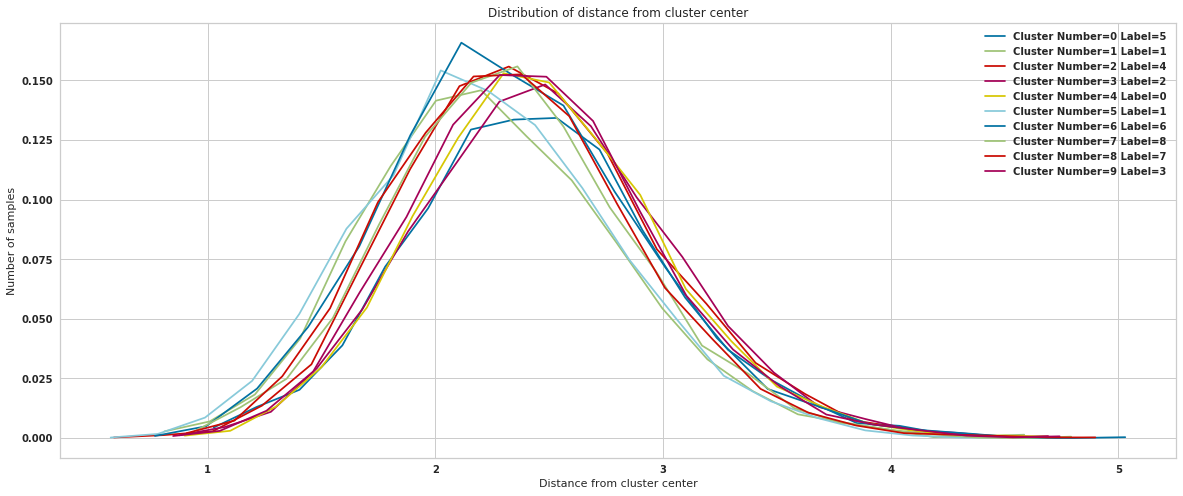

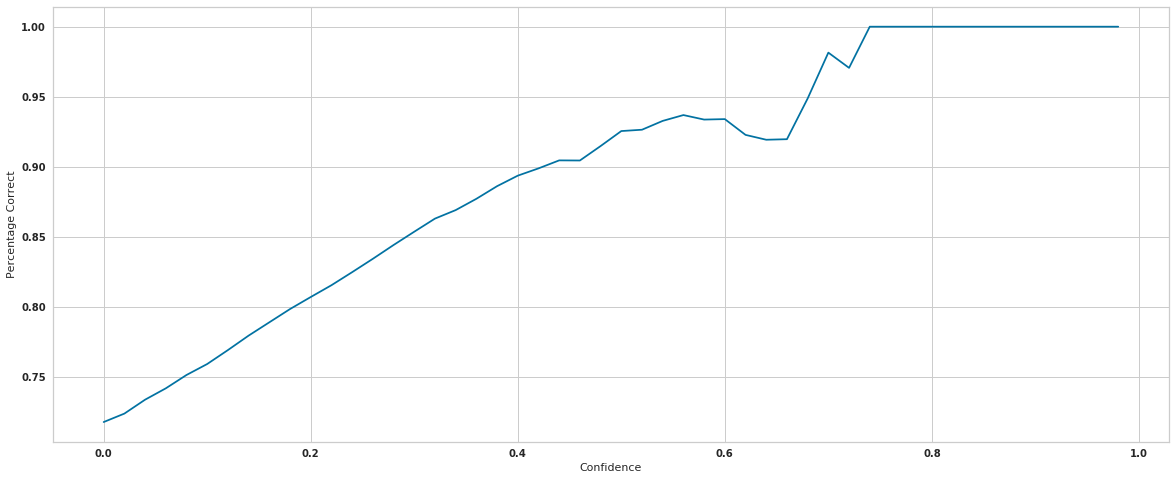

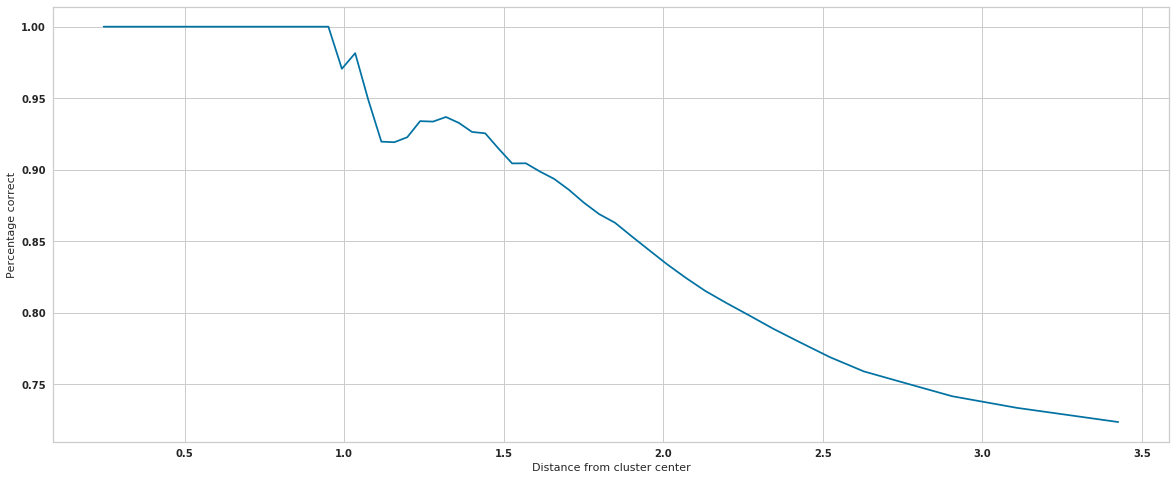

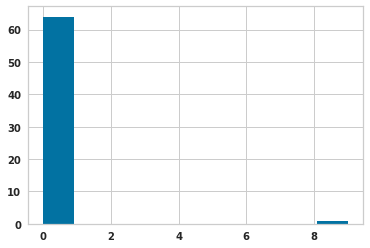

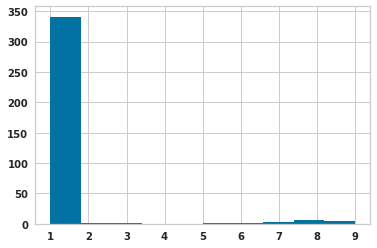

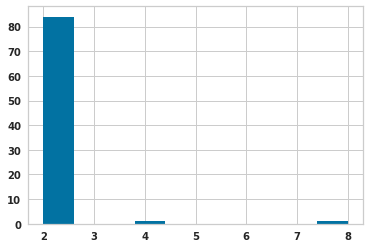

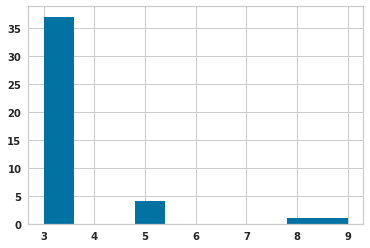

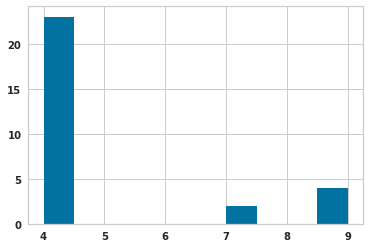

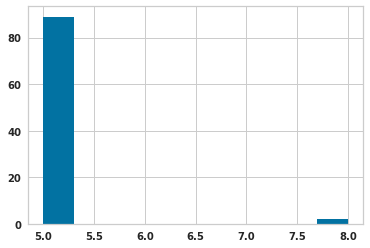

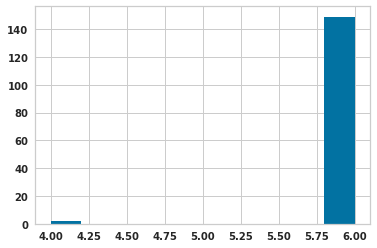

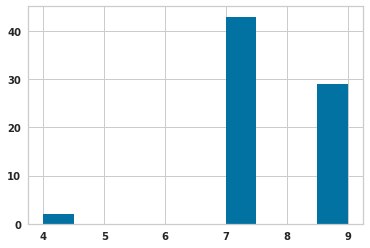

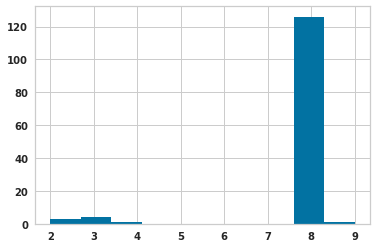

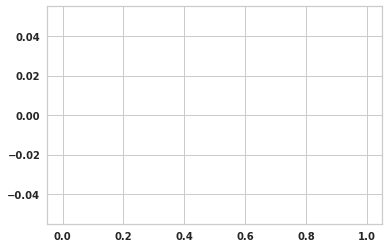

In [94]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

# iteration 5

In [95]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'SAVE_RECONSTRUCTED_IMAGES': True, 'NUM_VAL_SAMPLES': 128, 'LEARNING_RATE': 0.001, 'MAX_CHECKPOINTS_TO_KEEP': 20, 'BETA1_ADAM': 0.9, 'RUN_EVALUATION_DURING_TRAINING': True, 'MODEL_SAVE_INTERVAL': 1, 'WRITE_PREDICTIONS': True, 'EVAL_INTERVAL_IN_EPOCHS': 1, 'RETURN_LATENT_VECTOR': True, 'SEED': 547, 'BUDGET': 1, 'RUN_ID': 45, 'ID': 1, 'name': 'semi_supervised_classification_gaussian'}
Loaded manual annotation
Number of samples with manual confidence 59840
Number of samples with manual annotation 9353.856063340452
INFO:tensorflow:Summary name Nega

Epoch: 4/65, Nll_loss : 125.08287048339844 KLD:8.392435073852539  Supervised loss:0.057331860065460205
Epoch: 4/66, Nll_loss : 108.69598388671875 KLD:7.994423866271973  Supervised loss:0.07353049516677856
Epoch: 4/67, Nll_loss : 113.26780700683594 KLD:7.727227687835693  Supervised loss:0.04120562970638275
Epoch: 4/68, Nll_loss : 121.52201843261719 KLD:8.263229370117188  Supervised loss:0.04633272811770439
Epoch: 4/69, Nll_loss : 125.45183563232422 KLD:8.420939445495605  Supervised loss:0.07305832207202911
Epoch: 4/70, Nll_loss : 113.89483642578125 KLD:8.594724655151367  Supervised loss:0.06274440884590149
Epoch: 4/71, Nll_loss : 115.93927764892578 KLD:8.472265243530273  Supervised loss:0.08407804369926453
Epoch: 4/72, Nll_loss : 118.68330383300781 KLD:8.575413703918457  Supervised loss:0.06806495785713196
Epoch: 4/73, Nll_loss : 118.253662109375 KLD:8.546966552734375  Supervised loss:0.054022520780563354
Epoch: 4/74, Nll_loss : 123.79208374023438 KLD:8.660443305969238  Supervised loss:

Epoch: 4/148, Nll_loss : 126.64988708496094 KLD:8.510254859924316  Supervised loss:0.08178578317165375
Epoch: 4/149, Nll_loss : 114.86000061035156 KLD:8.298309326171875  Supervised loss:0.053956951946020126
Epoch: 4/150, Nll_loss : 121.99240112304688 KLD:8.599763870239258  Supervised loss:0.05946309491991997
Epoch: 4/151, Nll_loss : 117.05581665039062 KLD:8.238337516784668  Supervised loss:0.0623917356133461
Epoch: 4/152, Nll_loss : 118.660400390625 KLD:8.143327713012695  Supervised loss:0.08077839016914368
Epoch: 4/153, Nll_loss : 113.35804748535156 KLD:8.323022842407227  Supervised loss:0.05598925054073334
Epoch: 4/154, Nll_loss : 121.70460510253906 KLD:8.371826171875  Supervised loss:0.06925996392965317
Epoch: 4/155, Nll_loss : 122.57417297363281 KLD:8.661022186279297  Supervised loss:0.07497482746839523
Epoch: 4/156, Nll_loss : 120.22239685058594 KLD:8.425378799438477  Supervised loss:0.06872646510601044
Epoch: 4/157, Nll_loss : 117.07964324951172 KLD:8.955446243286133  Supervised 

Epoch: 4/229, Nll_loss : 115.02198791503906 KLD:8.95412540435791  Supervised loss:0.041024889796972275
Epoch: 4/230, Nll_loss : 119.19700622558594 KLD:8.36928653717041  Supervised loss:0.054607562720775604
Epoch: 4/231, Nll_loss : 124.08570861816406 KLD:8.316164016723633  Supervised loss:0.07928614318370819
Epoch: 4/232, Nll_loss : 116.31658172607422 KLD:8.118892669677734  Supervised loss:0.05074252188205719
Epoch: 4/233, Nll_loss : 115.44009399414062 KLD:8.294851303100586  Supervised loss:0.055627934634685516
Epoch: 4/234, Nll_loss : 123.56588745117188 KLD:7.8642730712890625  Supervised loss:0.08243124186992645
Epoch: 4/235, Nll_loss : 120.61264038085938 KLD:8.214509963989258  Supervised loss:0.09024931490421295
Epoch: 4/236, Nll_loss : 116.28606414794922 KLD:8.63081169128418  Supervised loss:0.08215093612670898
Epoch: 4/237, Nll_loss : 126.02438354492188 KLD:8.609109878540039  Supervised loss:0.05832342803478241
Epoch: 4/238, Nll_loss : 113.79995727539062 KLD:8.817140579223633  Super

Epoch: 4/311, Nll_loss : 127.2005615234375 KLD:8.478412628173828  Supervised loss:0.04849306493997574
Epoch: 4/312, Nll_loss : 123.06279754638672 KLD:8.720383644104004  Supervised loss:0.04604685306549072
Epoch: 4/313, Nll_loss : 122.47500610351562 KLD:8.488790512084961  Supervised loss:0.05674757435917854
Epoch: 4/314, Nll_loss : 113.76028442382812 KLD:8.45942497253418  Supervised loss:0.0625440925359726
Epoch: 4/315, Nll_loss : 114.3360824584961 KLD:8.519647598266602  Supervised loss:0.050733037292957306
Epoch: 4/316, Nll_loss : 116.18463134765625 KLD:8.429553031921387  Supervised loss:0.07593026012182236
Epoch: 4/317, Nll_loss : 114.74371337890625 KLD:8.15205192565918  Supervised loss:0.05949302390217781
Epoch: 4/318, Nll_loss : 109.98811340332031 KLD:8.33929443359375  Supervised loss:0.06581149995326996
Epoch: 4/319, Nll_loss : 117.52750396728516 KLD:8.500978469848633  Supervised loss:0.04124913364648819
Epoch: 4/320, Nll_loss : 111.30196380615234 KLD:7.984304428100586  Supervised 

Epoch: 4/393, Nll_loss : 120.41236114501953 KLD:8.696440696716309  Supervised loss:0.04655643552541733
Epoch: 4/394, Nll_loss : 117.6513671875 KLD:8.532544136047363  Supervised loss:0.062149155884981155
Epoch: 4/395, Nll_loss : 117.80078125 KLD:8.22622013092041  Supervised loss:0.07928349077701569
Epoch: 4/396, Nll_loss : 115.53800964355469 KLD:8.434795379638672  Supervised loss:0.047086380422115326
Epoch: 4/397, Nll_loss : 113.82855224609375 KLD:7.763417720794678  Supervised loss:0.053124766796827316
Epoch: 4/398, Nll_loss : 124.10173797607422 KLD:8.465538024902344  Supervised loss:0.043573394417762756
Epoch: 4/399, Nll_loss : 122.9382553100586 KLD:8.39211654663086  Supervised loss:0.08032773435115814
Epoch: 4/400, Nll_loss : 120.26862335205078 KLD:7.893937110900879  Supervised loss:0.06194817274808884
Epoch: 4/401, Nll_loss : 110.74253845214844 KLD:8.037291526794434  Supervised loss:0.046989116817712784
Epoch: 4/402, Nll_loss : 117.92391967773438 KLD:8.054491996765137  Supervised los

Epoch: 4/474, Nll_loss : 115.77640533447266 KLD:8.228253364562988  Supervised loss:0.0443585179746151
Epoch: 4/475, Nll_loss : 122.06464385986328 KLD:8.427709579467773  Supervised loss:0.07757598161697388
Epoch: 4/476, Nll_loss : 115.8684310913086 KLD:8.897760391235352  Supervised loss:0.03569011017680168
Epoch: 4/477, Nll_loss : 118.40360260009766 KLD:8.868370056152344  Supervised loss:0.04423980414867401
Epoch: 4/478, Nll_loss : 114.02658081054688 KLD:8.634900093078613  Supervised loss:0.05624215677380562
Epoch: 4/479, Nll_loss : 121.98475646972656 KLD:8.738773345947266  Supervised loss:0.08312426507472992
Epoch: 4/480, Nll_loss : 112.0469970703125 KLD:8.584100723266602  Supervised loss:0.03530300781130791
Epoch: 4/481, Nll_loss : 117.93421936035156 KLD:8.385974884033203  Supervised loss:0.06762205809354782
Epoch: 4/482, Nll_loss : 118.26129150390625 KLD:8.329760551452637  Supervised loss:0.061662457883358
Epoch: 4/483, Nll_loss : 120.23272705078125 KLD:8.067129135131836  Supervised 

Epoch: 4/555, Nll_loss : 120.28581237792969 KLD:8.778553009033203  Supervised loss:0.05004709213972092
Epoch: 4/556, Nll_loss : 123.25547790527344 KLD:8.715702056884766  Supervised loss:0.056592896580696106
Epoch: 4/557, Nll_loss : 113.2620849609375 KLD:8.790746688842773  Supervised loss:0.03402616083621979
Epoch: 4/558, Nll_loss : 116.37635803222656 KLD:8.324567794799805  Supervised loss:0.06055641546845436
Epoch: 4/559, Nll_loss : 116.27073669433594 KLD:8.660435676574707  Supervised loss:0.047211963683366776
Epoch: 4/560, Nll_loss : 109.76370239257812 KLD:8.342151641845703  Supervised loss:0.04592941701412201
Epoch: 4/561, Nll_loss : 115.65373992919922 KLD:8.190797805786133  Supervised loss:0.07212617993354797
Epoch: 4/562, Nll_loss : 116.7116928100586 KLD:8.063889503479004  Supervised loss:0.06139598786830902
Epoch: 4/563, Nll_loss : 118.4385986328125 KLD:8.257194519042969  Supervised loss:0.07723136246204376
Epoch: 4/564, Nll_loss : 118.5108642578125 KLD:8.197689056396484  Supervis

Epoch: 4/636, Nll_loss : 113.80797576904297 KLD:8.662223815917969  Supervised loss:0.0459270179271698
Epoch: 4/637, Nll_loss : 108.69730377197266 KLD:8.080453872680664  Supervised loss:0.03951221704483032
Epoch: 4/638, Nll_loss : 118.20744323730469 KLD:7.955222129821777  Supervised loss:0.06667834520339966
Epoch: 4/639, Nll_loss : 129.41513061523438 KLD:7.9692583084106445  Supervised loss:0.06067793071269989
Epoch: 4/640, Nll_loss : 119.3048095703125 KLD:7.676358222961426  Supervised loss:0.06272078305482864
Epoch: 4/641, Nll_loss : 125.16301727294922 KLD:7.494154930114746  Supervised loss:0.07779645174741745
Epoch: 4/642, Nll_loss : 132.50465393066406 KLD:8.239561080932617  Supervised loss:0.07181364297866821
Epoch: 4/643, Nll_loss : 124.19525146484375 KLD:8.23120403289795  Supervised loss:0.035674482583999634
Epoch: 4/644, Nll_loss : 119.4576416015625 KLD:8.427639961242676  Supervised loss:0.05189026892185211
Epoch: 4/645, Nll_loss : 112.5731201171875 KLD:8.544185638427734  Supervise

Epoch: 4/717, Nll_loss : 123.85992431640625 KLD:8.802387237548828  Supervised loss:0.034232426434755325
Epoch: 4/718, Nll_loss : 109.30955505371094 KLD:8.415424346923828  Supervised loss:0.07251060009002686
Epoch: 4/719, Nll_loss : 122.50042724609375 KLD:8.329629898071289  Supervised loss:0.07129748165607452
Epoch: 4/720, Nll_loss : 114.18336486816406 KLD:8.775049209594727  Supervised loss:0.04529893025755882
Epoch: 4/721, Nll_loss : 118.98429870605469 KLD:8.601451873779297  Supervised loss:0.03664589673280716
Epoch: 4/722, Nll_loss : 109.36598205566406 KLD:8.438634872436523  Supervised loss:0.05740441381931305
Epoch: 4/723, Nll_loss : 117.40849304199219 KLD:8.691986083984375  Supervised loss:0.058094754815101624
Epoch: 4/724, Nll_loss : 120.39106750488281 KLD:8.626811981201172  Supervised loss:0.06013091653585434
Epoch: 4/725, Nll_loss : 118.58305358886719 KLD:8.389510154724121  Supervised loss:0.057177357375621796
Epoch: 4/726, Nll_loss : 121.30029296875 KLD:8.157774925231934  Superv

Epoch: 4/798, Nll_loss : 123.29789733886719 KLD:7.8553571701049805  Supervised loss:0.07800525426864624
Epoch: 4/799, Nll_loss : 125.02629089355469 KLD:8.423837661743164  Supervised loss:0.05093748867511749
Epoch: 4/800, Nll_loss : 121.41160583496094 KLD:8.376273155212402  Supervised loss:0.050495028495788574
Epoch: 4/801, Nll_loss : 110.4601058959961 KLD:8.193704605102539  Supervised loss:0.05774860829114914
Epoch: 4/802, Nll_loss : 113.47331237792969 KLD:8.636136054992676  Supervised loss:0.03363466262817383
Epoch: 4/803, Nll_loss : 113.28532409667969 KLD:8.31814193725586  Supervised loss:0.08556361496448517
Epoch: 4/804, Nll_loss : 119.24830627441406 KLD:8.793621063232422  Supervised loss:0.08143714815378189
Epoch: 4/805, Nll_loss : 119.40032196044922 KLD:8.696538925170898  Supervised loss:0.0510023795068264
Epoch: 4/806, Nll_loss : 111.0595703125 KLD:8.915348052978516  Supervised loss:0.031698133796453476
Epoch: 4/807, Nll_loss : 112.83274841308594 KLD:8.328927993774414  Supervised

Epoch: 4/879, Nll_loss : 113.30311584472656 KLD:8.248003959655762  Supervised loss:0.06529658287763596
Epoch: 4/880, Nll_loss : 114.82835388183594 KLD:7.722725868225098  Supervised loss:0.057507630437612534
Epoch: 4/881, Nll_loss : 122.61953735351562 KLD:7.98320198059082  Supervised loss:0.037997737526893616
Epoch: 4/882, Nll_loss : 119.88528442382812 KLD:8.046369552612305  Supervised loss:0.05322078615427017
Epoch: 4/883, Nll_loss : 108.3420639038086 KLD:8.019165992736816  Supervised loss:0.034494802355766296
Epoch: 4/884, Nll_loss : 121.67695617675781 KLD:8.477476119995117  Supervised loss:0.04901660233736038
Epoch: 4/885, Nll_loss : 113.79638671875 KLD:8.27826976776123  Supervised loss:0.0591500885784626
Epoch: 4/886, Nll_loss : 117.45945739746094 KLD:8.774636268615723  Supervised loss:0.05435645952820778
Epoch: 4/887, Nll_loss : 115.87755584716797 KLD:8.695772171020508  Supervised loss:0.06189807504415512
Epoch: 4/888, Nll_loss : 110.9052734375 KLD:8.876585960388184  Supervised los

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name SemiSupervisedClassifierMnist.model-4675
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification_gaussian/Exp_32_128_64_10_ELBOW_45/trained_models/SemiSupervisedClassifierMnist.model-4675
 [*] Success to read SemiSupervisedClassifierMnist.model-4675
 [*] Load SUCCESS
Number of steps completed=4675
Number of epochs completed 5.0
run_id=45 z_min=-4.1364540000000005 z_max=4.552624
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Div

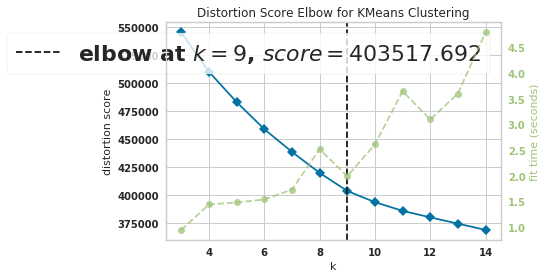

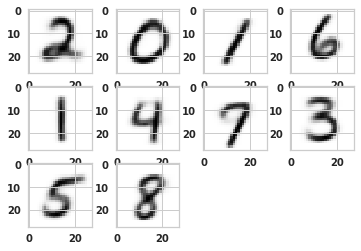

In [96]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = get_model(dao = dao,
              exp_config=exp_config,
              model_type=MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
              num_epochs=1,
              sess=sess,
              test_data_iterator=None,
              train_val_data_iterator=None)
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()

filename  = get_encoded_csv_file(exp_config, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

kmeans_model = KMeans()
visualizer = KElbowVisualizer(kmeans_model, k=(3, 15))

visualizer.fit(latent_vectors)  
visualizer.show(exp_config.ANALYSIS_PATH + "elbow_curve_after_{}_epochs.jpg".format(epochs_completed))

num_clusters = 10

manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                                    num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config,
                                                                                    dao
                                                                                   )
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


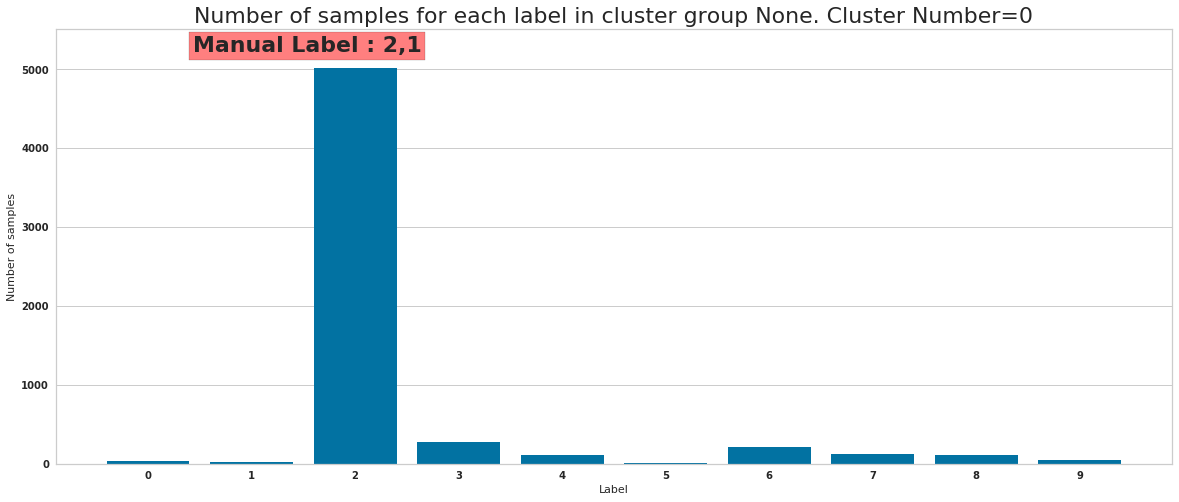

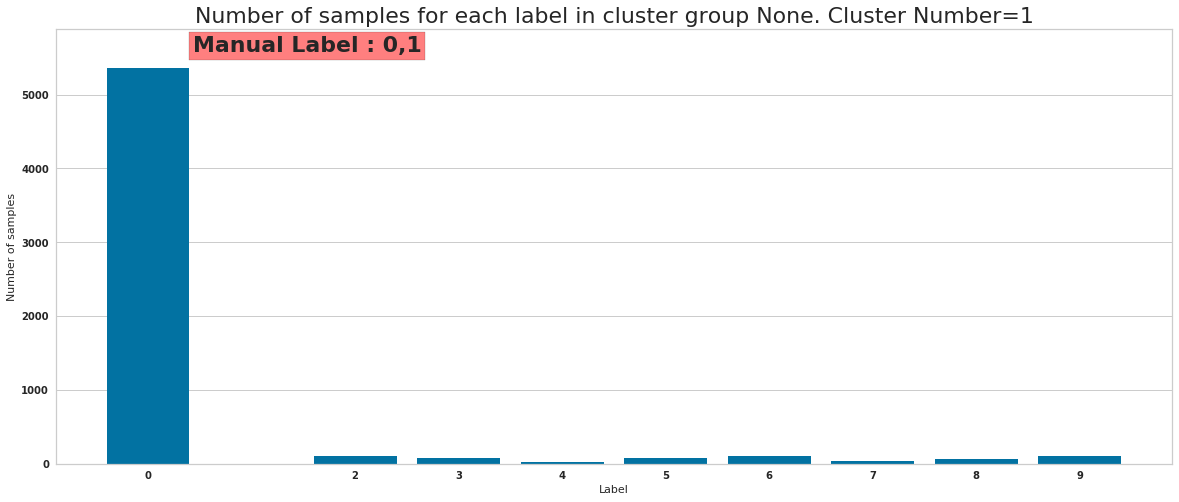

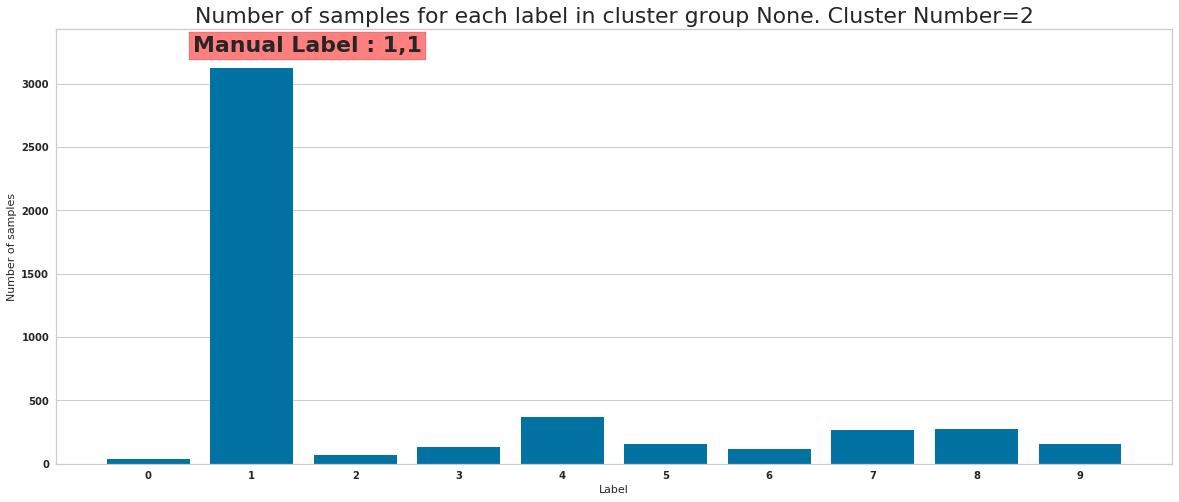

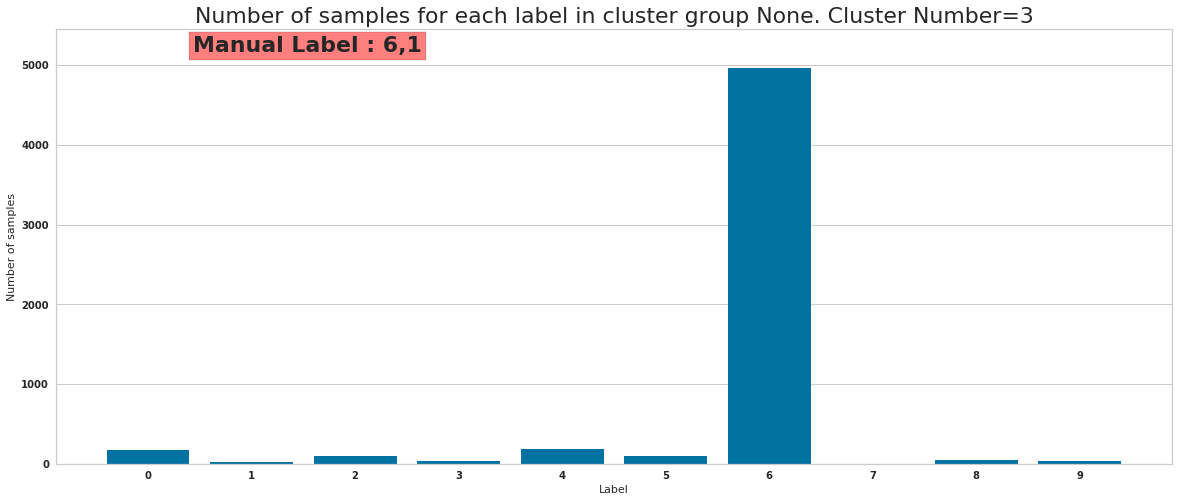

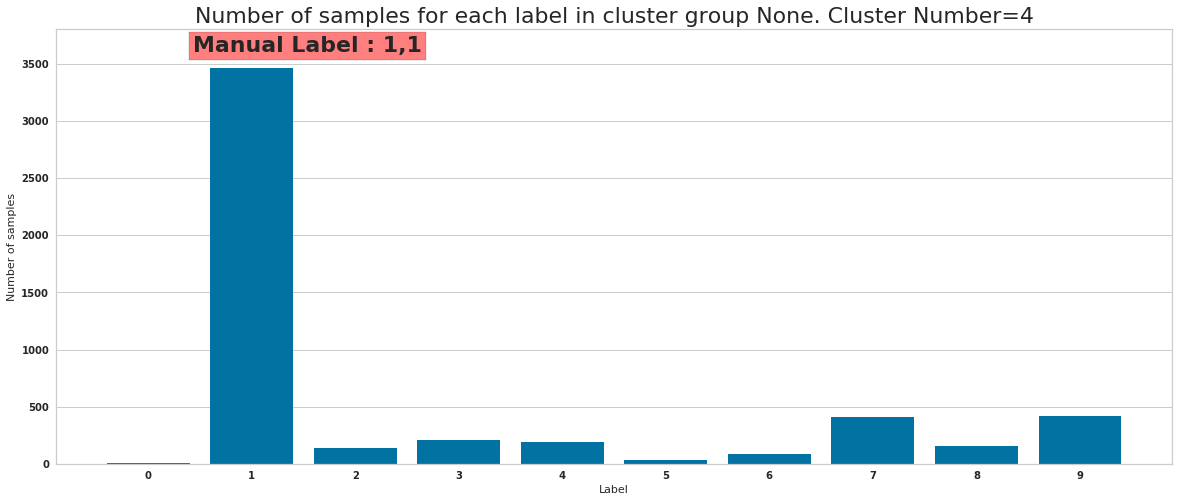

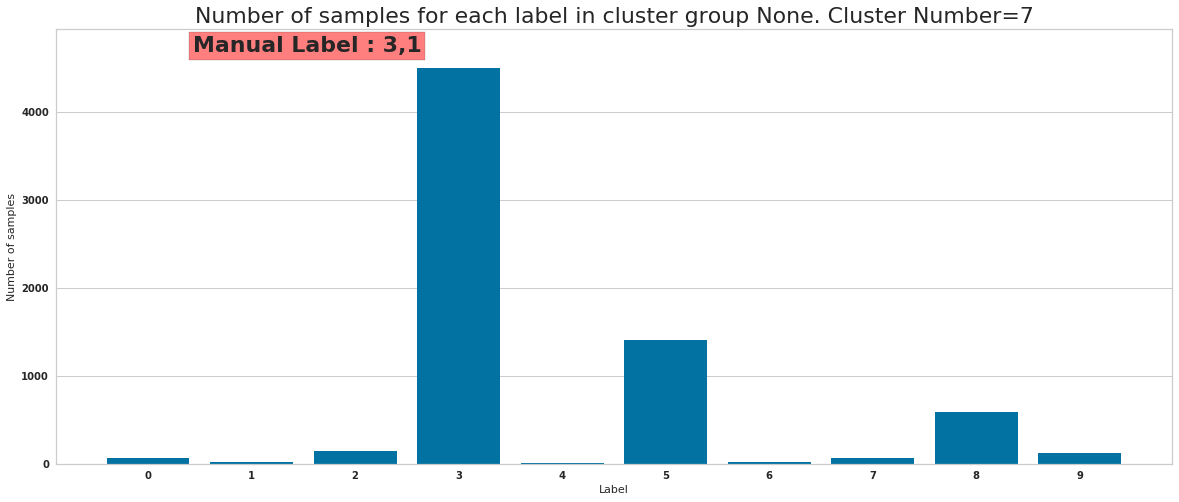

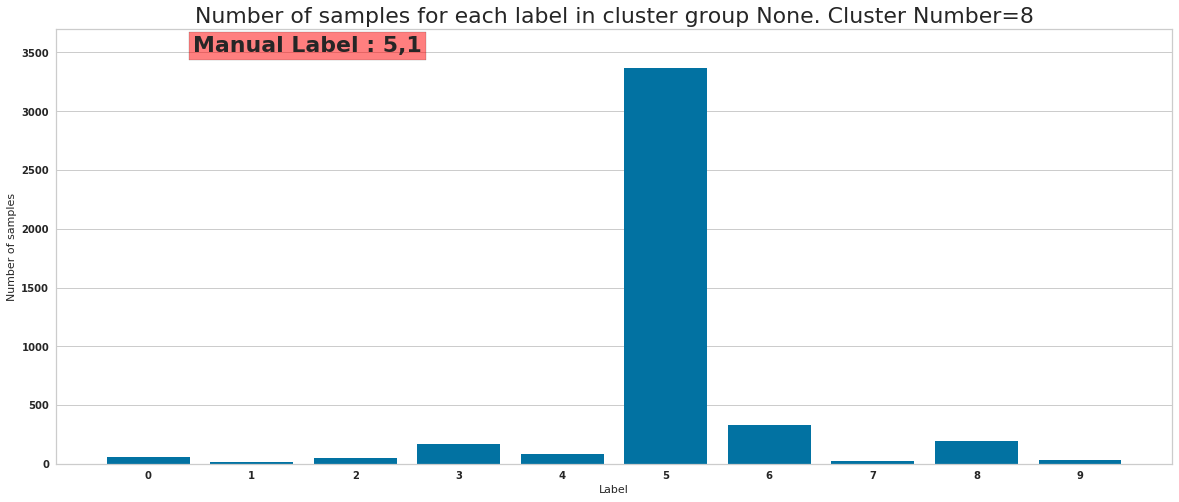

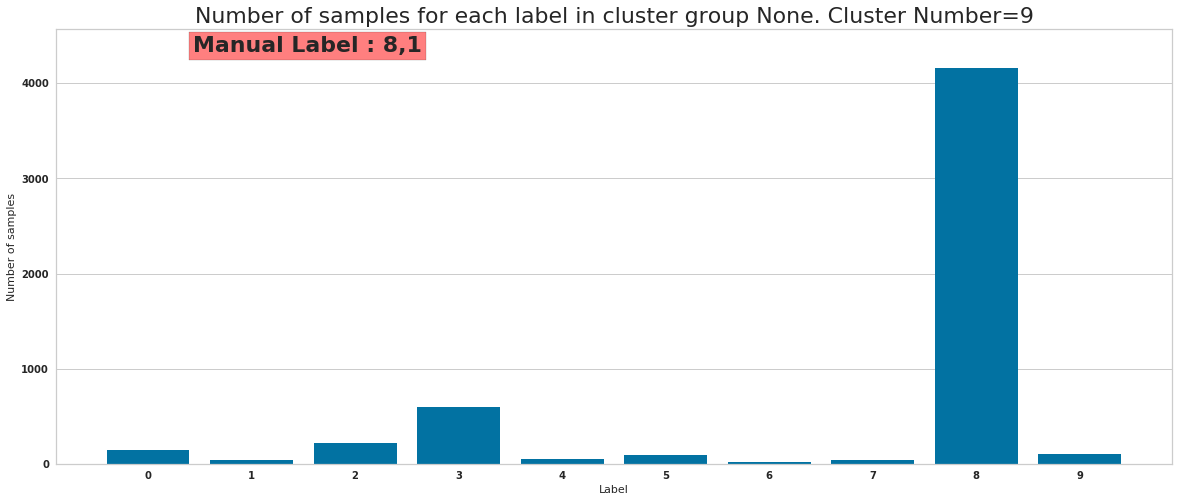

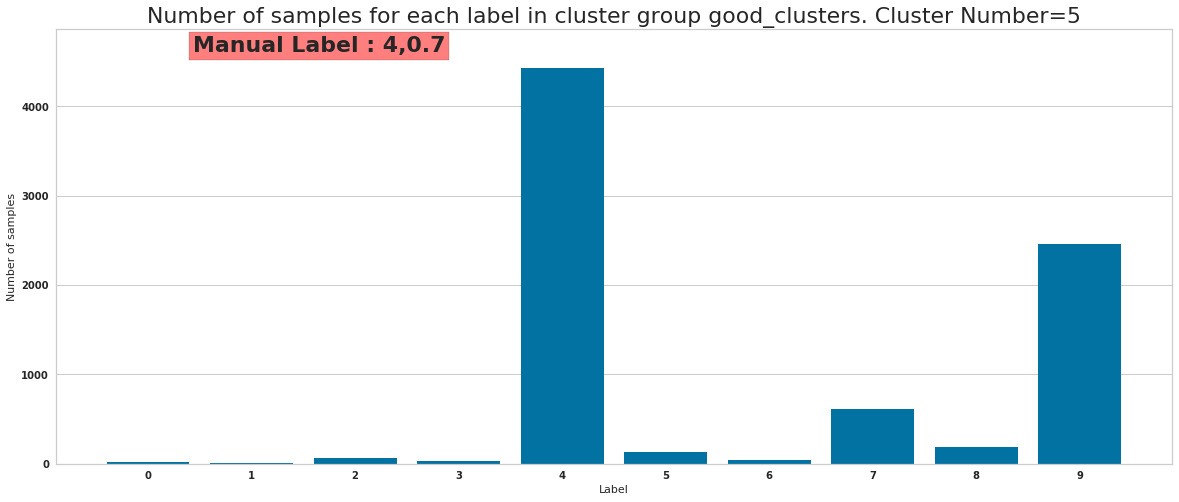

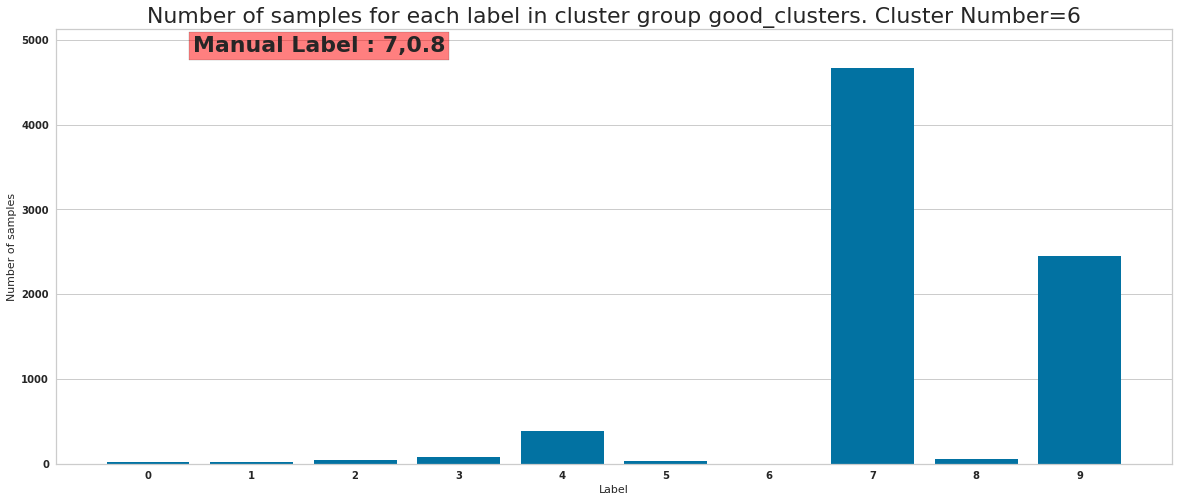

In [97]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [2,0,1,6,
                                           1,4,7,3,
                                           5,8
                                          ]
manual_annotation_json["manual_confidence"] = [1,1,1,1,
                                               1,0.7,0.8,1,
                                               1,1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(exp_config,
                                    cluster_group_name,
                                    cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}",
                                    manual_labels,
                                    manual_confidence
                                   )



In [98]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []
tf.reset_default_graph()
cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters
                                                               )
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(exp_config,
                                                                df,
                                                                cluster_column_name_2,
                                                                cluster_labels,
                                                                z_col_names,
                                                                MODEL_TYPE_VAE_SEMI_SUPERVISED_MNIST,
                                                                epochs_completed,
                                                                dao,
                                                                cluster_group_dict,
                                                                processed_clusters = [i[0] for i in processed_clusters]
                                                               )



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [96]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[2] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [97]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

Manual Label 2
(6259, 47) (6259, 33)
Num correct=5034
Cluster 0 Manual Label 2 Percentage correct 80.42818341588114
********************************
Manual Label 3
(6954, 47) (6954, 33)
Num correct=4243
Cluster 1 Manual Label 3 Percentage correct 61.01524302559678
********************************
Manual Label 1
(7147, 47) (7147, 33)
Num correct=6439
Cluster 2 Manual Label 1 Percentage correct 90.09374562753602
********************************
Manual Label 7
(5853, 47) (5853, 33)
Num correct=5163
Cluster 3 Manual Label 7 Percentage correct 88.21117375704767
********************************
Manual Label 5
(3966, 47) (3966, 33)
Num correct=2855
Cluster 4 Manual Label 5 Percentage correct 71.98688855269793
********************************
Manual Label 4
(6608, 47) (6608, 33)
Num correct=2669
Cluster 5 Manual Label 4 Percentage correct 40.39043583535109
********************************
Manual Label 0
(5392, 47) (5392, 33)
Num correct=4749
Cluster 6 Manual Label 0 Percentage correct 88.07492

In [98]:
df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)

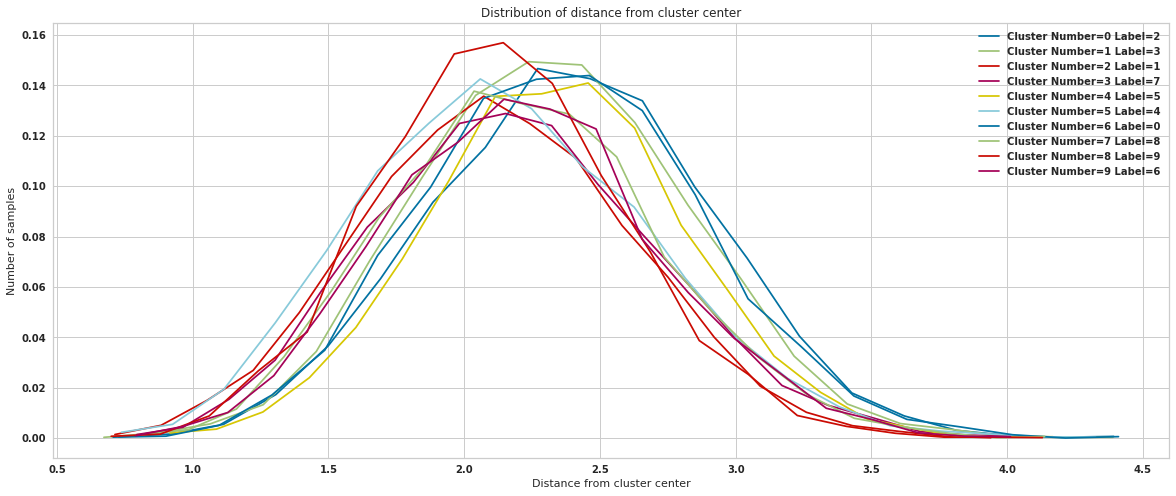

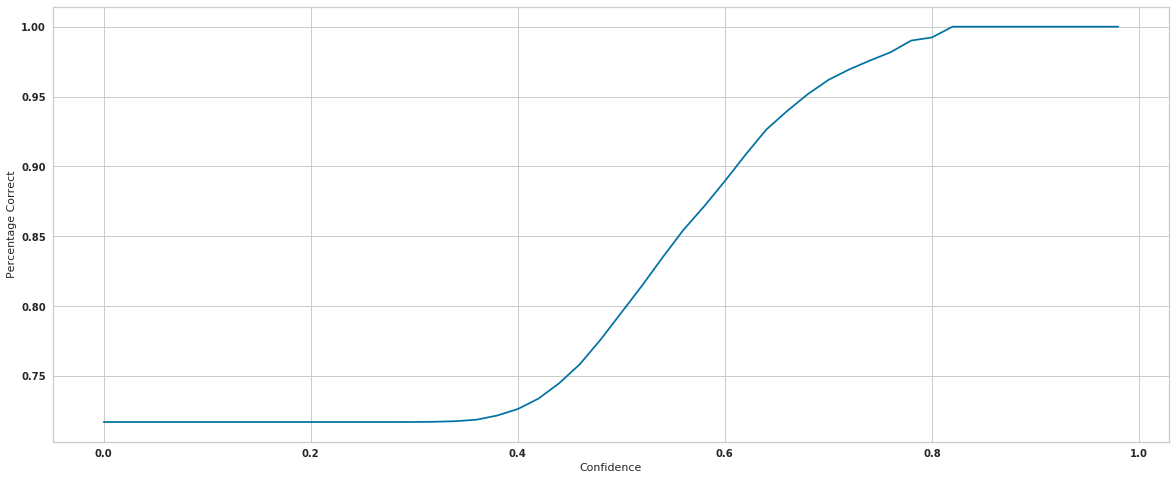

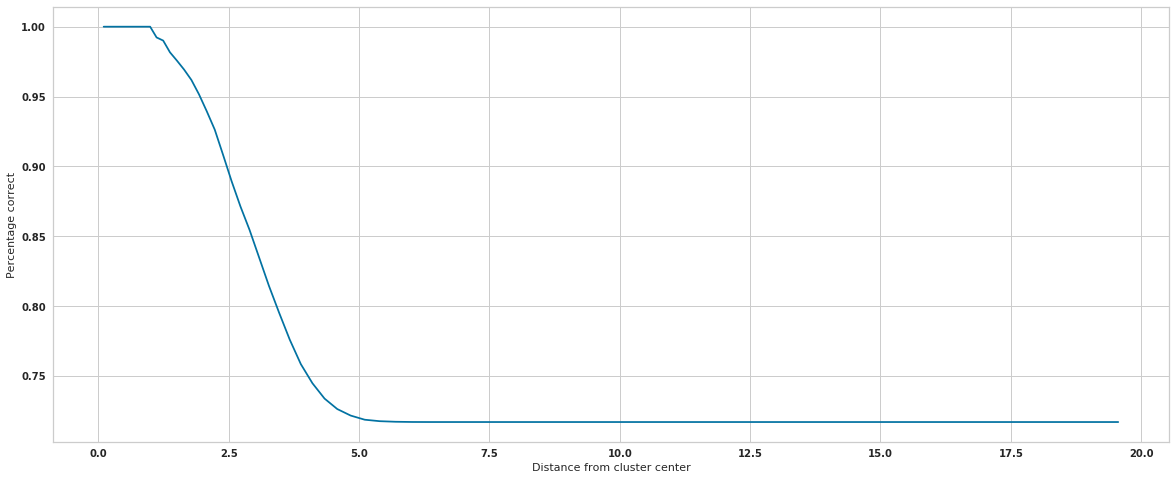

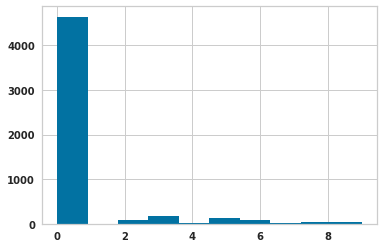

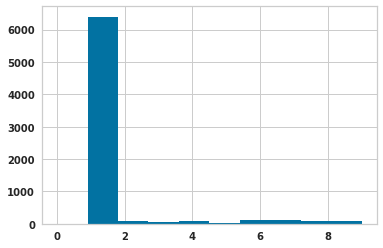

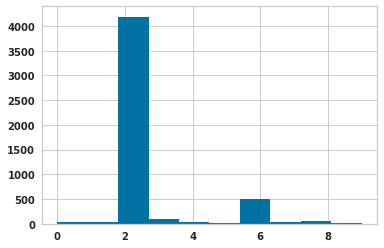

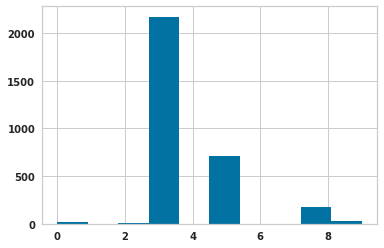

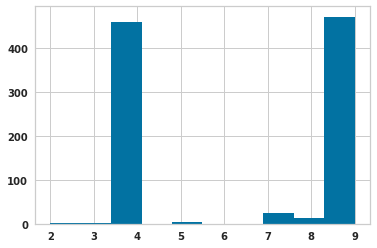

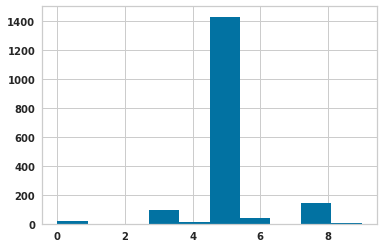

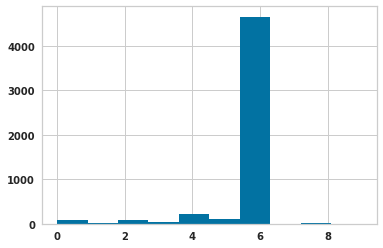

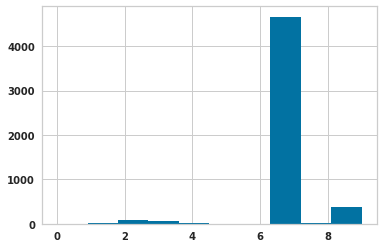

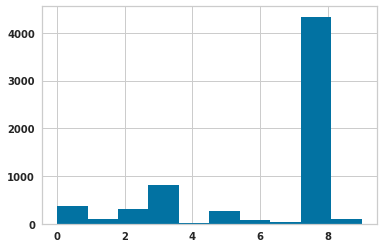

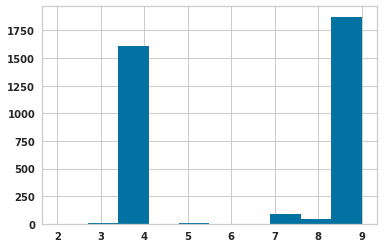

In [99]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution(df, list(range(num_clusters)), cluster_column_name, manual_labels)

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [100]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name=experiment_name,
                                        z_dim=z_dim,
                                        run_id=run_id,
                                        create_split=create_split,
                                        num_epochs=num_epochs,
                                        num_cluster_config=num_cluster_config,
                                        num_epochs_completed=num_epochs)
tf.reset_default_graph()

TypeError: initialize_model_train_and_get_features() missing 1 required positional argument: 'model_type'

INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-5610
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_10/trained_models/ClassifierModel.model-5610
 [*] Success to read ClassifierModel.model-5610
 [*] Load SUCCESS
Number of steps completed=5610
Number of epochs completed 6.0
run_id=10 z_min=-5.0479445 z_max=4.711913
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instea

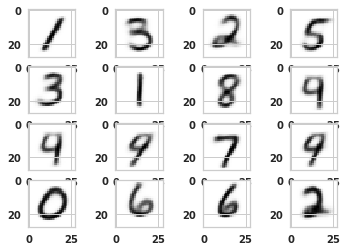

In [75]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


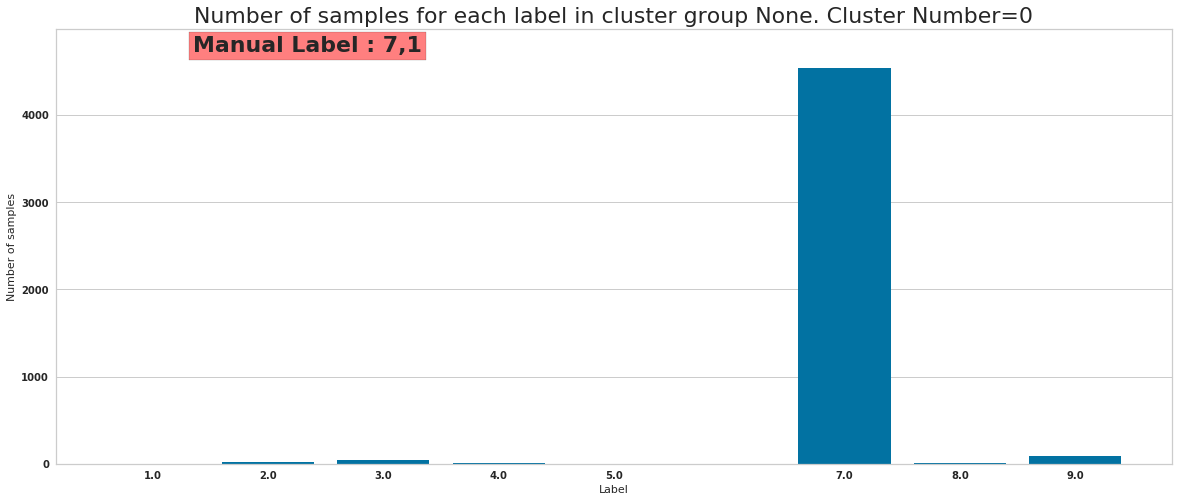

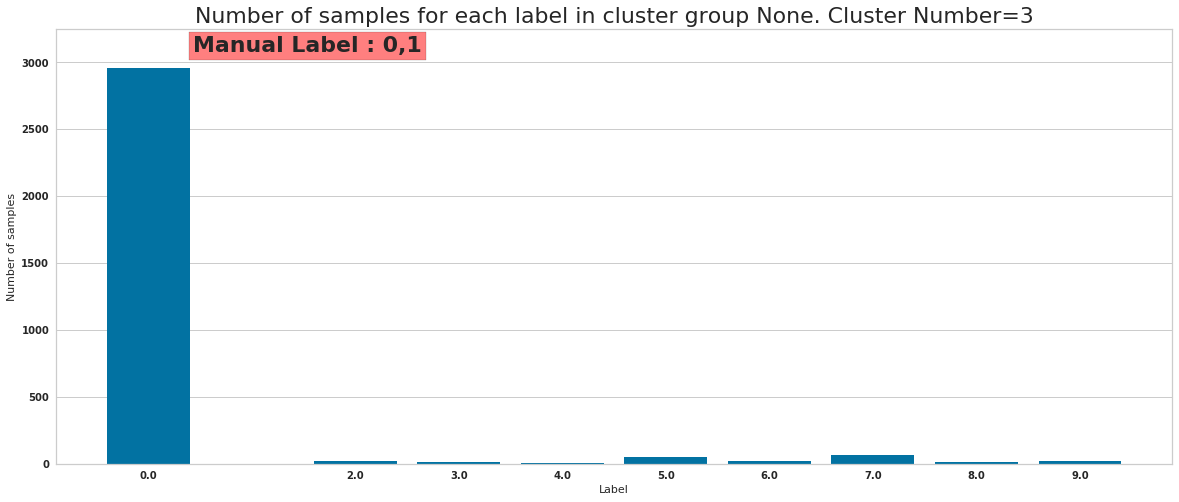

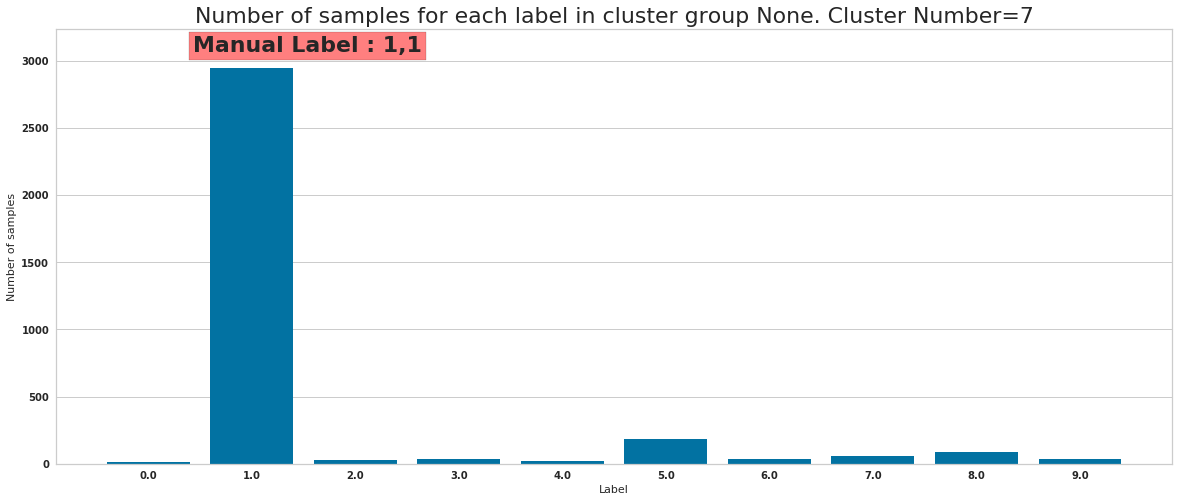

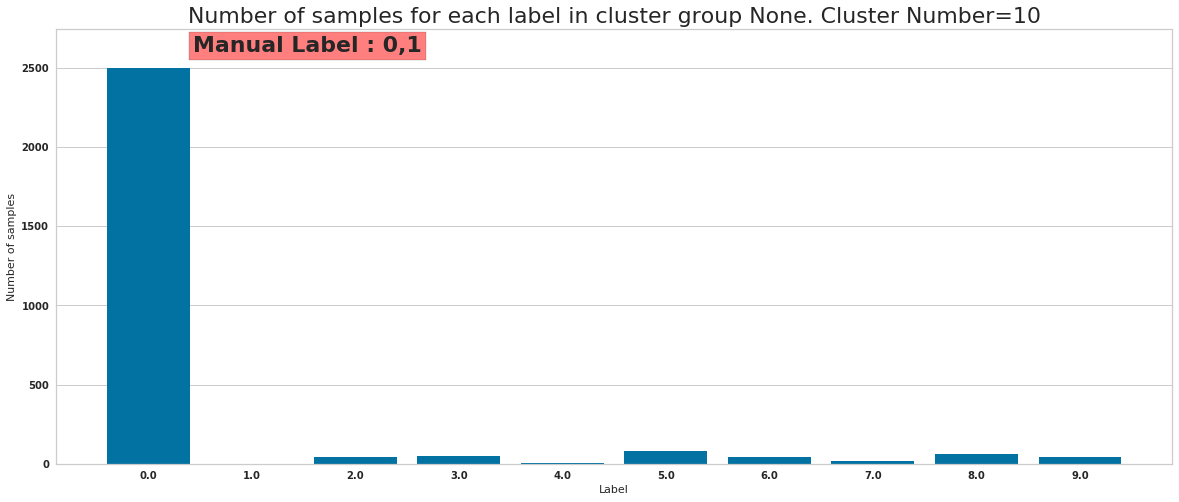

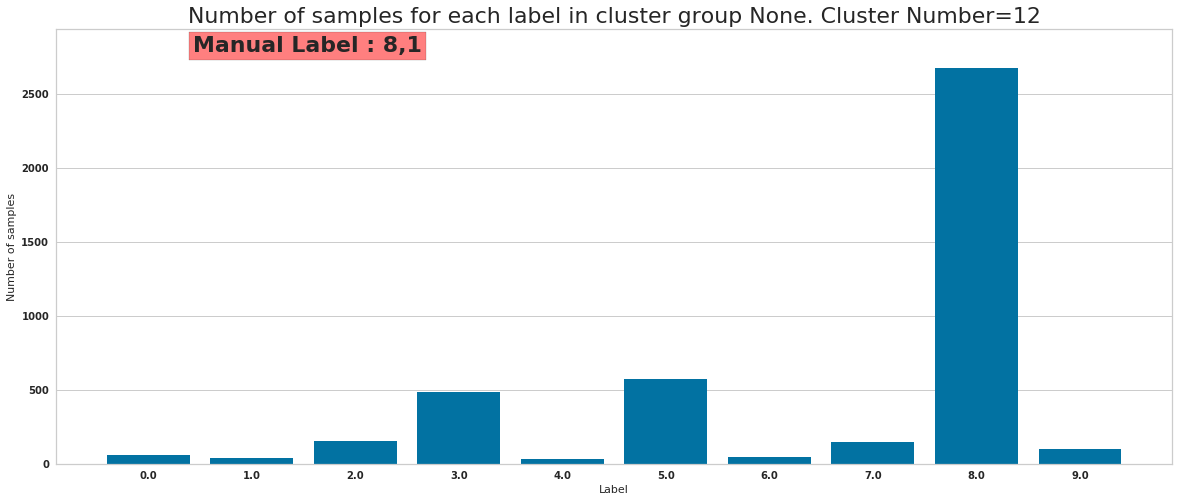

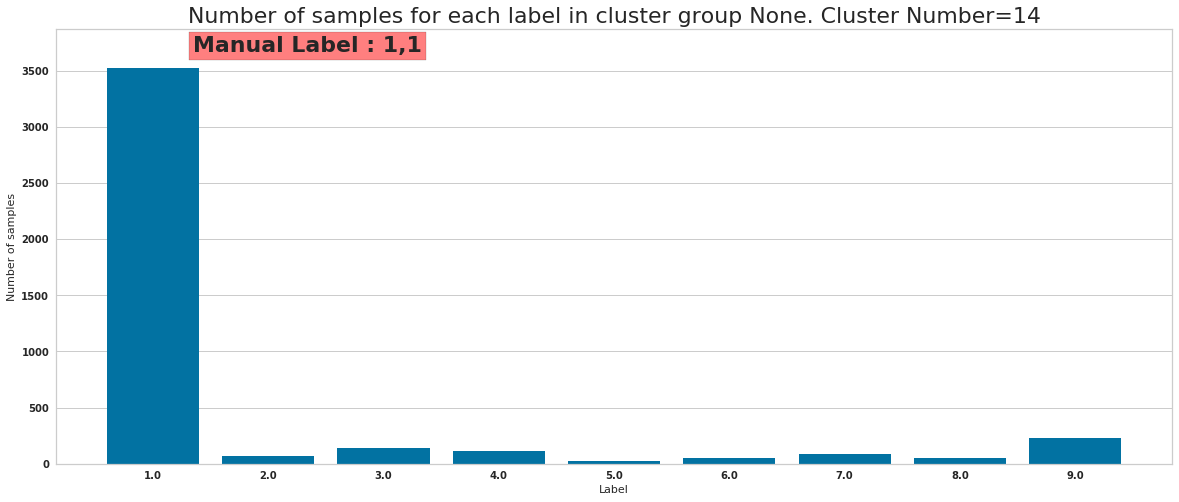

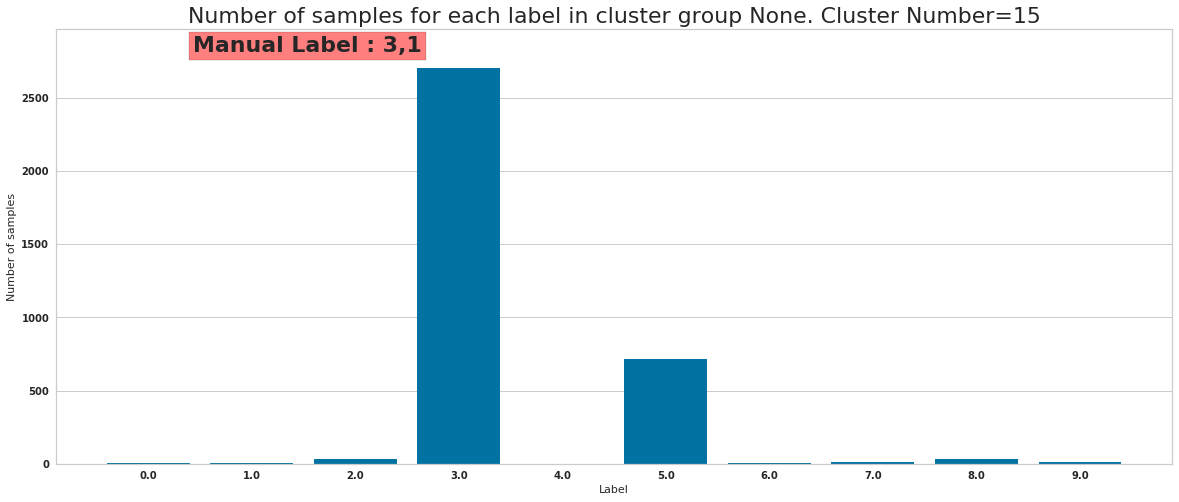

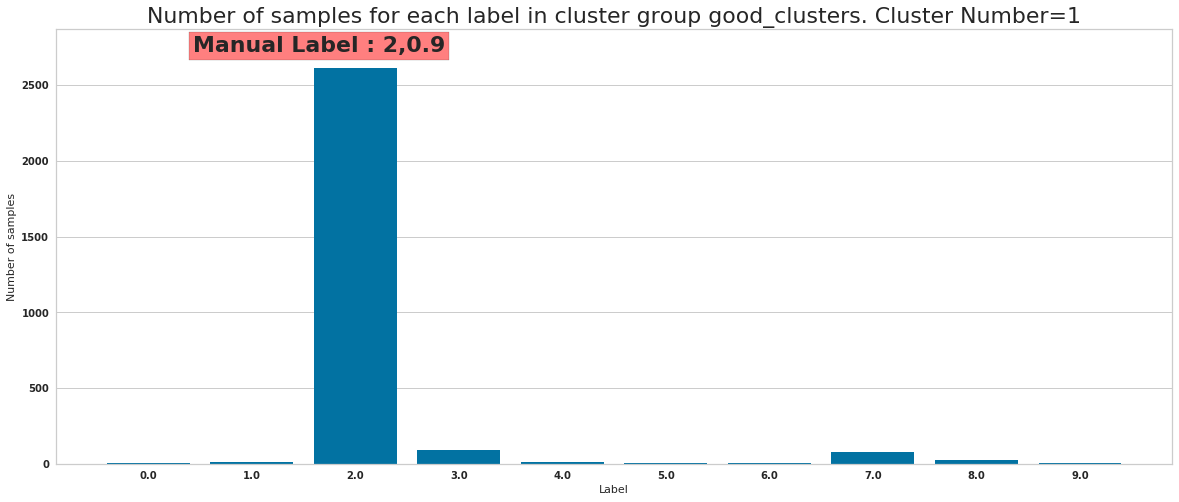

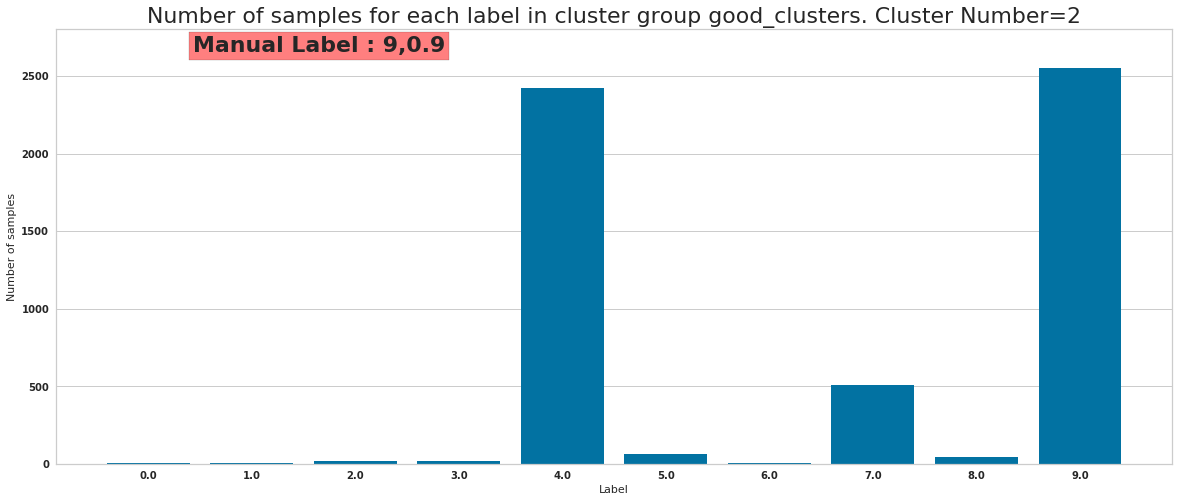

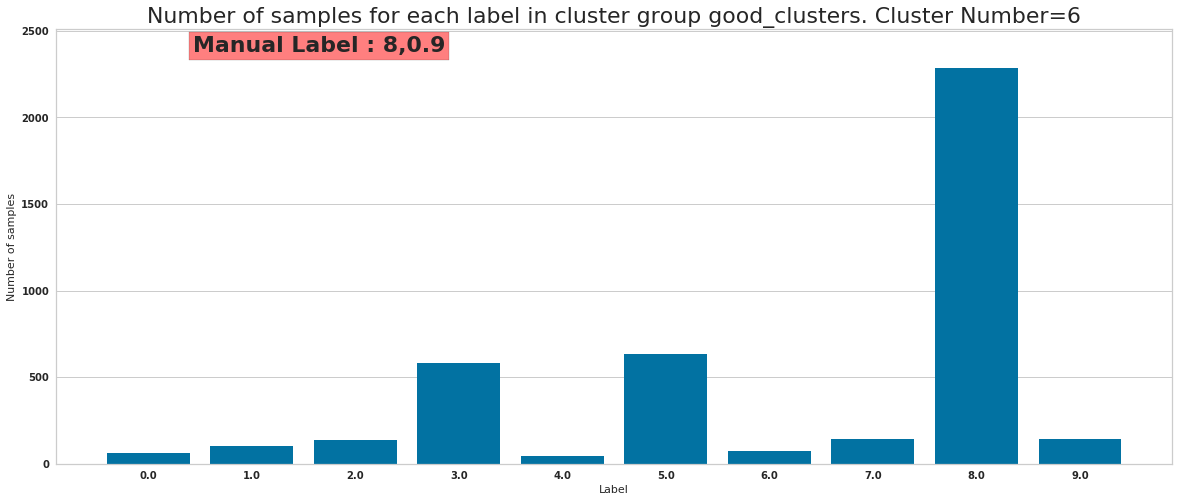

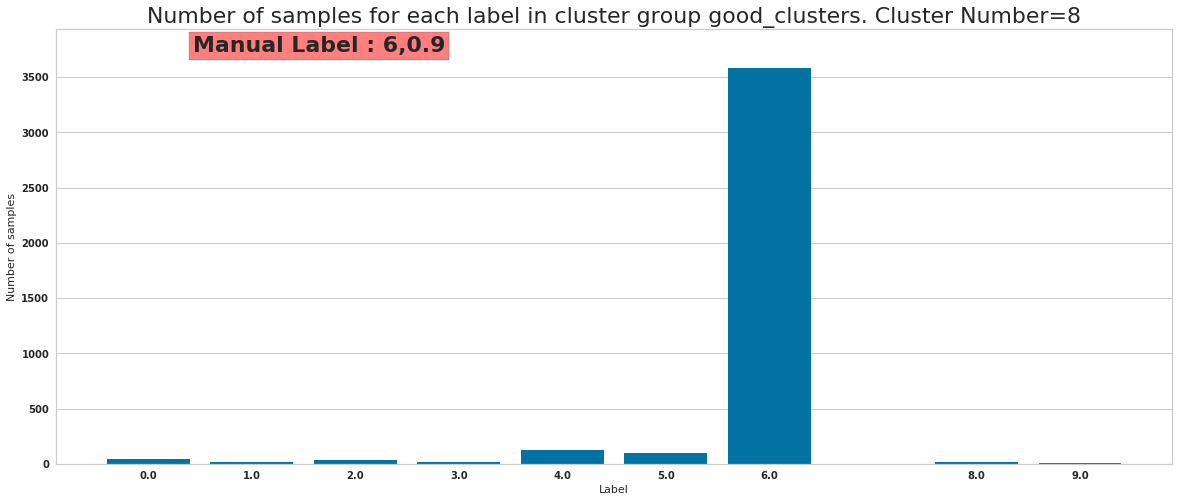

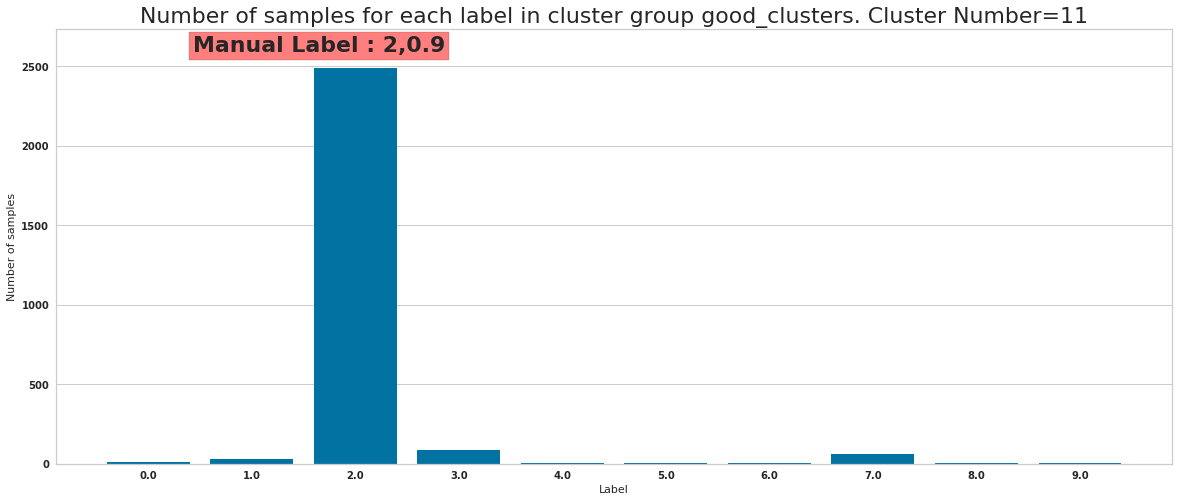

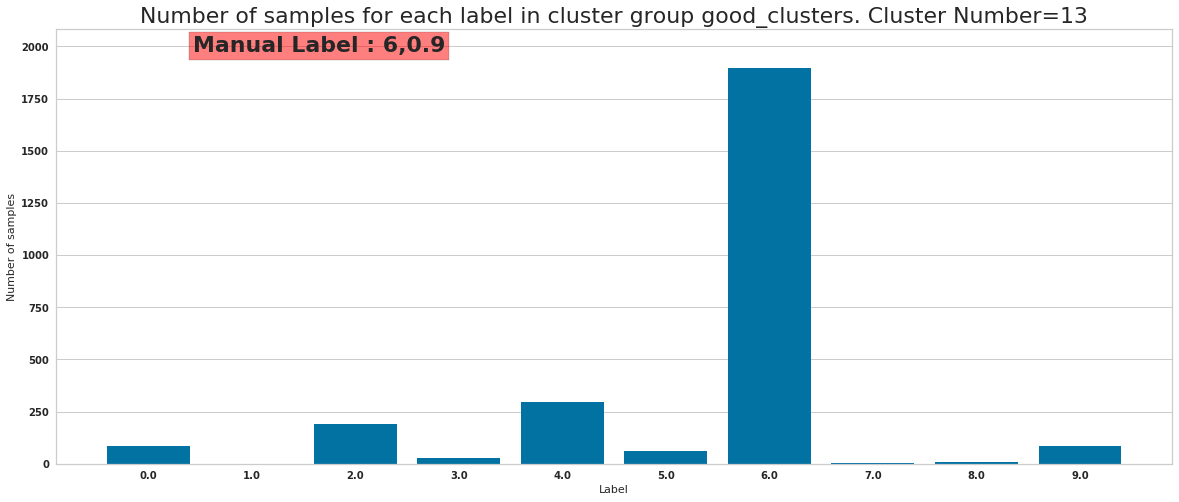

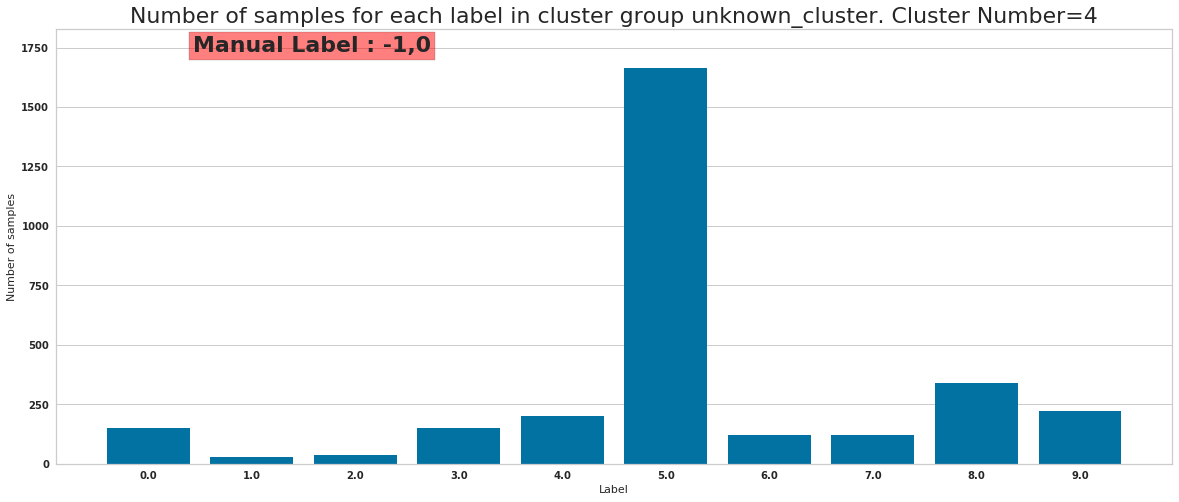

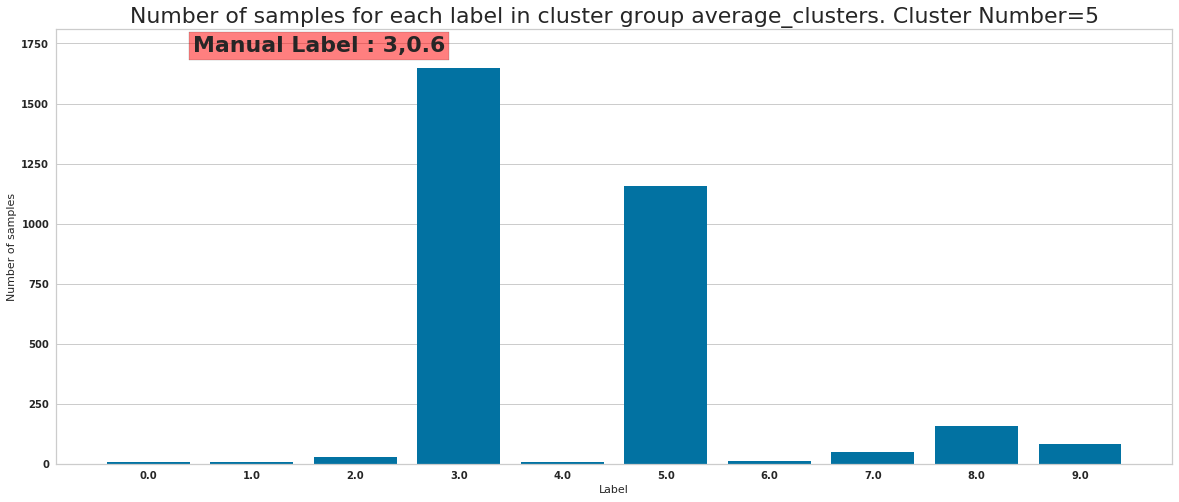

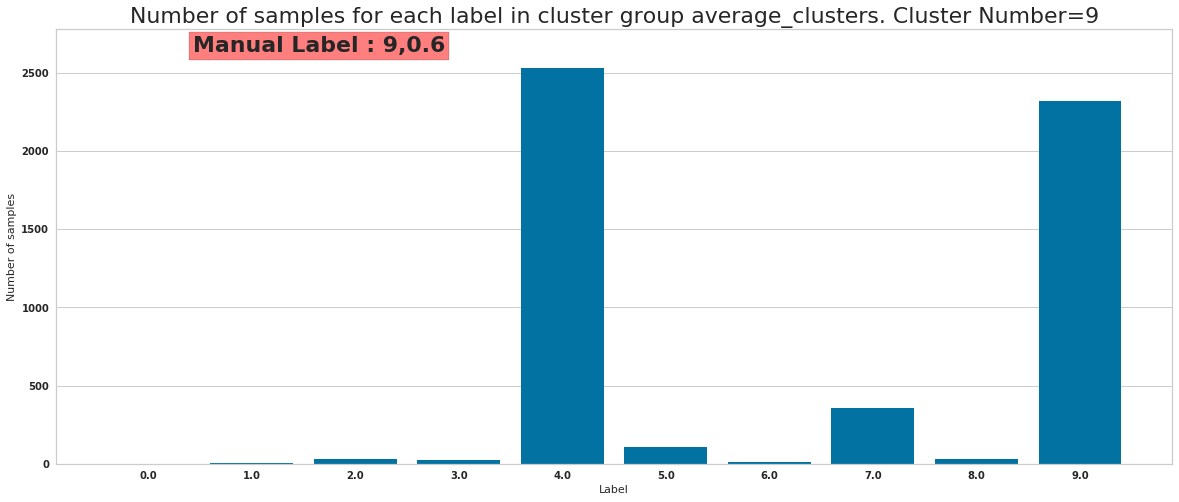

In [115]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [7,2,9,0,
                                           -1,3,8,1,
                                           6,9,0,2,
                                           8,6,1,3
                                          ]
manual_annotation_json["manual_confidence"] = [1,0.9,0.9,1,
                                               0,0.6,0.9,1,
                                               0.9,0.6,1,0.9,
                                               1,0.9,1,1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}"
                                   )




4
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-5610
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-5610
 [*] Success to read ClassifierModel.model-5610
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


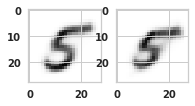

In [116]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []

cluster, _cluster_centers, _cluster_labels = cluster_next_level(df, processed_clusters)
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(df,
                                                                    [i[0] for i in processed_clusters])


In [117]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1,-1]
level_2_cluster_dict["manual_confidences"] = [0,0]
level2_manual_annotations[4] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [118]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)


4
2
Skipping distance computation for unknown cluster
Manual Label 7
(4718, 54) (4718, 49)
Num correct=4536
Cluster 0 Manual Label 7 Percentage correct 96.14243323442136
********************************
Manual Label 2
(2847, 54) (2847, 49)
Num correct=2609
Cluster 1 Manual Label 2 Percentage correct 91.64032314717247
********************************
Manual Label 9
(5642, 54) (5642, 49)
Num correct=2549
Cluster 2 Manual Label 9 Percentage correct 45.17901453385324
********************************
Manual Label 0
(3158, 54) (3158, 49)
Num correct=2954
Cluster 3 Manual Label 0 Percentage correct 93.54021532615579
********************************
unknown
<class 'dict'>
['unknown_cluster']
********************************
Manual Label 3
(3149, 54) (3149, 49)
Num correct=1646
Cluster 5 Manual Label 3 Percentage correct 52.270562083201014
********************************
Manual Label 8
(4202, 54) (4202, 49)
Num correct=2283
Cluster 6 Manual Label 8 Percentage correct 54.33127082341742
********

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is 

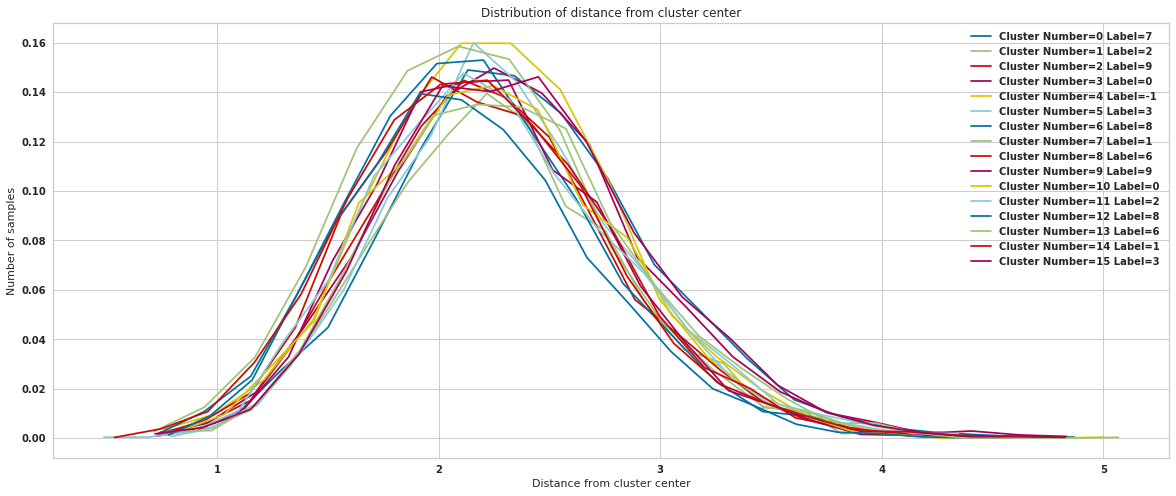

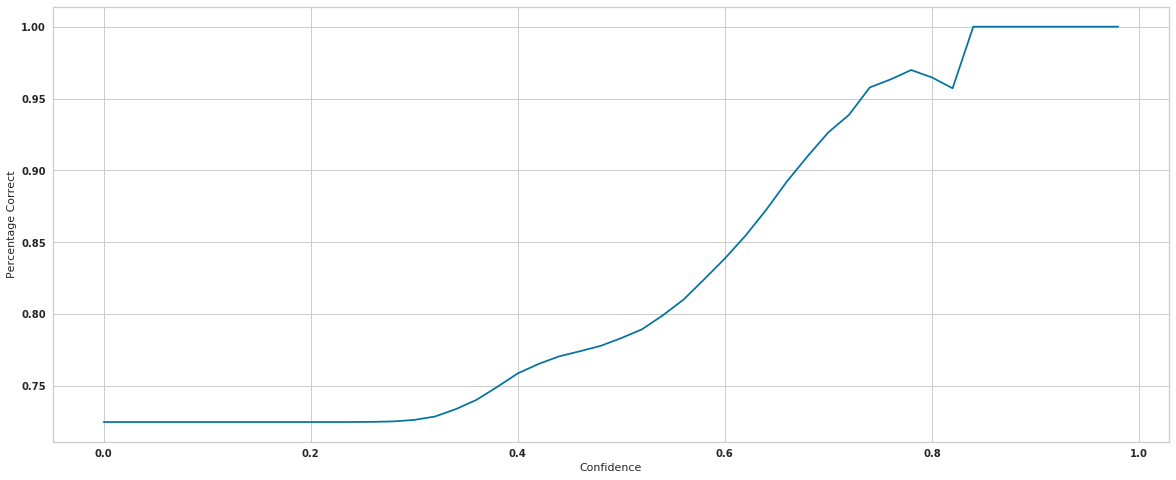

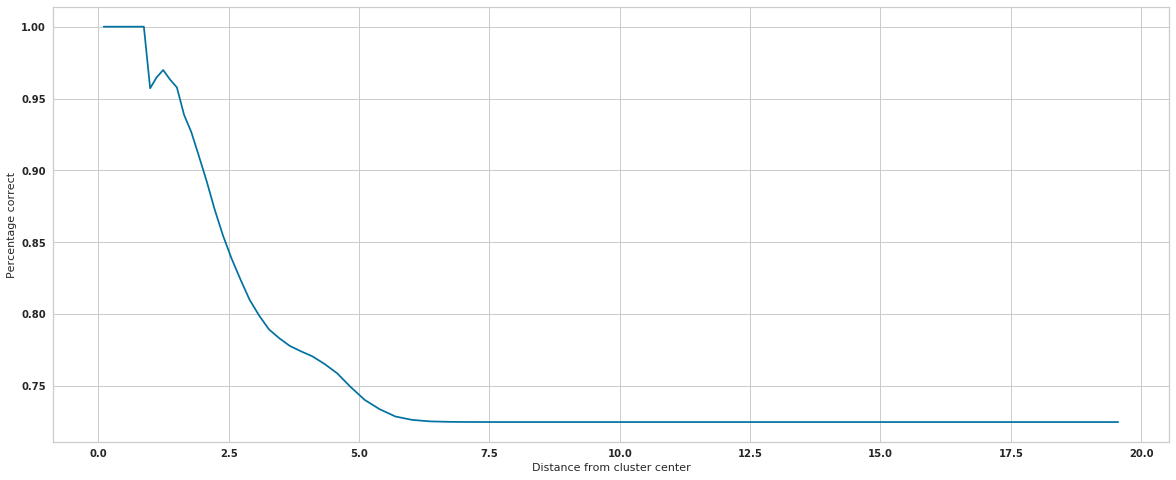

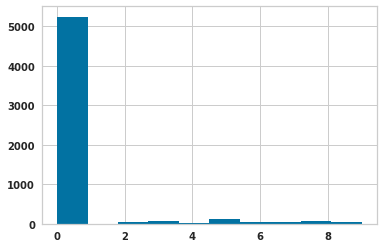

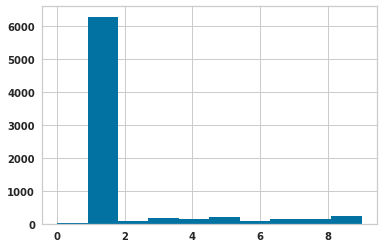

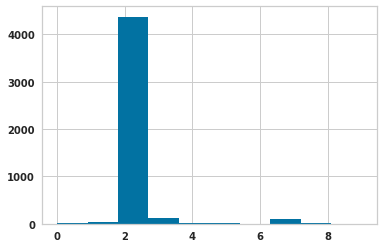

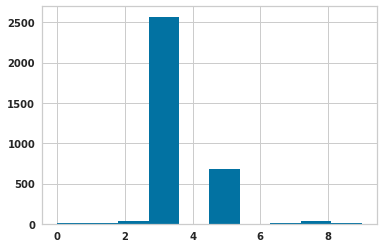

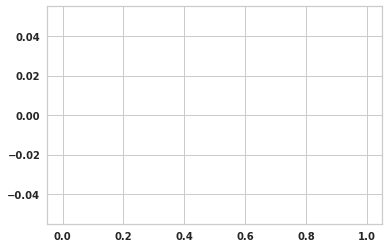

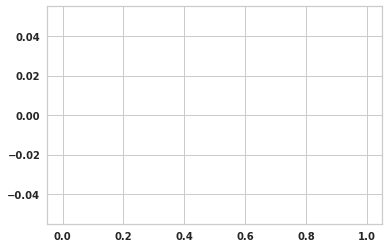

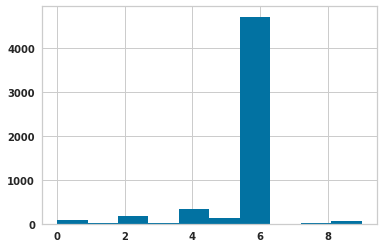

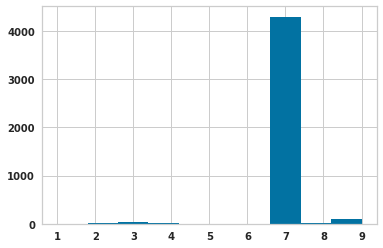

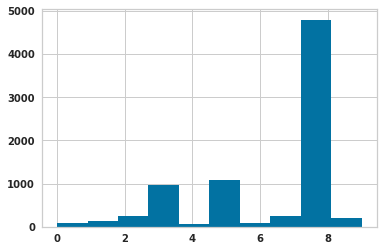

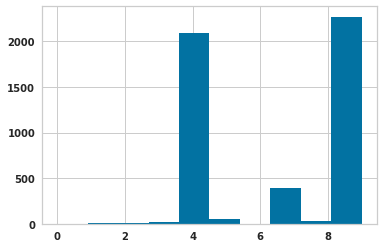

In [119]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution( list(range(num_clusters)))

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [120]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name,
                                        z_dim,
                                        run_id,
                                        create_split,
                                        num_epochs,
                                        num_cluster_config,
                                        manual_annotation_file)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32, 20], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'EVAL_INTERVAL': 300, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'RUN_ID': 2, 'ID': 1, 'name': 'VAE_MNIST', 'NUM_VALIDATION_SAMPLES': 128}
Loaded manual annotation
Number of samples with manual confidence 56805
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Running evaluation after epoch:06 and step:0300 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:6 step:300
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_06_0300/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:06 and step:0600 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:6 step:600
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_06_0600/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:06 and step:0900 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:6 step:900
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_06_0900/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed
Saving check point /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/
 [*] Training finished!
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-6545
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-6545
 [*] Success to read ClassifierModel.model-6545
 [*] Load SUCCESS
Number of steps completed=6545
Number of epochs completed 7.0
run_id=2 z_min=-4.9489493 z_max=4.856212
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.

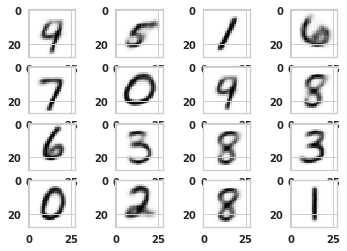

In [121]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


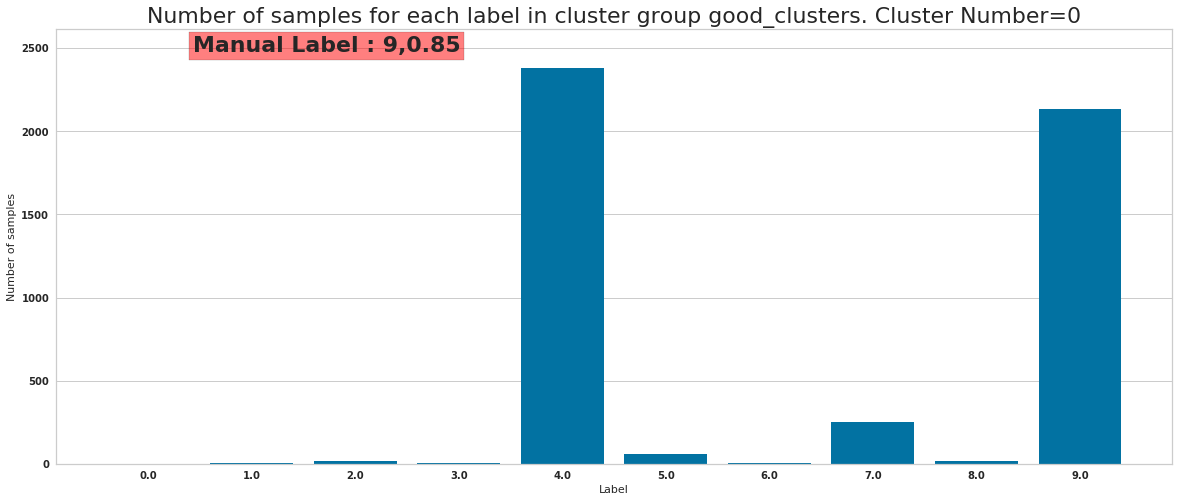

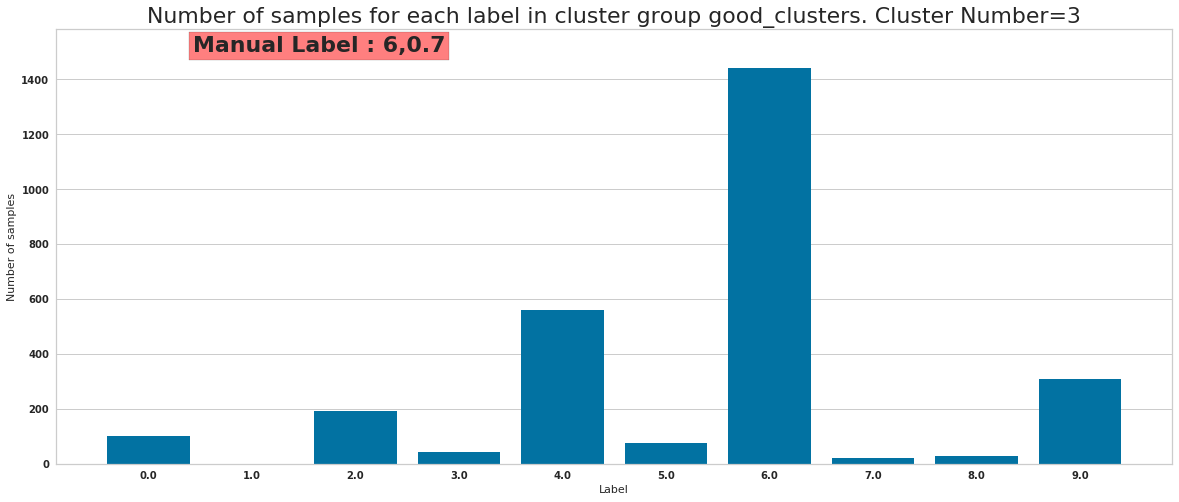

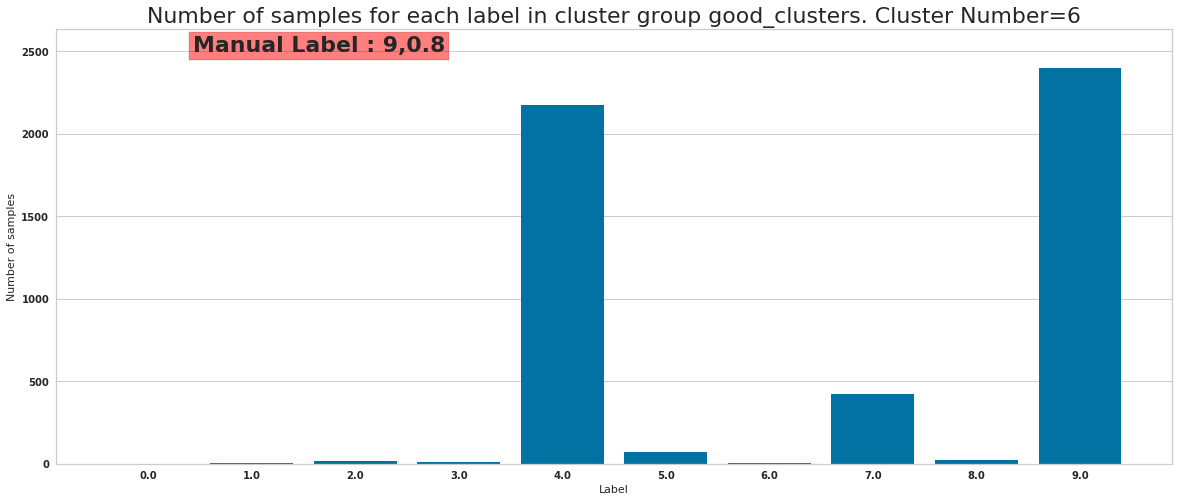

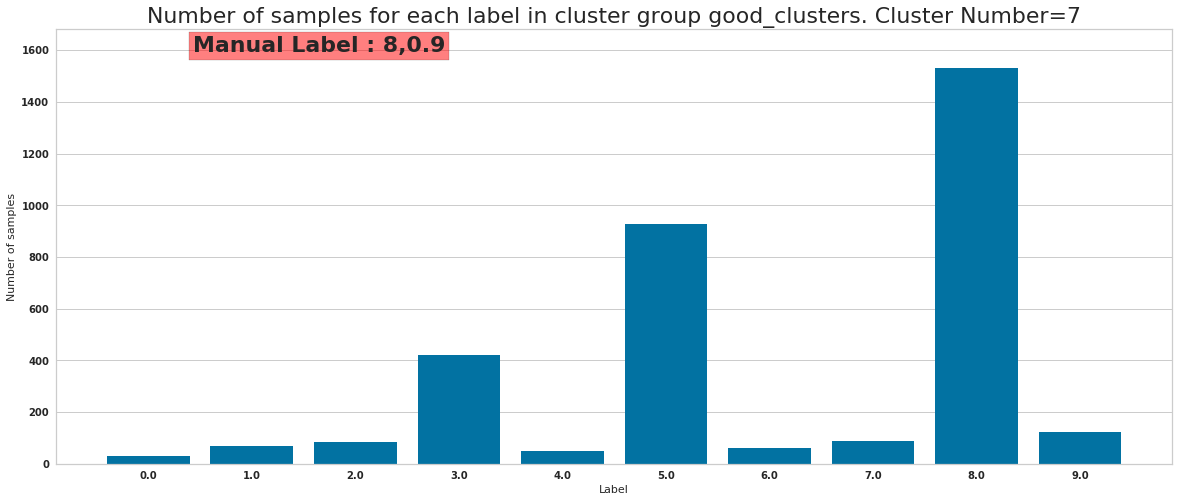

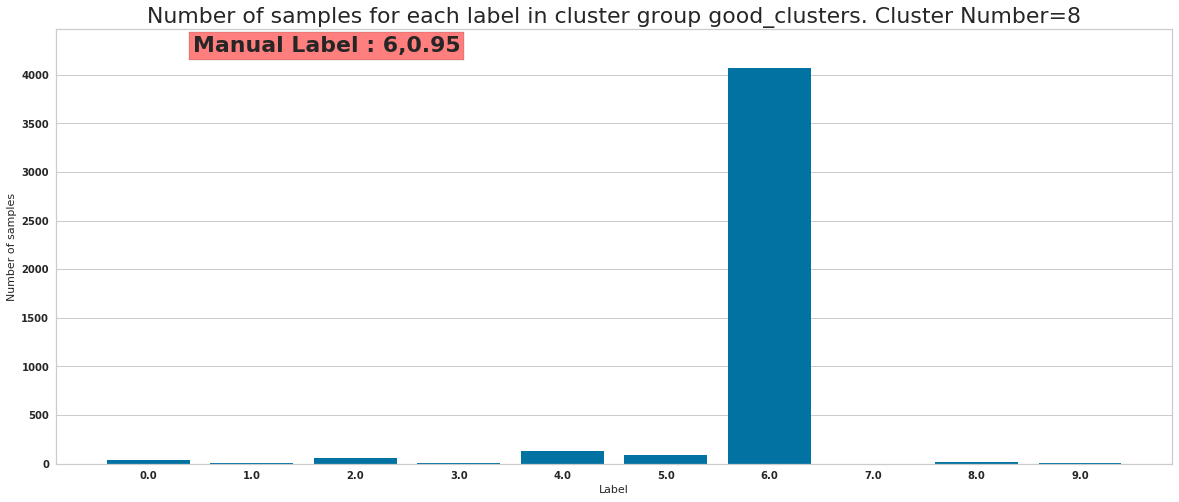

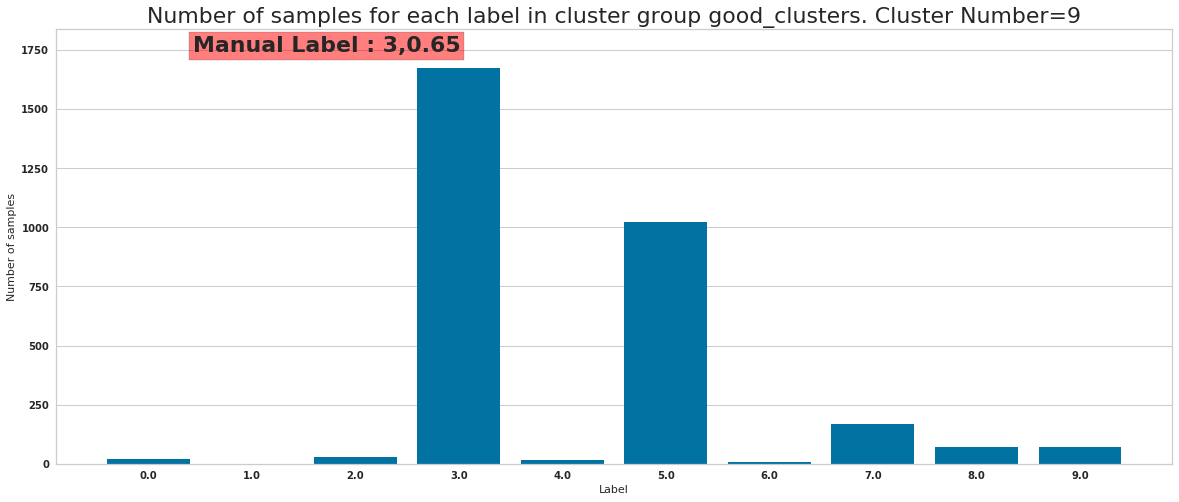

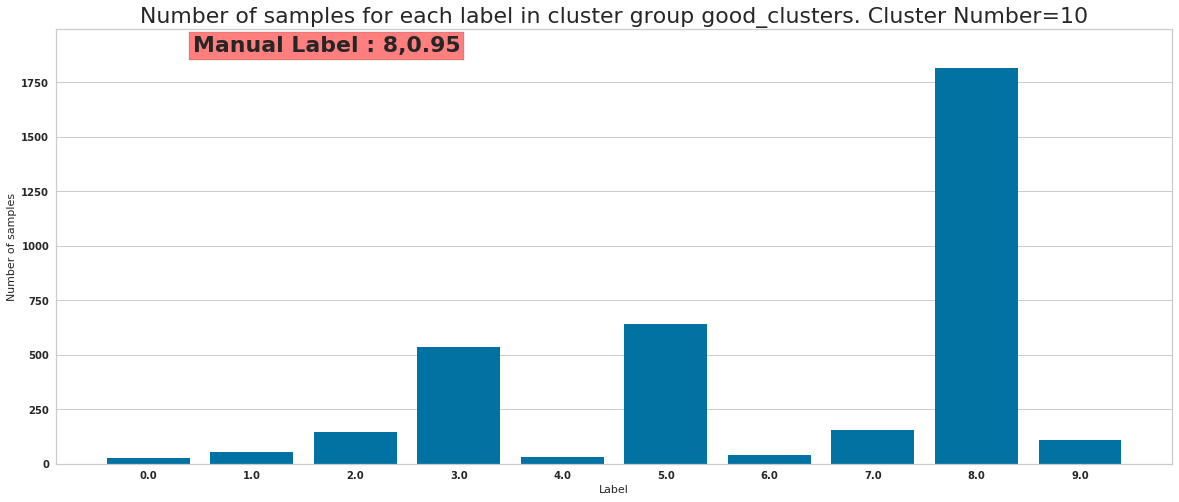

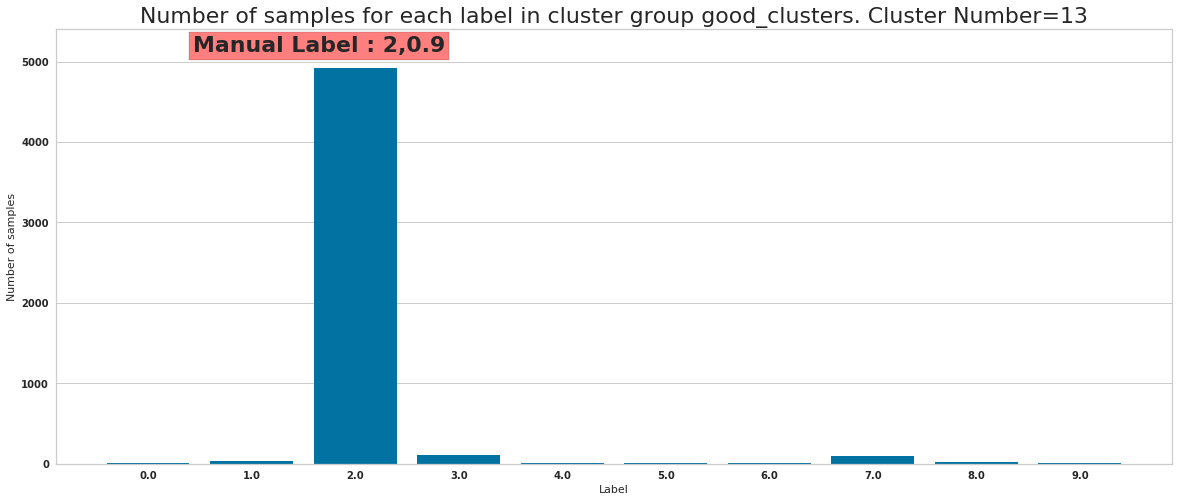

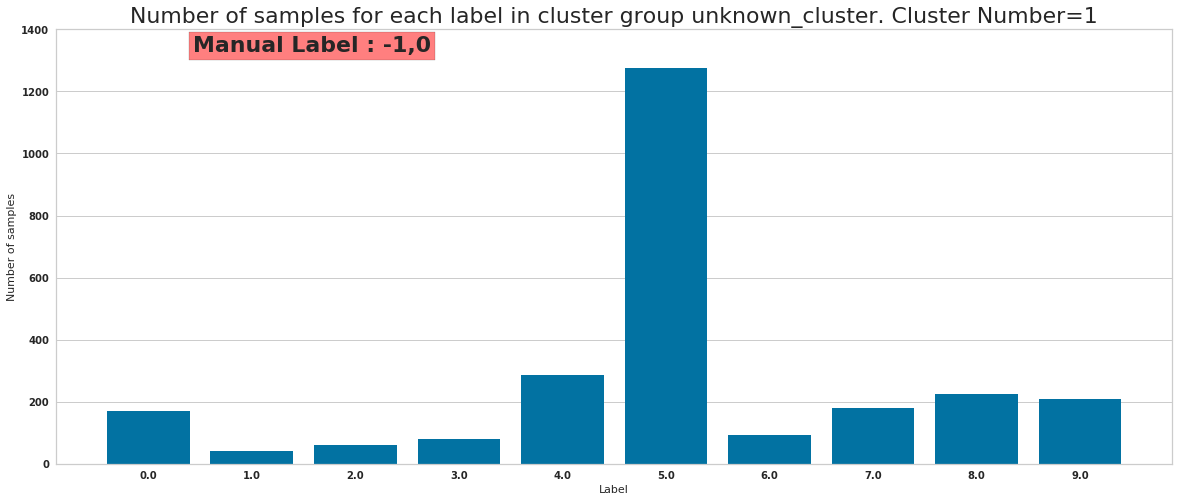

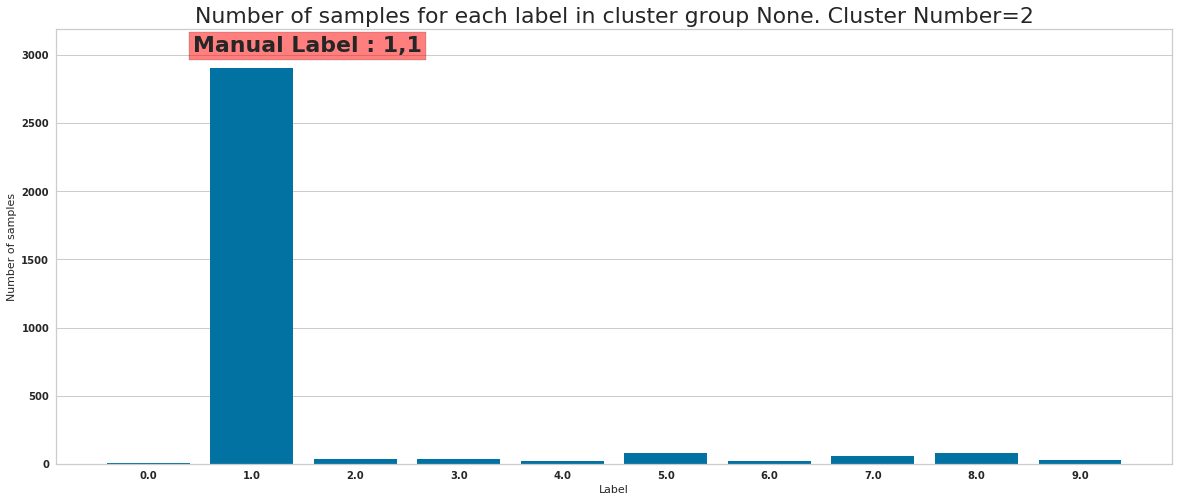

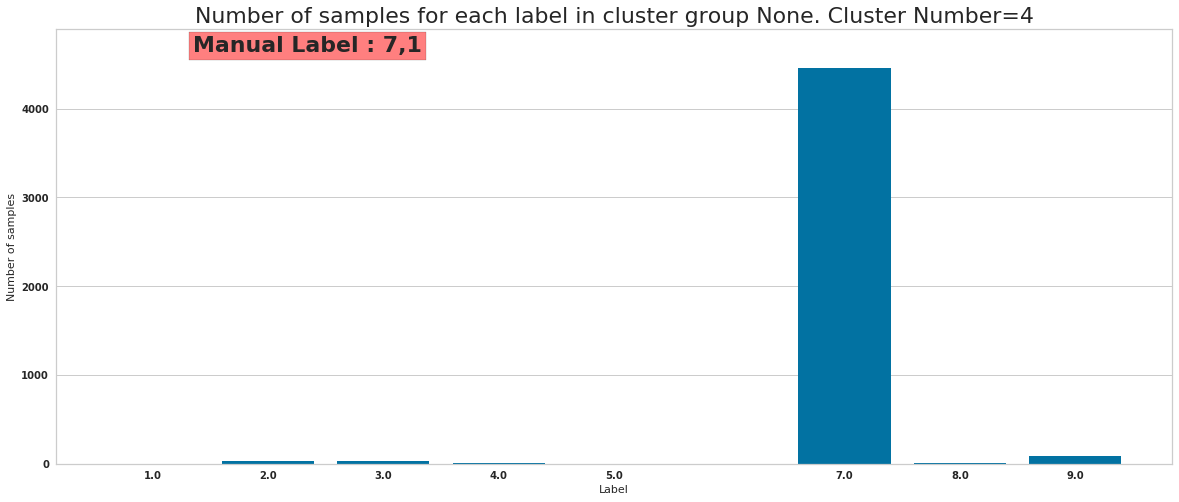

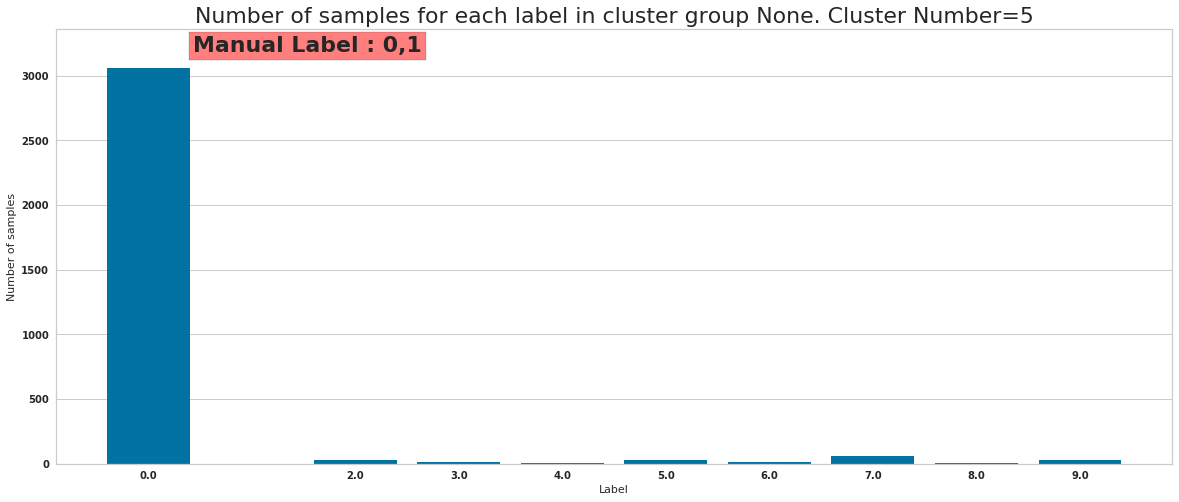

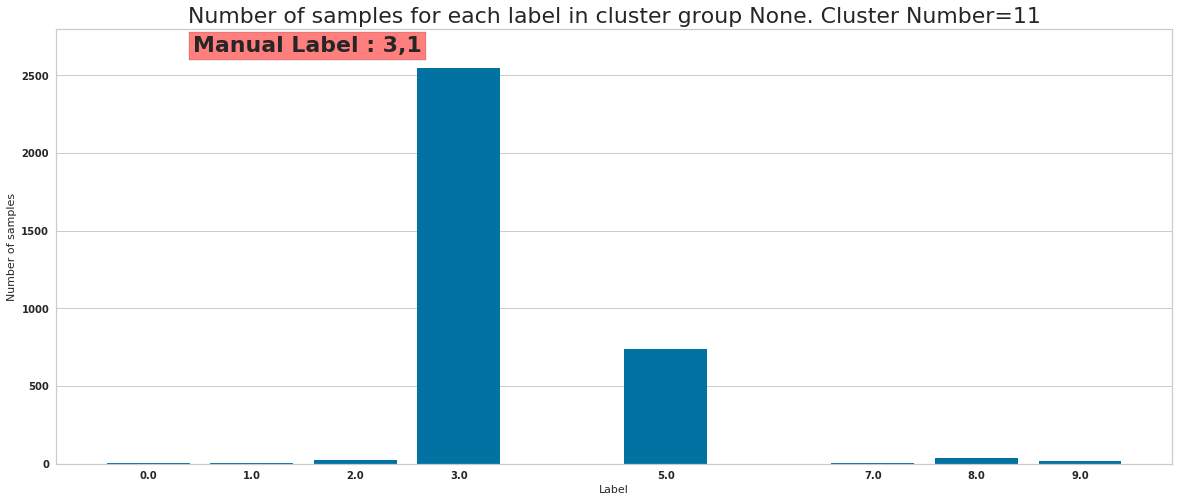

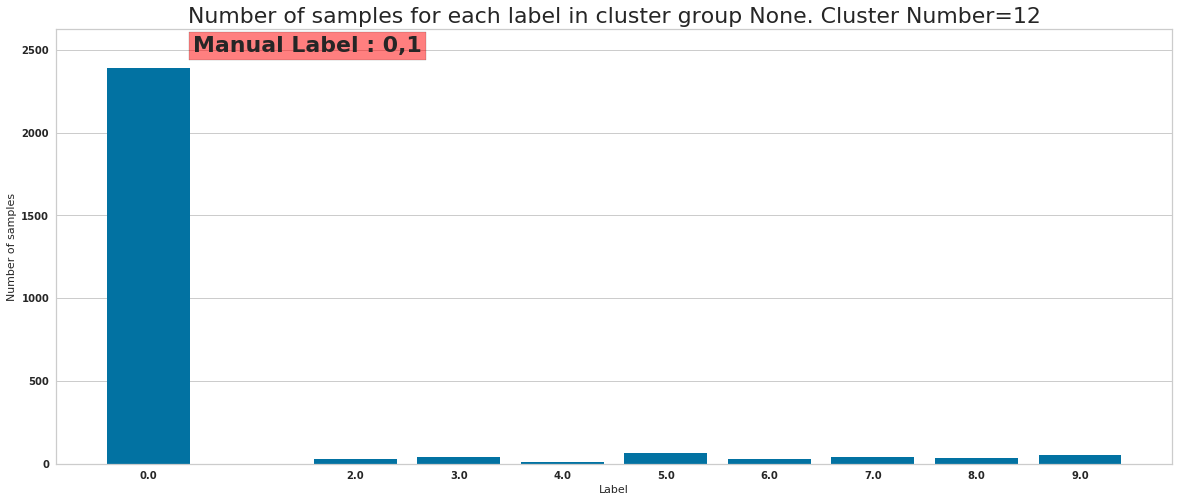

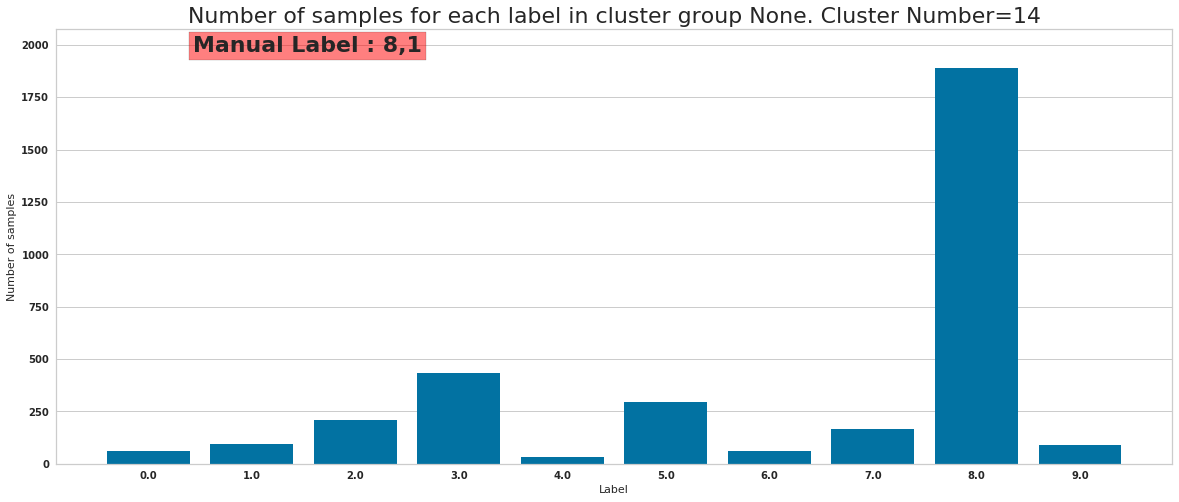

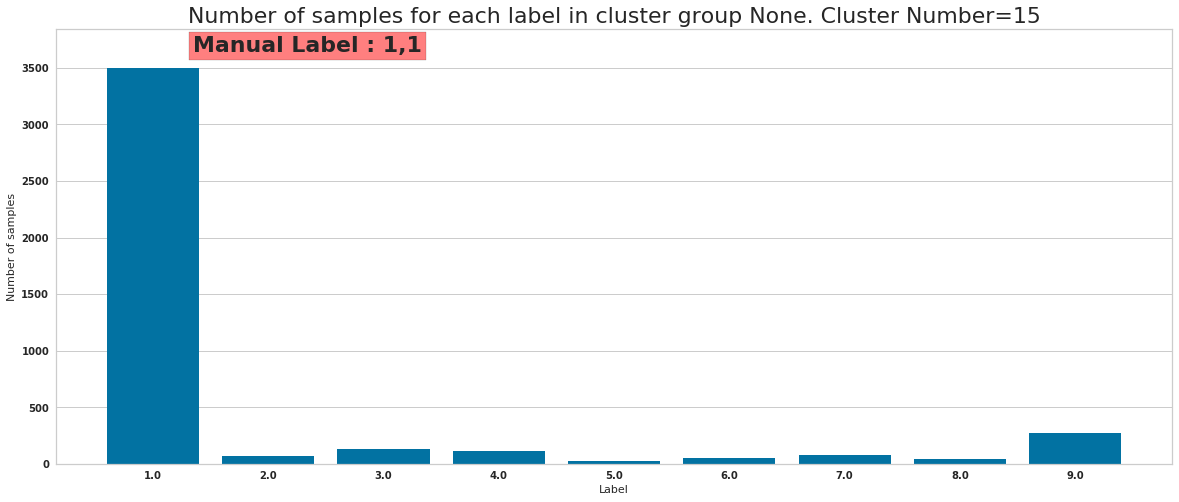

In [122]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [9,-1,1,6,
                                           7,0,9,8,
                                           6,3,8,3,
                                           0,2,8,1
                                          ]
manual_annotation_json["manual_confidence"] = [0.85,0,1,0.7,
                                               1,1,0.8,0.9,
                                               0.95,0.65,0.95,1,
                                               1,0.9,1,1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}"
                                   )




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


1
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-6545
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-6545
 [*] Success to read ClassifierModel.model-6545
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


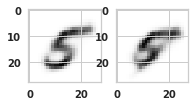

In [123]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []

cluster, _cluster_centers, _cluster_labels = cluster_next_level(df, processed_clusters)
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(df,
                                                                    [i[0] for i in processed_clusters])


In [124]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1,-1]
level_2_cluster_dict["manual_confidences"] = [0,0]
level2_manual_annotations[1] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [125]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)


1
2
Skipping distance computation for unknown cluster
Manual Label 9
(4878, 54) (4878, 32)
Num correct=2136
Cluster 0 Manual Label 9 Percentage correct 43.788437884378844
********************************
unknown
<class 'dict'>
['unknown_cluster']
********************************
Manual Label 1
(3259, 54) (3259, 32)
Num correct=2902
Cluster 2 Manual Label 1 Percentage correct 89.04571954587297
********************************
Manual Label 6
(2766, 54) (2766, 32)
Num correct=1440
Cluster 3 Manual Label 6 Percentage correct 52.060737527114966
********************************
Manual Label 7
(4614, 54) (4614, 32)
Num correct=4453
Cluster 4 Manual Label 7 Percentage correct 96.51061985262245
********************************
Manual Label 0
(3247, 54) (3247, 32)
Num correct=3056
Cluster 5 Manual Label 0 Percentage correct 94.11764705882354
********************************
Manual Label 9
(9998, 54) (5120, 32)
Num correct=4532
Cluster 6 Manual Label 9 Percentage correct 45.329065813162636
******

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is 

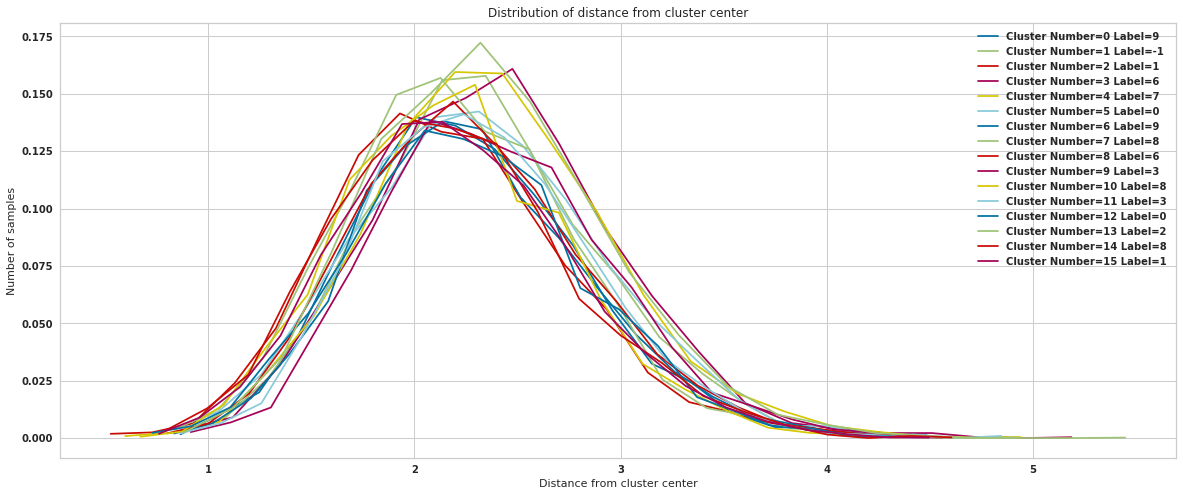

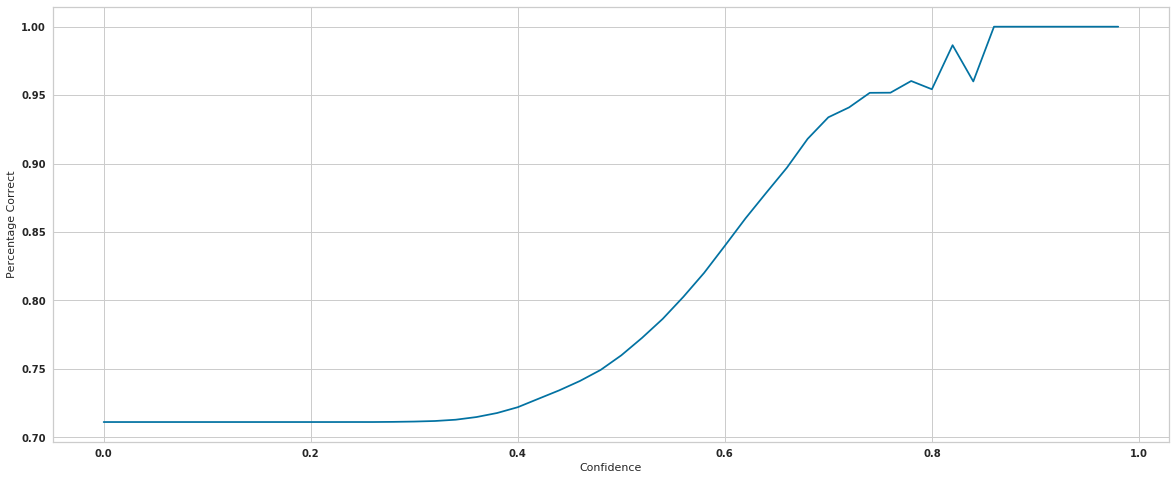

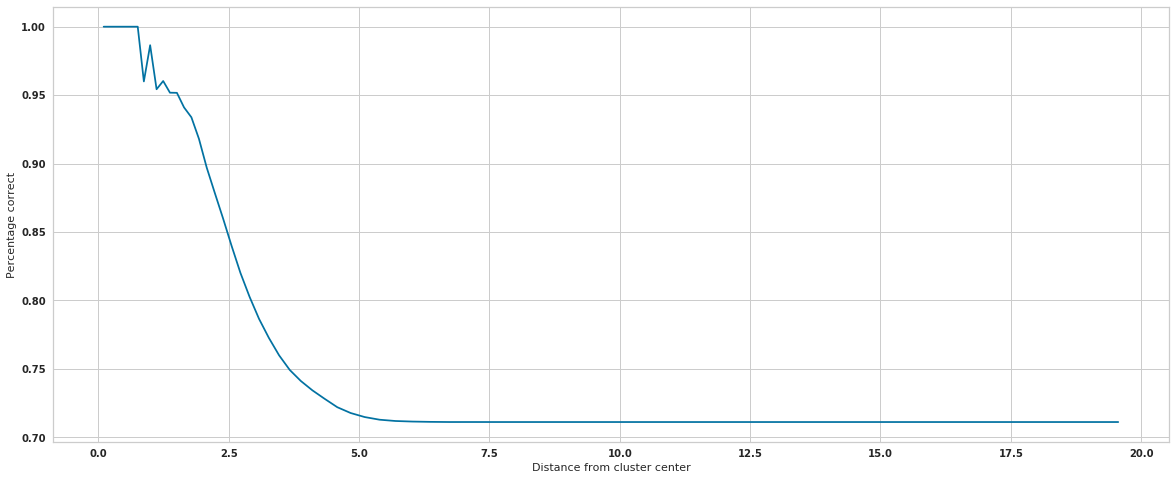

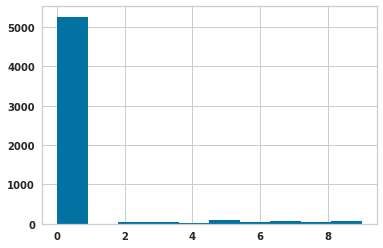

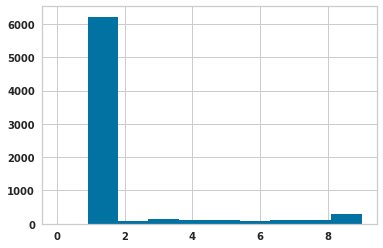

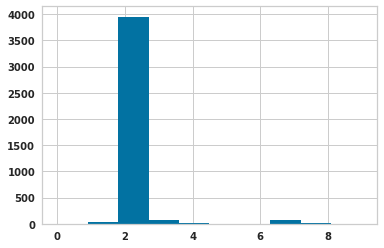

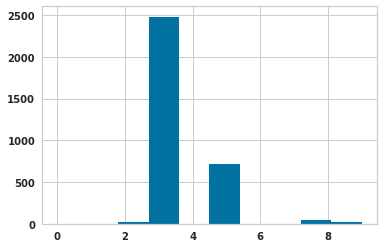

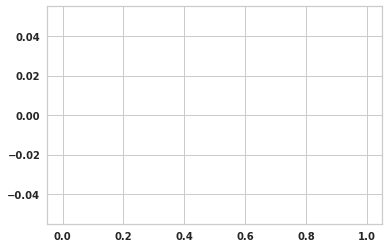

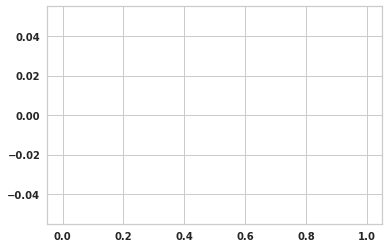

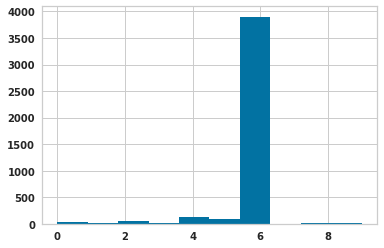

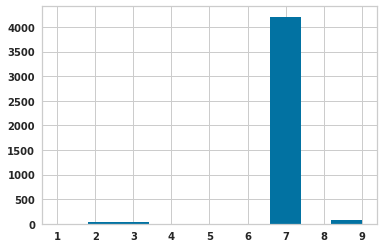

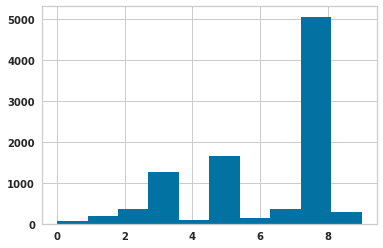

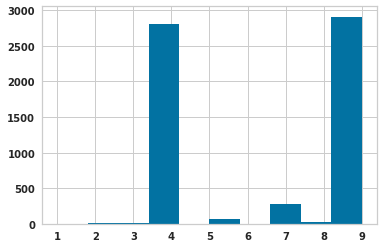

In [126]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution( list(range(num_clusters)))

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [127]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name,
                                        z_dim,
                                        run_id,
                                        create_split,
                                        num_epochs,
                                        num_cluster_config,
                                        manual_annotation_file)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32, 20], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'EVAL_INTERVAL': 300, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'RUN_ID': 2, 'ID': 1, 'name': 'VAE_MNIST', 'NUM_VALIDATION_SAMPLES': 128}
Loaded manual annotation
Number of samples with manual confidence 57217
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:07 and step:0300 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:7 step:300
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_07_0300/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:07 and step:0600 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:7 step:600
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_07_0600/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:07 and step:0900 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:7 step:900
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_07_0900/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed
Saving check point /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/
 [*] Training finished!
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-7480
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-7480
 [*] Success to read ClassifierModel.model-7480
 [*] Load SUCCESS
Number of steps completed=7480
Number of epochs completed 8.0
run_id=2 z_min=-4.4770355 z_max=4.1615150000000005
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergenc

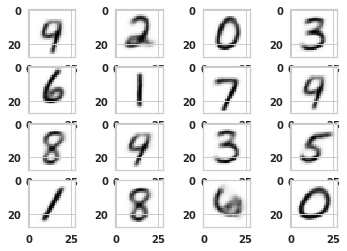

In [128]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


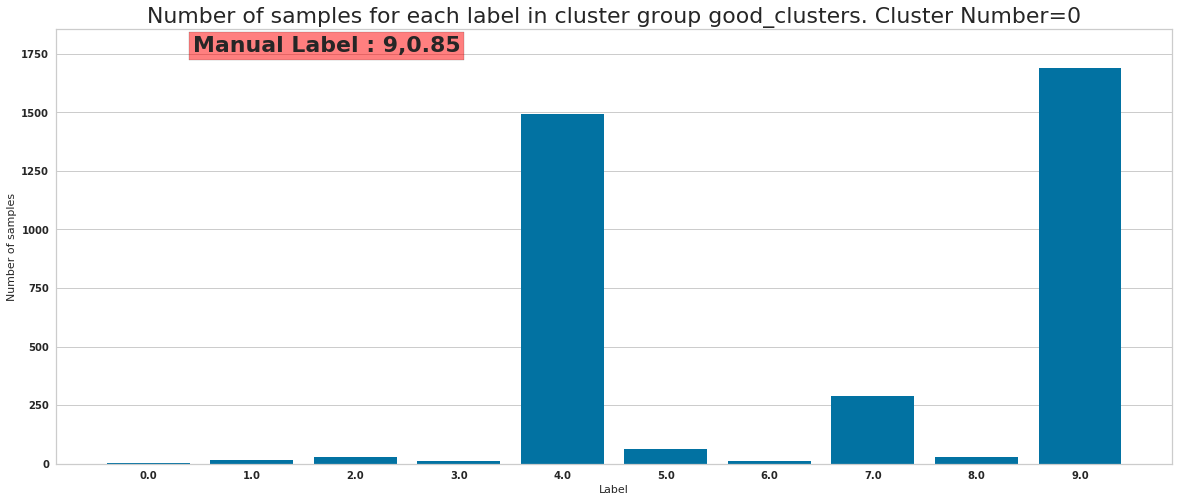

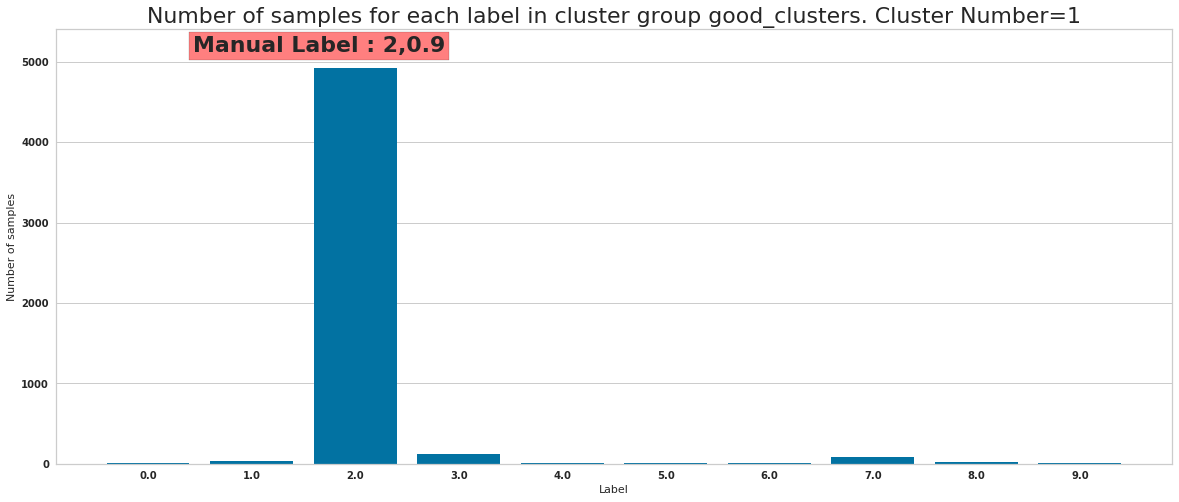

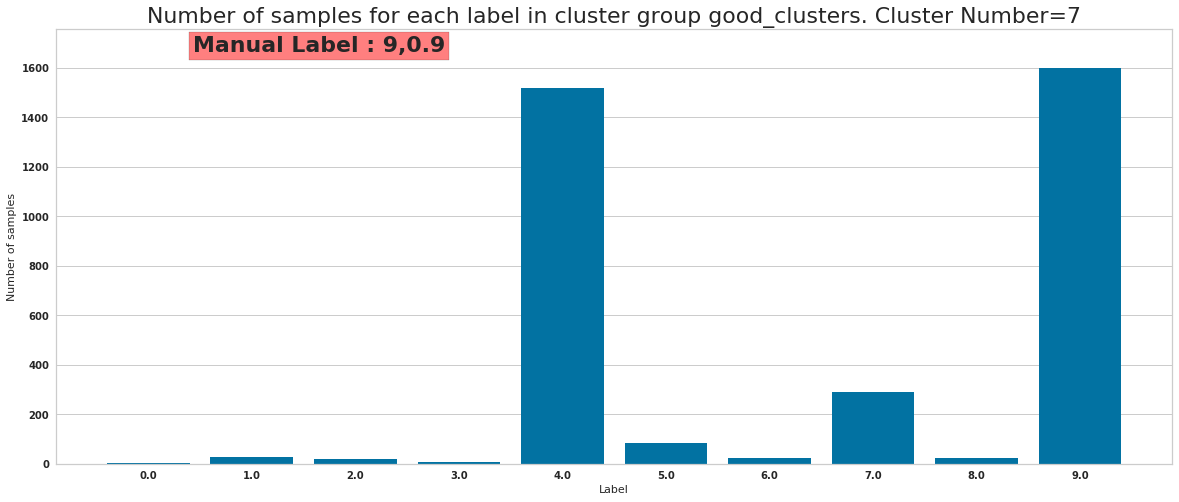

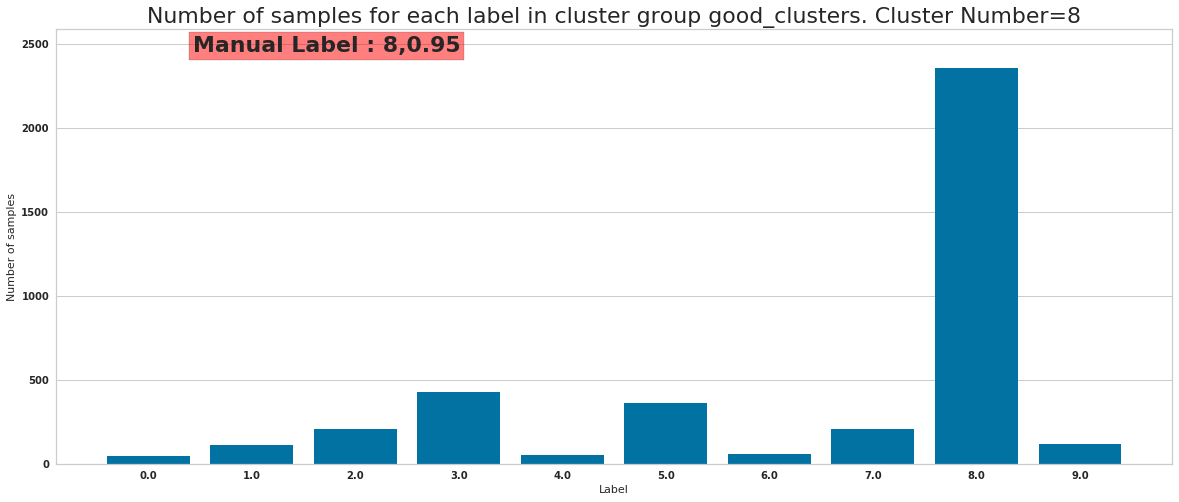

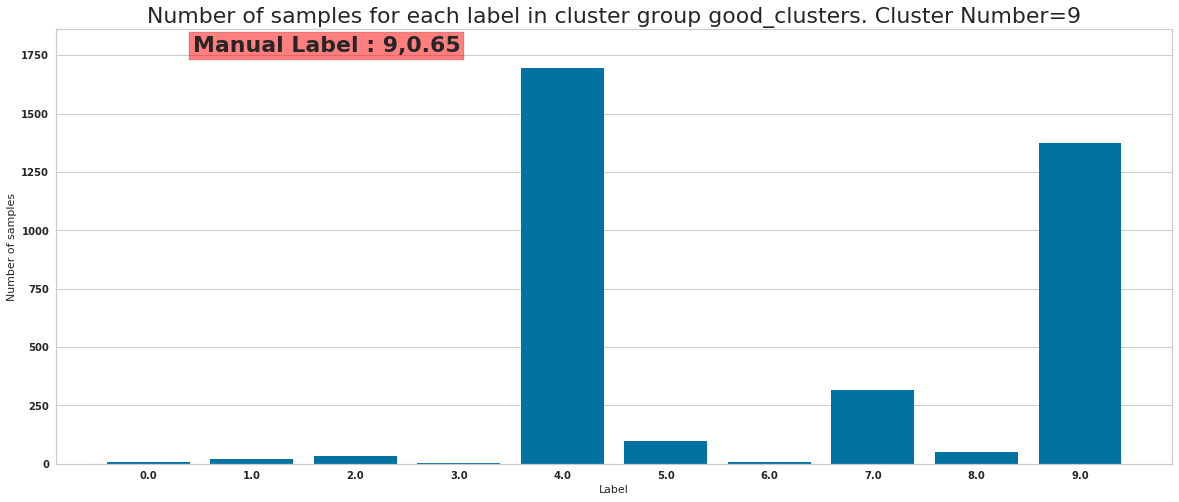

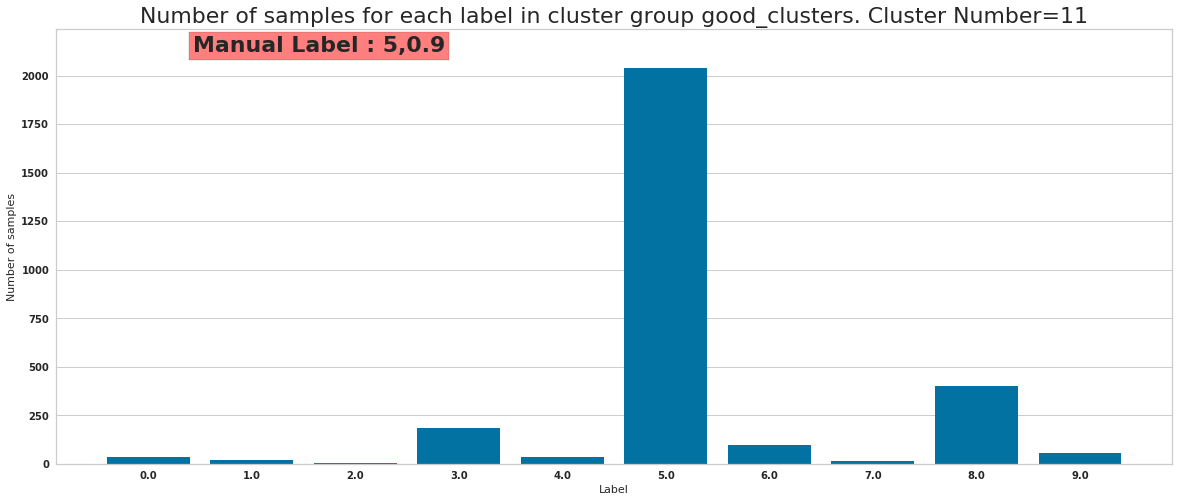

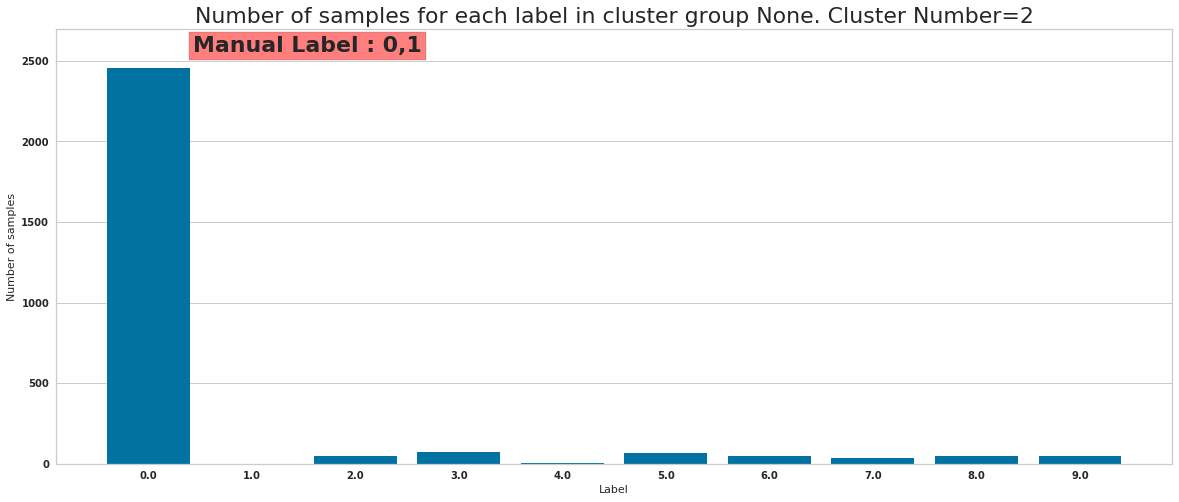

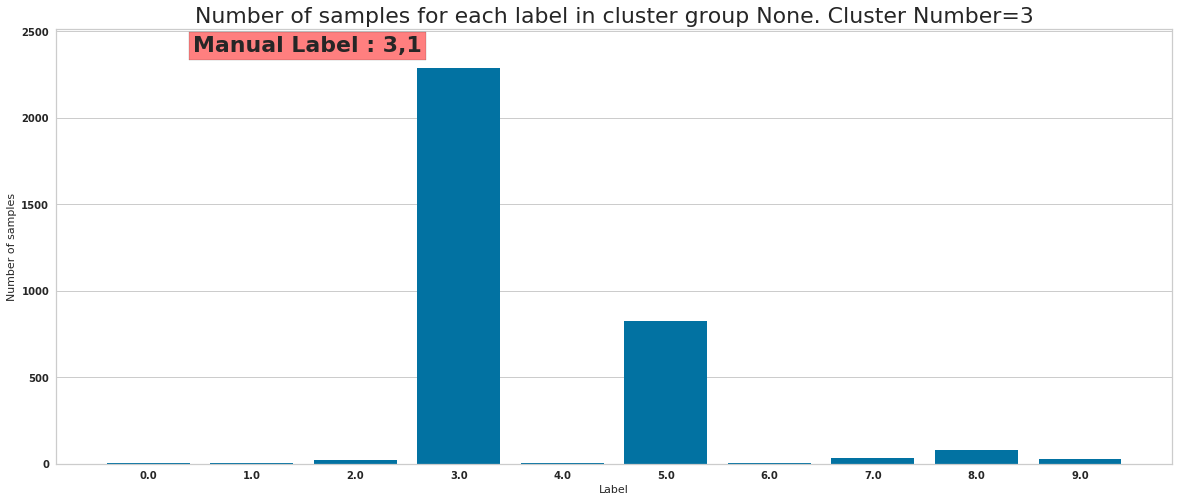

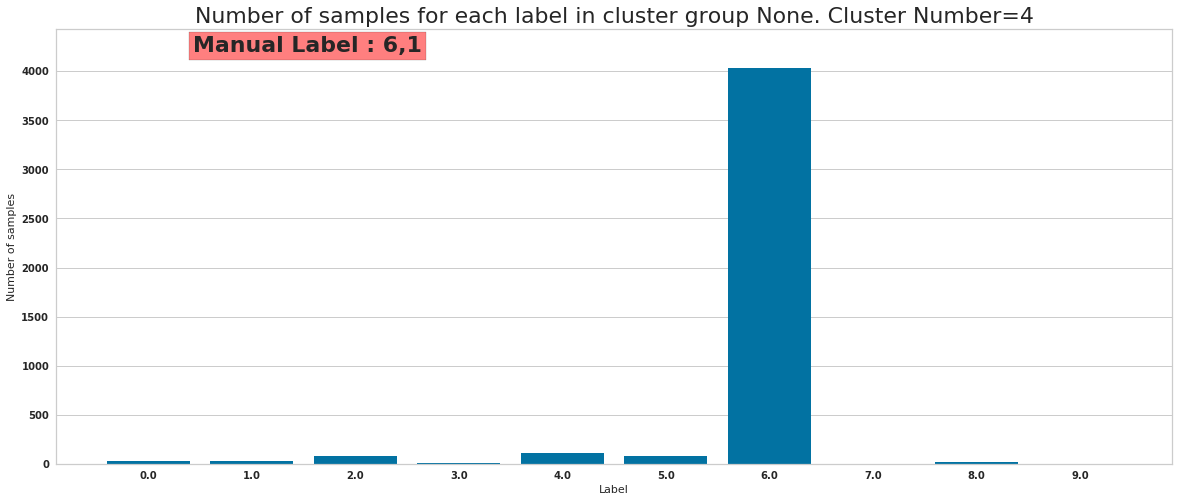

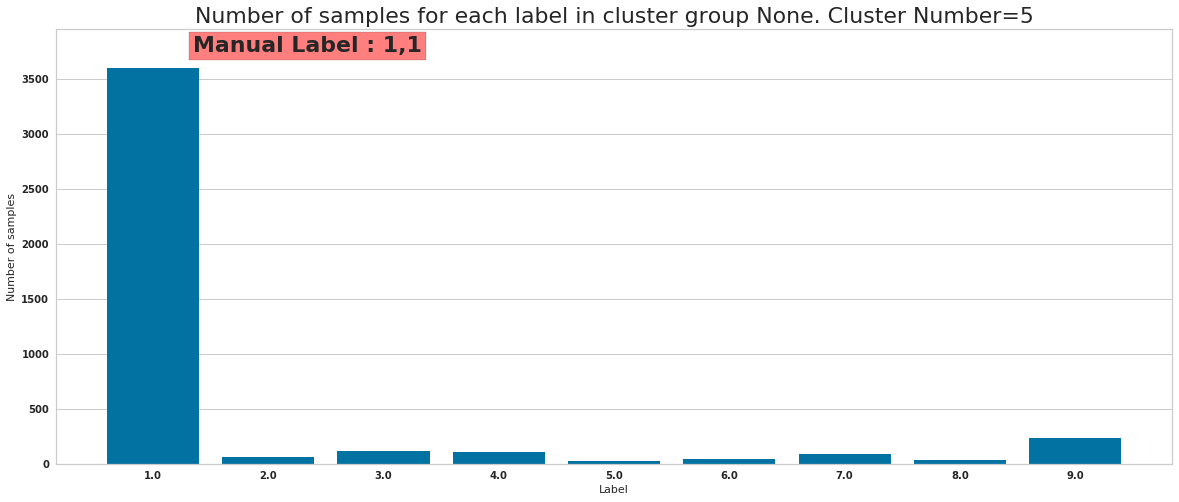

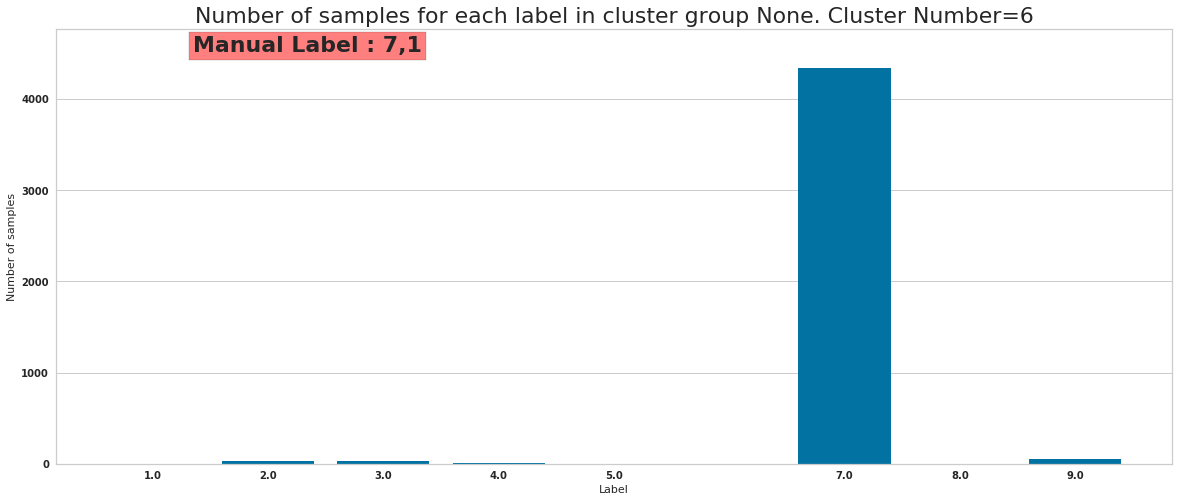

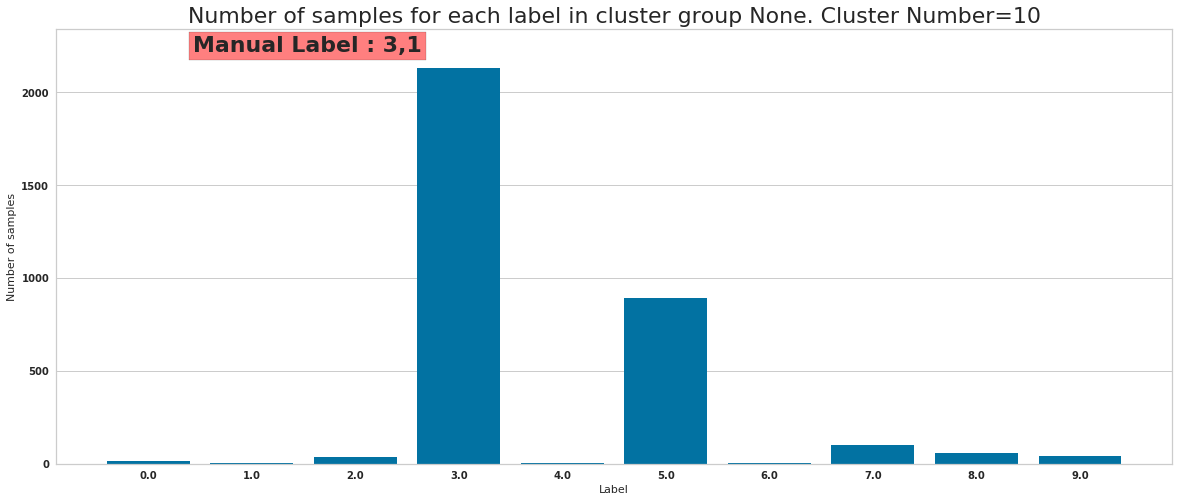

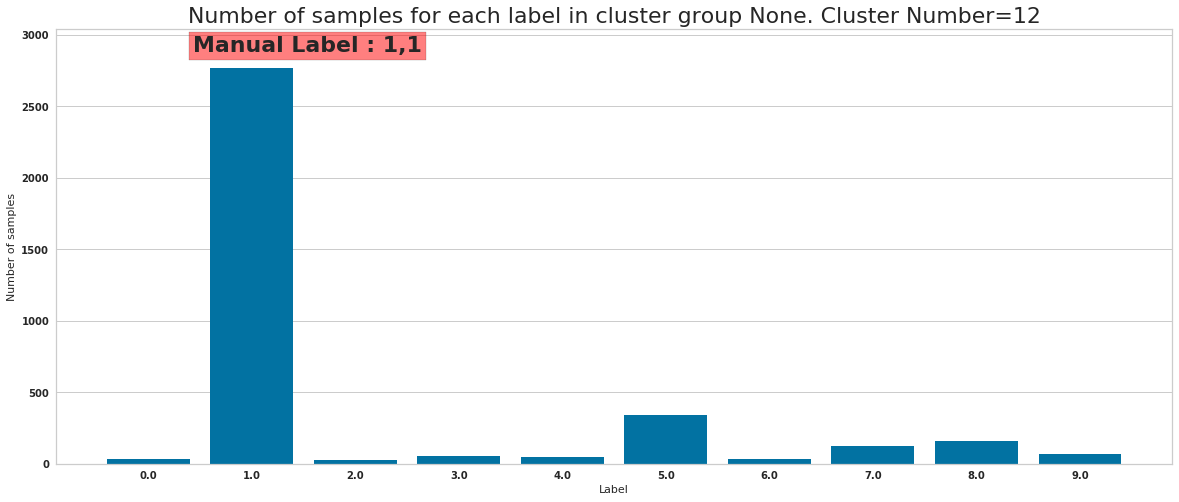

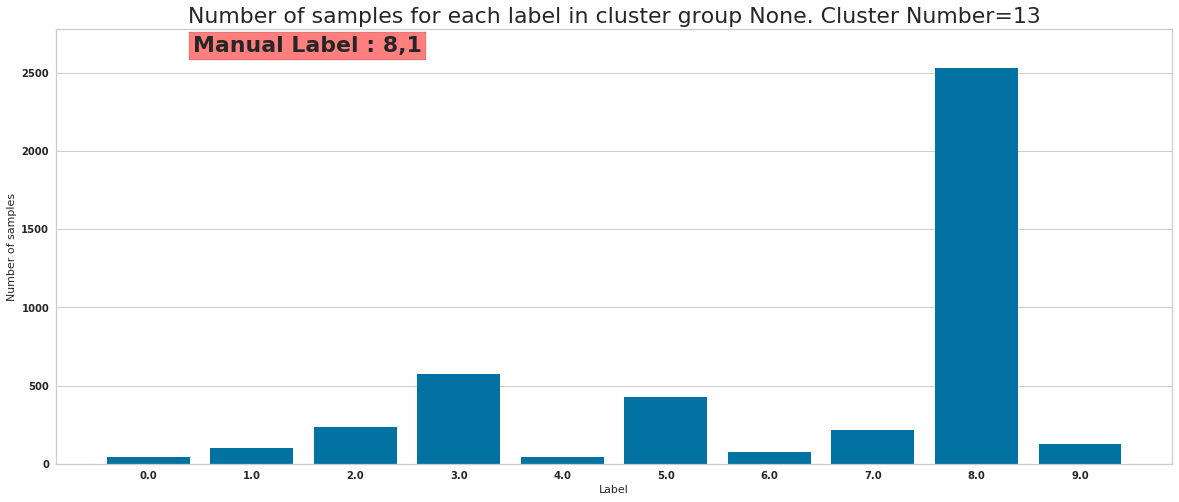

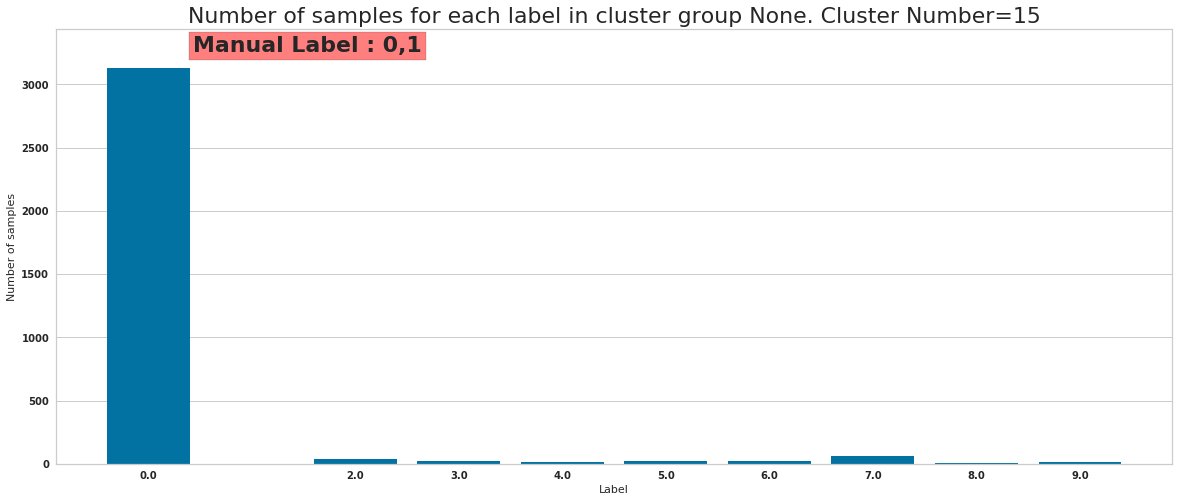

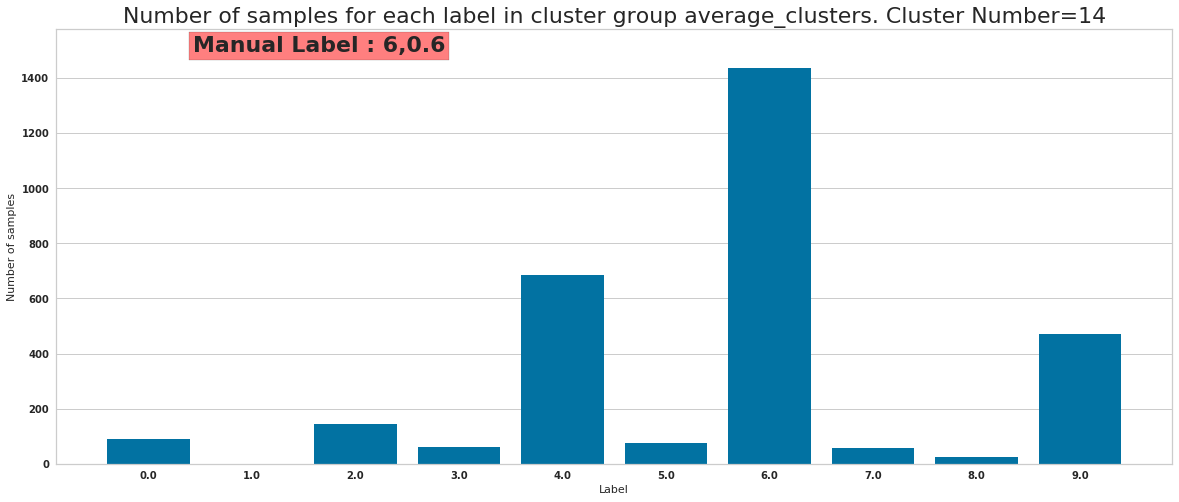

In [129]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [9,2,0,3,
                                           6,1,7,9,
                                           8,9,3,5,
                                           1,8,6,0
                                          ]
manual_annotation_json["manual_confidence"] = [0.85,0.9,1,1,
                                               1,1,1,0.9,
                                               0.95,0.65,1,0.9,
                                               1,1,0.6,1
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}"
                                   )




In [130]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []

cluster, _cluster_centers, _cluster_labels = cluster_next_level(df, processed_clusters)
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(df,
                                                                    [i[0] for i in processed_clusters])


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [131]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[1] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [132]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)


Manual Label 9
(3640, 52) (3640, 32)
Num correct=1687
Cluster 0 Manual Label 9 Percentage correct 46.34615384615385
********************************
Manual Label 2
(5220, 52) (5220, 32)
Num correct=4917
Cluster 1 Manual Label 2 Percentage correct 94.19540229885058
********************************
Manual Label 0
(2829, 52) (2829, 32)
Num correct=2452
Cluster 2 Manual Label 0 Percentage correct 86.67373630258042
********************************
Manual Label 3
(3291, 52) (3291, 32)
Num correct=2285
Cluster 3 Manual Label 3 Percentage correct 69.43178365238529
********************************
Manual Label 6
(4384, 52) (4384, 32)
Num correct=4028
Cluster 4 Manual Label 6 Percentage correct 91.87956204379562
********************************
Manual Label 1
(4299, 52) (4299, 32)
Num correct=3592
Cluster 5 Manual Label 1 Percentage correct 83.55431495696673
********************************
Manual Label 7
(4472, 52) (4472, 32)
Num correct=4336
Cluster 6 Manual Label 7 Percentage correct 96.95885

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is 

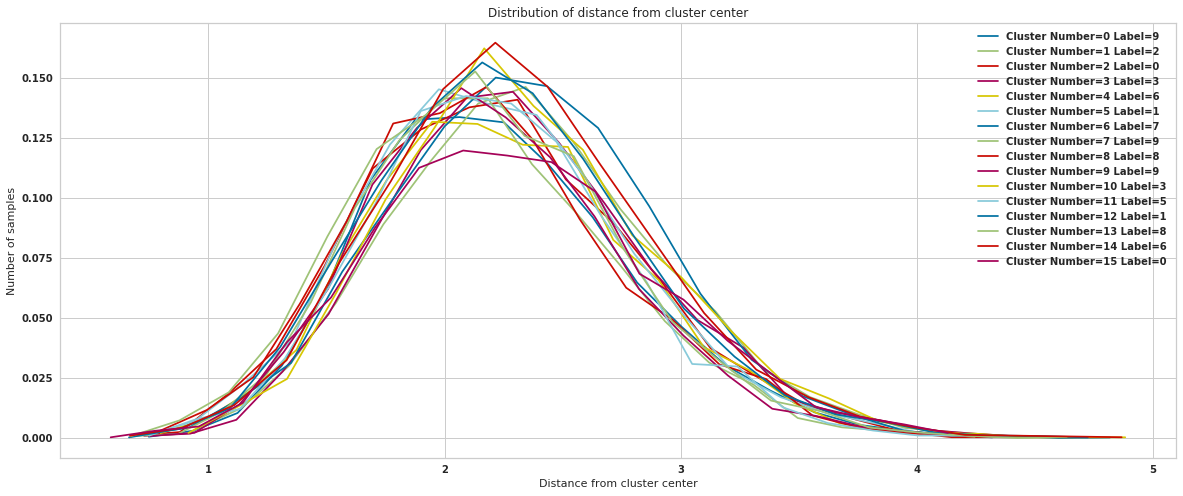

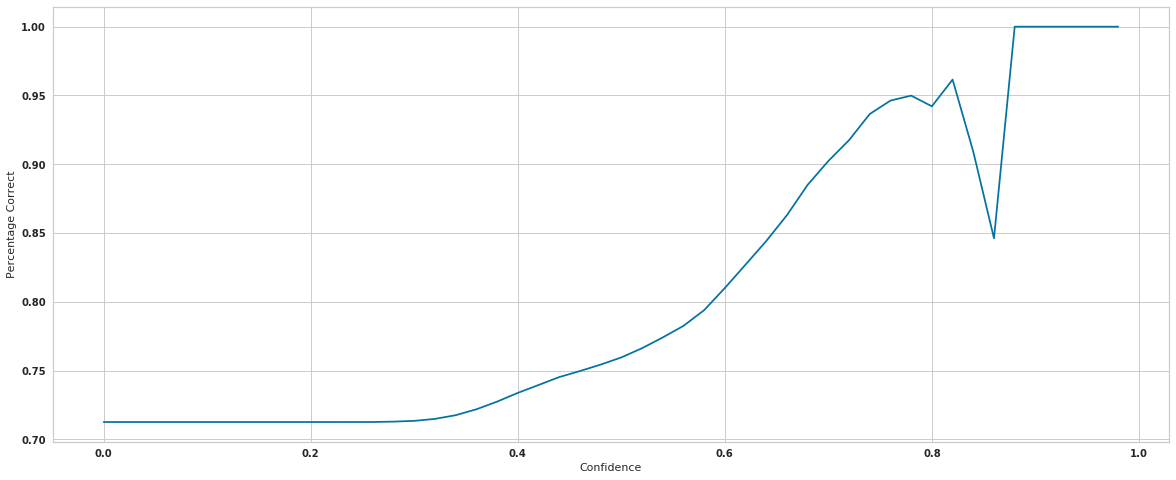

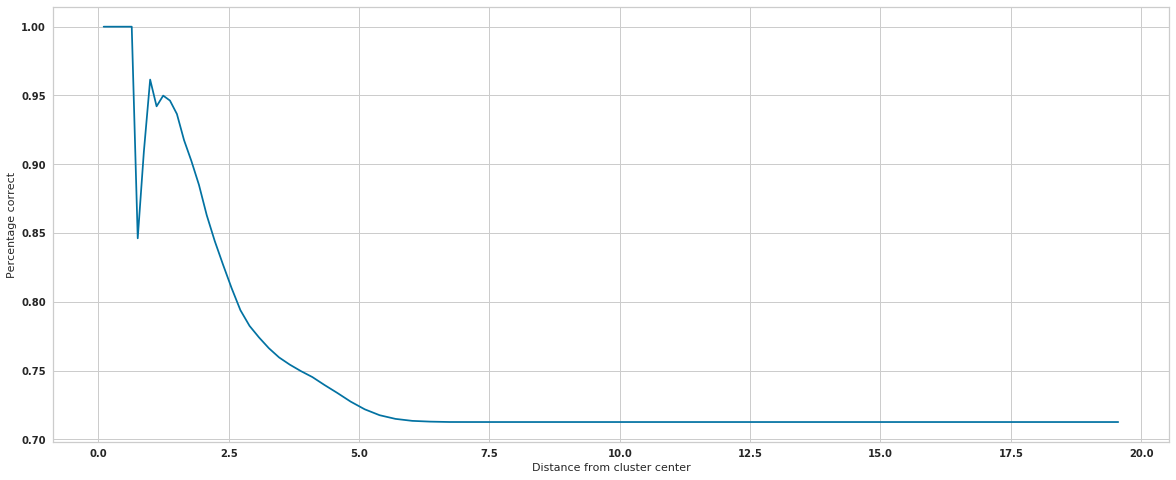

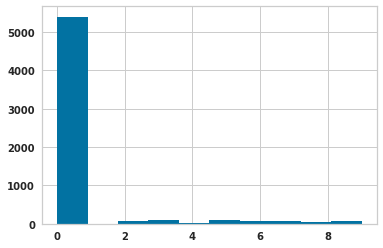

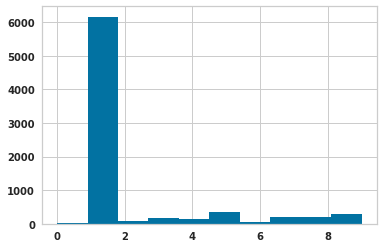

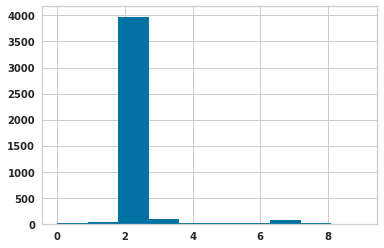

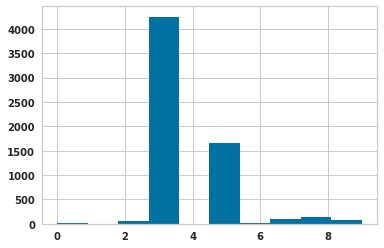

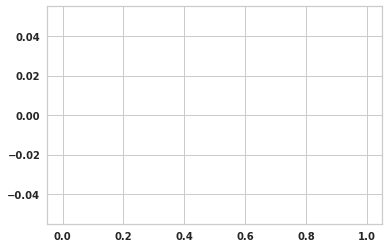

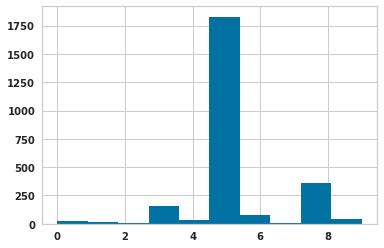

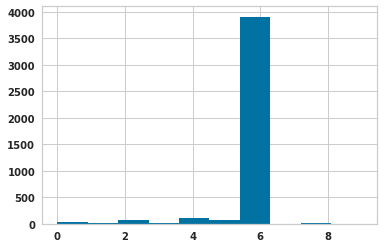

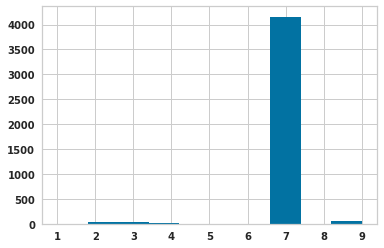

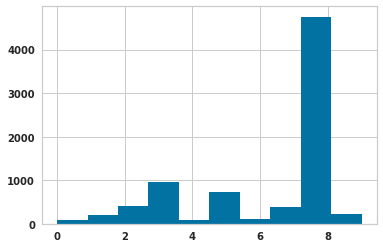

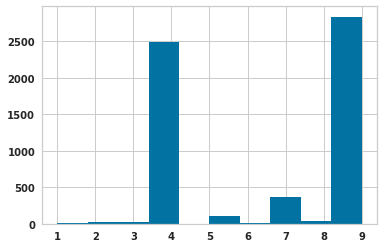

In [133]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution( list(range(num_clusters)))

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [134]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name,
                                        z_dim,
                                        run_id,
                                        create_split,
                                        num_epochs,
                                        num_cluster_config,
                                        manual_annotation_file)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32, 20], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'EVAL_INTERVAL': 300, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'RUN_ID': 2, 'ID': 1, 'name': 'VAE_MNIST', 'NUM_VALIDATION_SAMPLES': 128}
Loaded manual annotation
Number of samples with manual confidence 59840
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Running evaluation after epoch:08 and step:0300 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:8 step:300
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_08_0300/
(64, 28, 28, 1)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:08 and step:0600 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:8 step:600
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_08_0600/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:08 and step:0900 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:8 step:900
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_08_0900/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed
Saving check point /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/
 [*] Training finished!
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/


INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-8415
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-8415
 [*] Success to read ClassifierModel.model-8415
 [*] Load SUCCESS
Number of steps completed=8415
Number of epochs completed 9.0
run_id=2 z_min=-4.340634 z_max=4.580414
Latent vectors shape (59840, 10)
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.


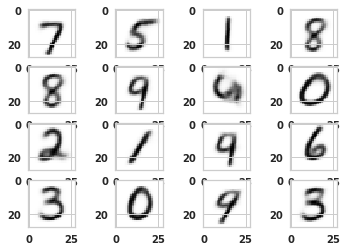

In [135]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

Getting manual_annotation


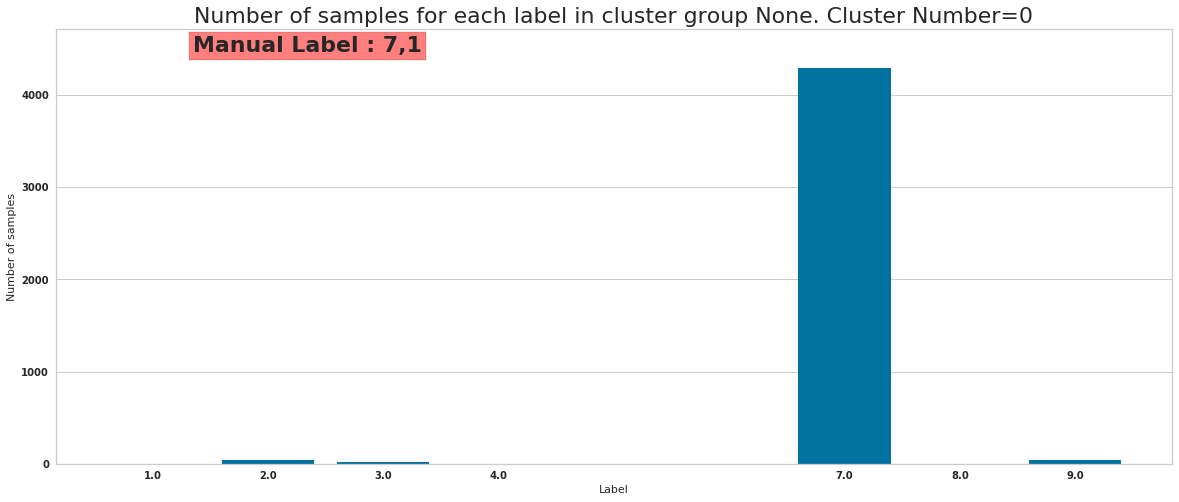

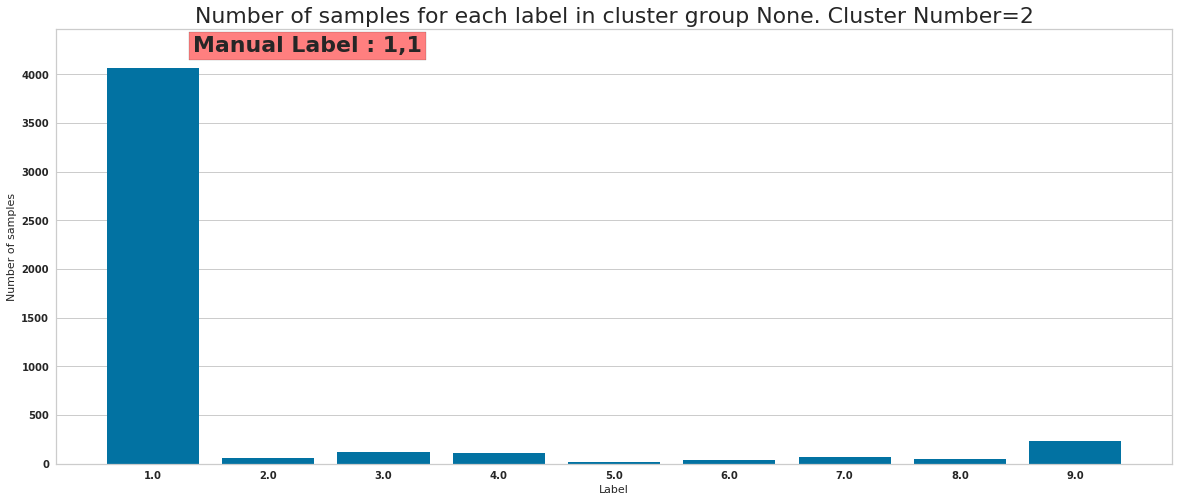

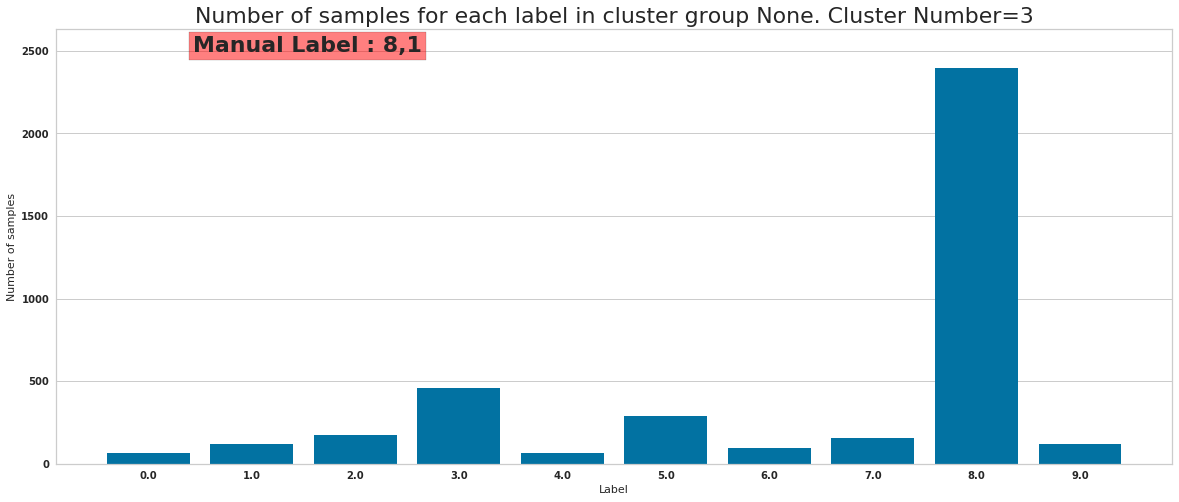

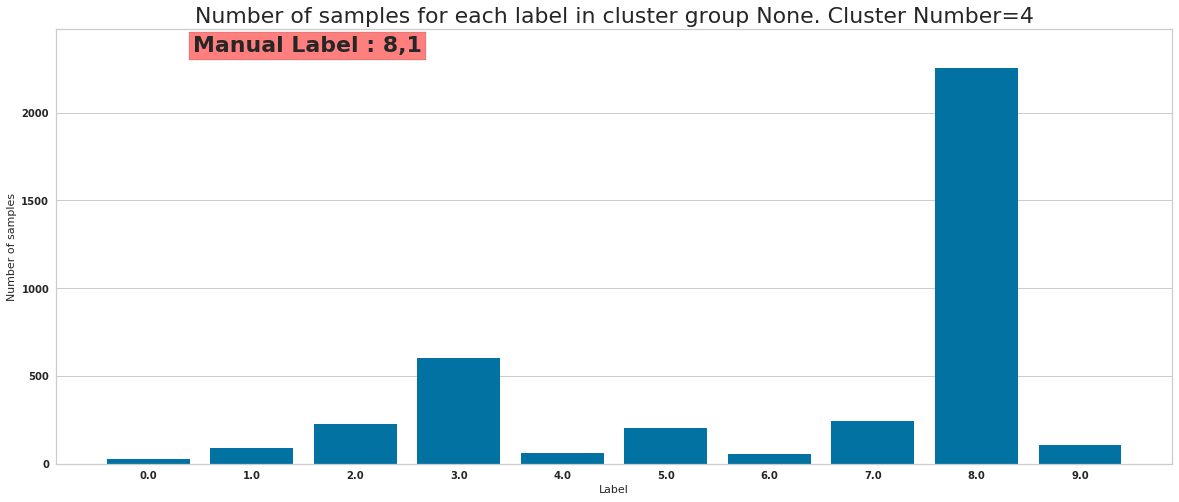

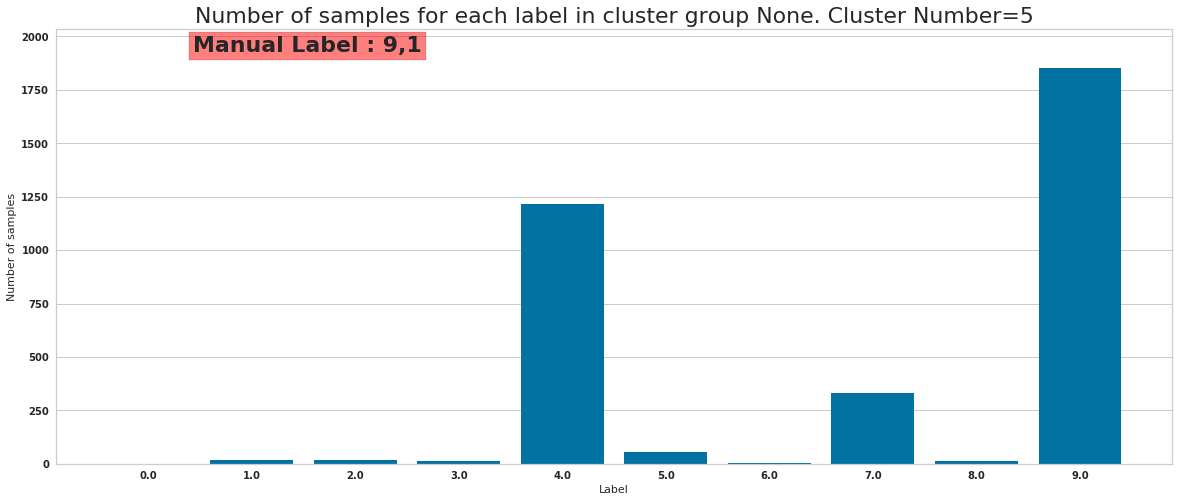

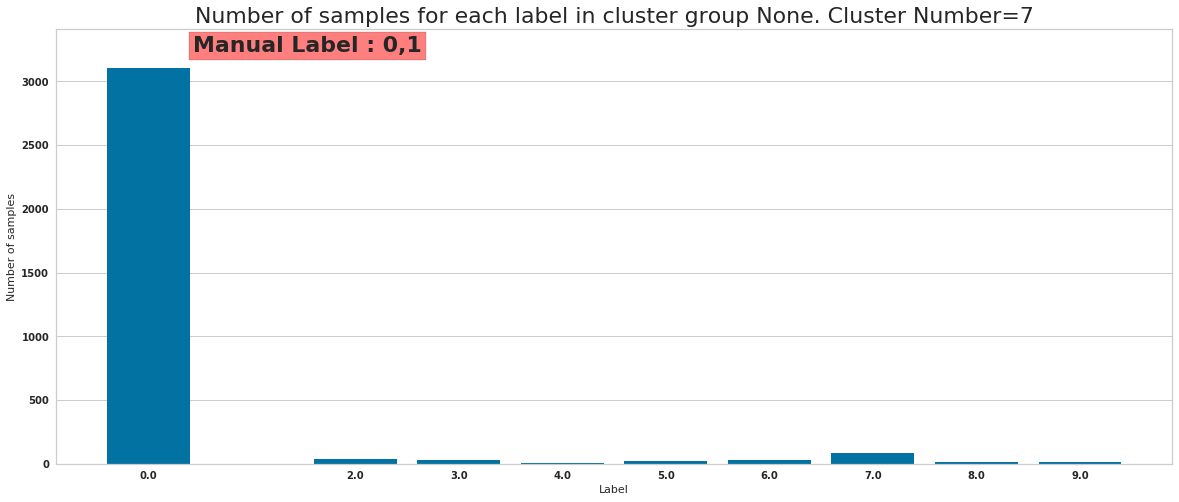

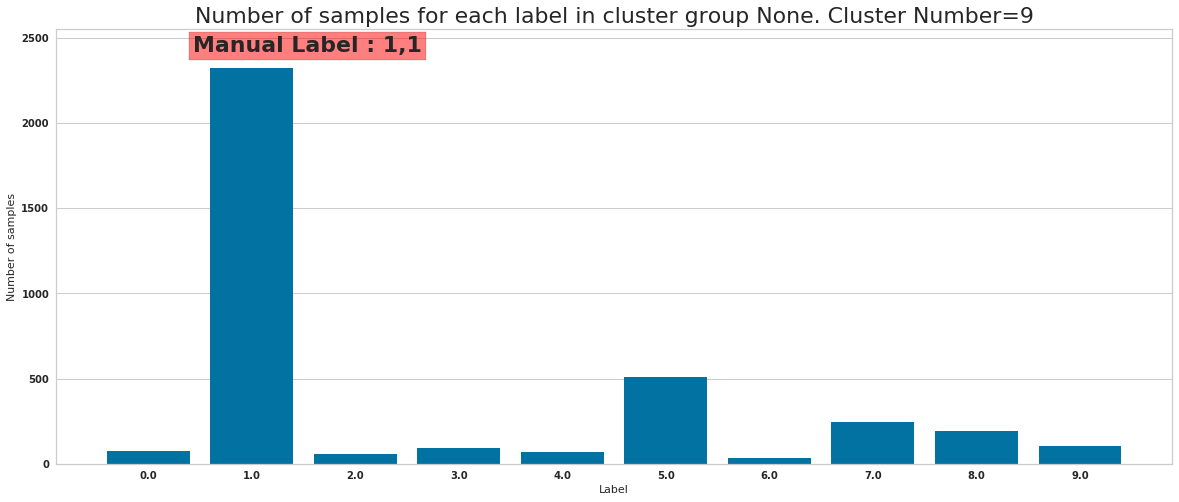

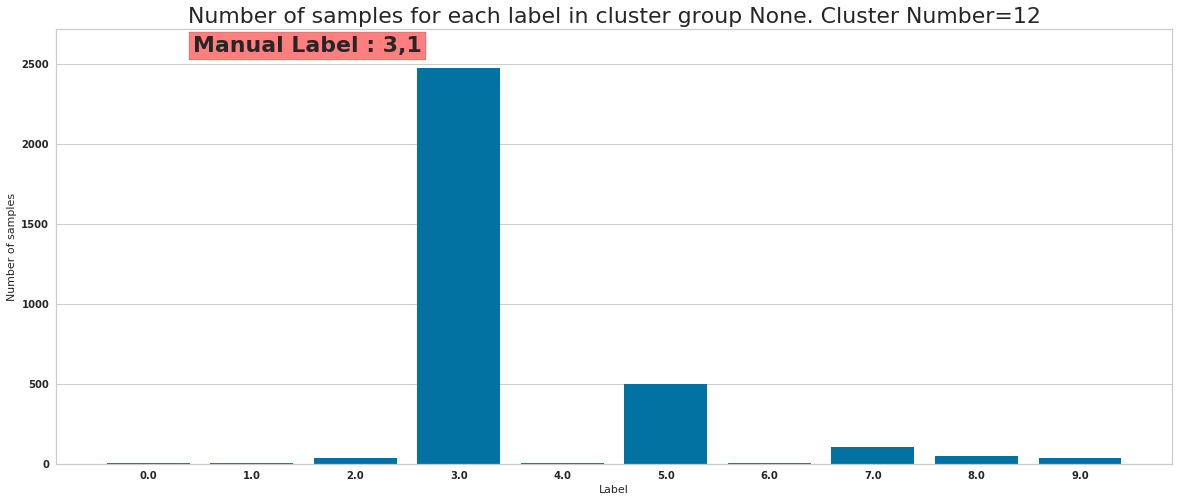

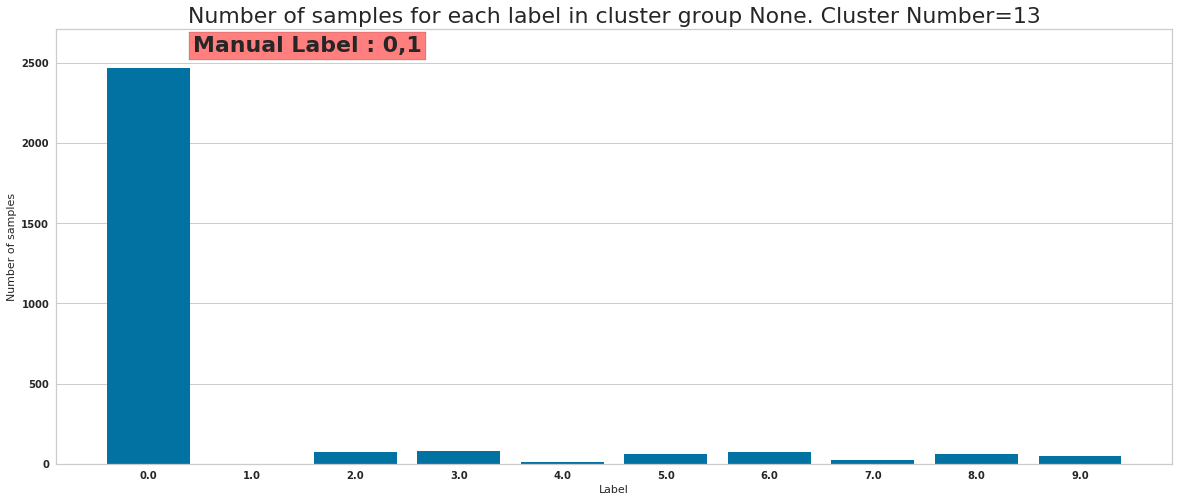

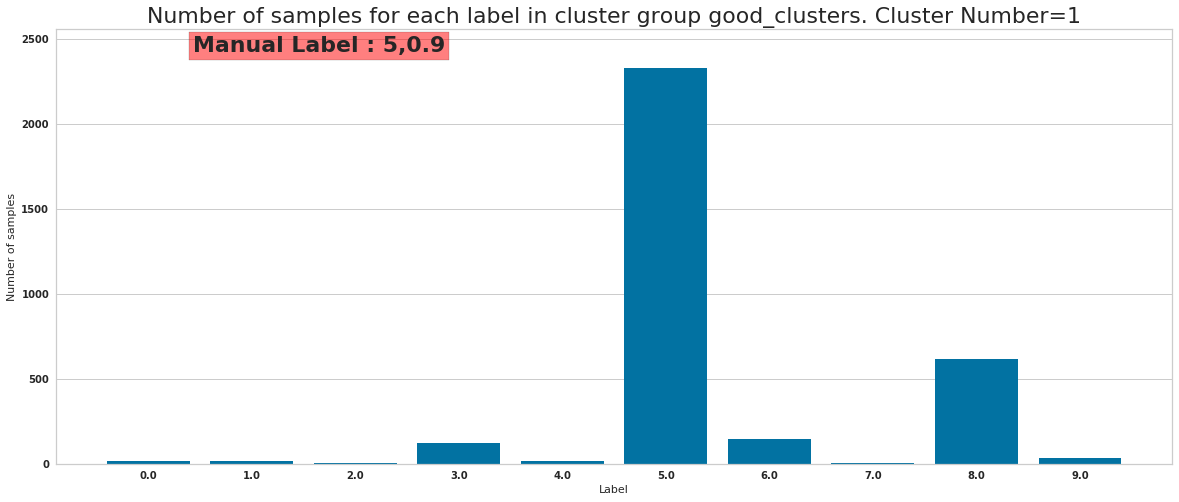

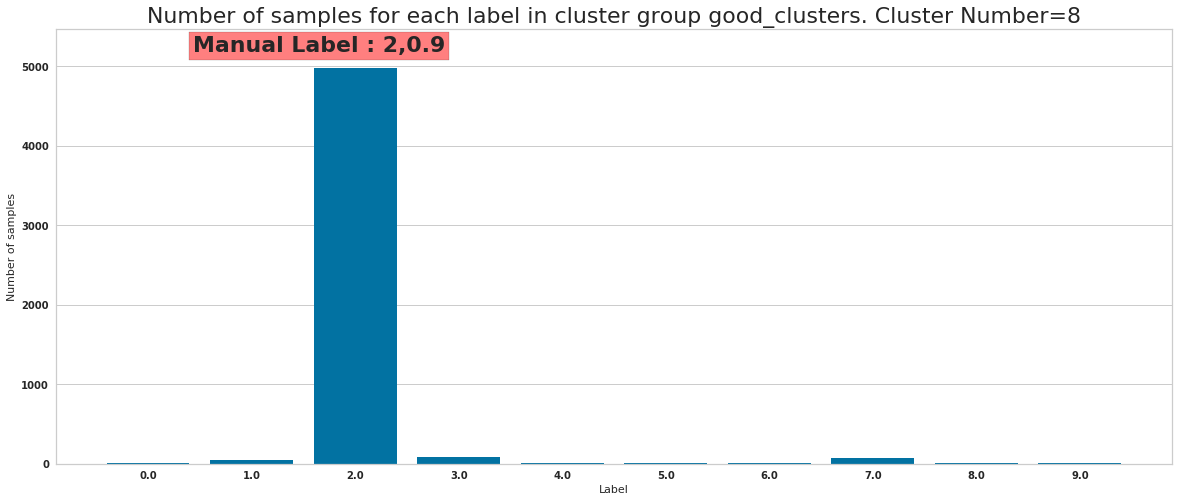

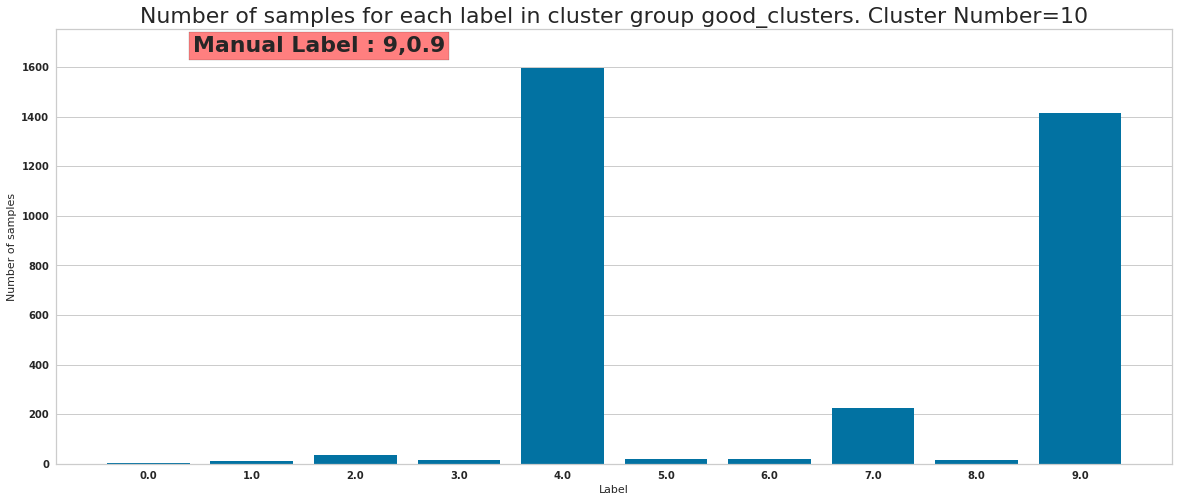

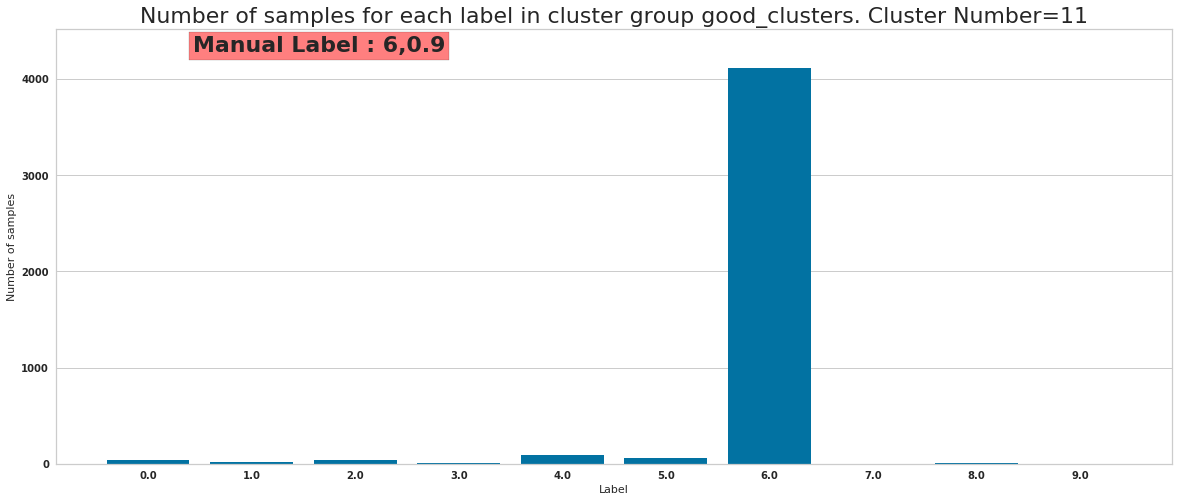

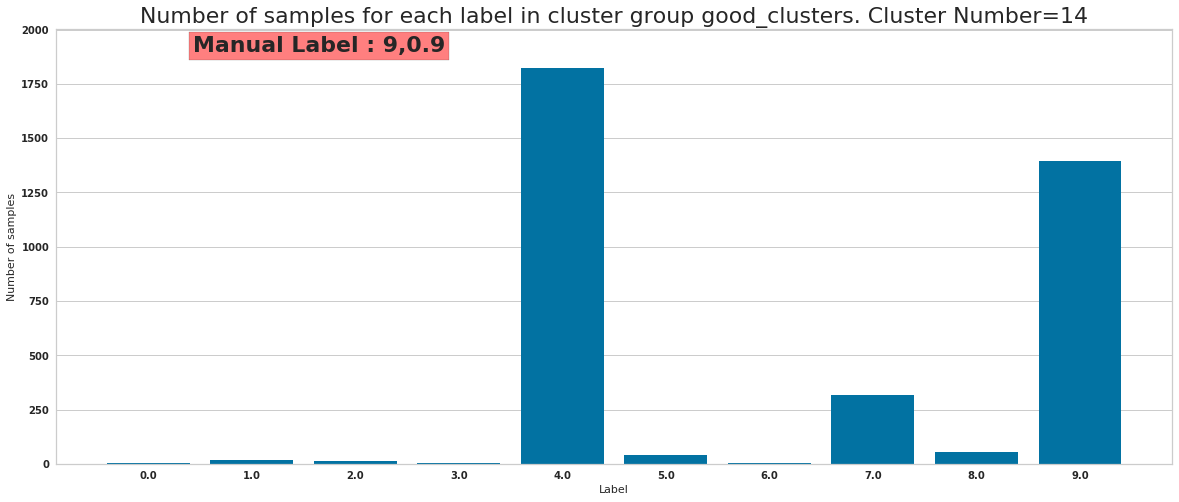

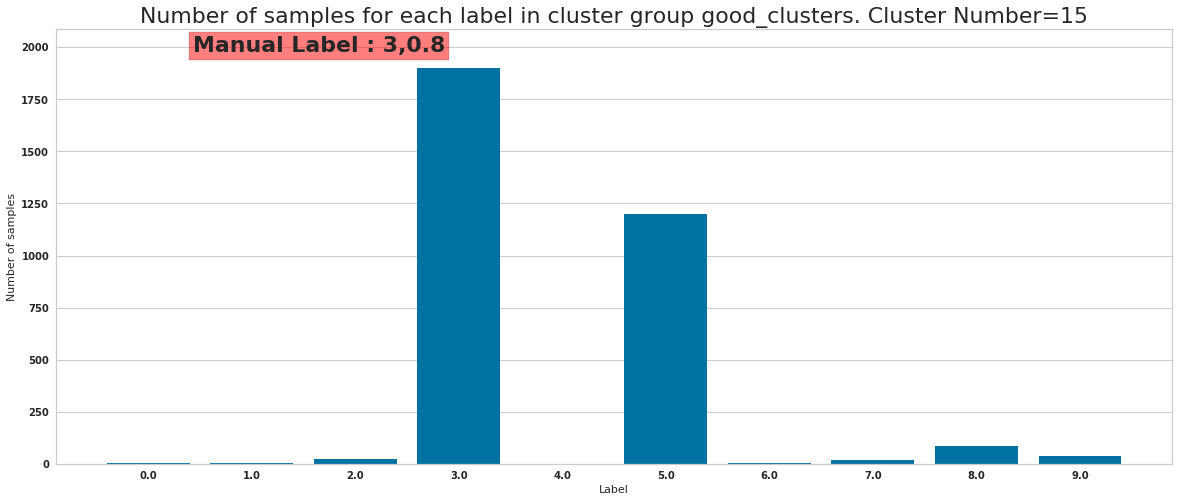

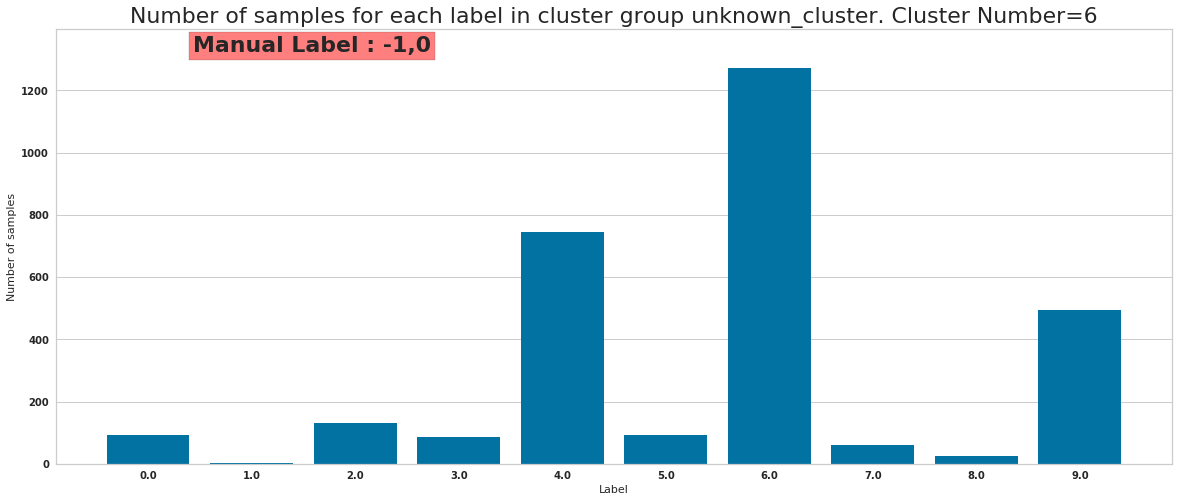

In [136]:
#TODO get the input from console or a gui app. For now edit the values directly here
print("Getting manual_annotation")
manual_annotation_json = dict()
manual_annotation_json["manual_labels"] = [7,5,1,8,
                                           8,9,-1,0,
                                           2,1,9,6,
                                           3,0,9,3
                                          ]
manual_annotation_json["manual_confidence"] = [1,0.9,1,1,
                                               1,1,0,1,
                                               0.9,1,0.9,0.9,
                                               1,1,0.9,0.8
                                              ]

manual_annotation_json["cluster_centers"] = cluster_centers.tolist()
manual_annotation_json["cluster_labels"] = cluster_labels.tolist()
with open(manual_annotation_file_json, "w") as json_file:
    json.dump(manual_annotation_json, json_file)
    
manual_labels = manual_annotation_json["manual_labels"]
manual_confidence = manual_annotation_json["manual_confidence"]
df[cluster_column_name] = cluster_labels

cluster_group_dict = get_cluster_groups( manual_labels,
                                        manual_confidence,
                                        cluster_column_name,
                                        cluster_centers,
                                        cluster_labels,
                                        df)
for cluster_group_name, cluster_group in cluster_group_dict.items():
    plot_number_of_samples_vs_label(cluster_group,
                                    "Number of samples for each label in cluster group {}. Cluster Number={}"
                                   )




/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


6
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading checkpoints...
ckpt_name ClassifierModel.model-8415
INFO:tensorflow:Restoring parameters from /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/ClassifierModel.model-8415
 [*] Success to read ClassifierModel.model-8415
 [*] Load SUCCESS


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


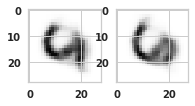

In [137]:
for i in range(num_clusters):
    df["distance_{}".format(i)] = 100000
for cluster_num in range(num_clusters):
    #indices = df[cluster_column_name] == cluster_num
    indices = np.where( np.asarray(cluster_labels) == cluster_num)[0]
    #indices = np.where(cluster_labels == i)[0]
    df["distance_{}".format(cluster_num)].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                   cluster_centers[cluster_num],
                                                                                                   z_col_names),
                                                                                 axis=1)
df[cluster_column_name_2] = -1
processed_clusters = []

cluster, _cluster_centers, _cluster_labels = cluster_next_level(df, processed_clusters)
while cluster is not None:
    processed_clusters.append([cluster.id, _cluster_centers, _cluster_labels])
    cluster, _cluster_centers, _cluster_labels = cluster_next_level(df,
                                                                    [i[0] for i in processed_clusters])


In [138]:
level2_manual_annotations =dict()

#TODO do this for all unknown clusters
level_2_cluster_dict = dict()
level_2_cluster_dict["manual_labels"] = [-1,-1]
level_2_cluster_dict["manual_confidences"] = [0,0]
level2_manual_annotations[6] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1,-1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[8] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0,0]
# level2_manual_annotations[9] = level_2_cluster_dict

# level_2_cluster_dict = dict()
# level_2_cluster_dict["manual_labels"] = [-1, -1]
# level_2_cluster_dict["manual_confidences"] = [0, 0]
# level2_manual_annotations[13] = level_2_cluster_dict



In [139]:
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    print(cluster_id)
    level_2_cluster_dict = level2_manual_annotations[cluster_id]
    _indices =np.where( cluster_labels == cluster_id)
    cluster_level_2_group_dict    = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
#compute distance from cluster center
for processed_cluster in processed_clusters:
    cluster_id, _cluster_centers, _cluster_labels = processed_cluster[0], processed_cluster[1], processed_cluster[2]
    _, cluster = get_cluster(cluster_id, cluster_group_dict)
    num_level_2_clusters = cluster.next_lever_cluster_count()
    print(num_level_2_clusters)
    for i in range(num_level_2_clusters):
        df[f"distance_level_2_{cluster.id}_{i}"] = 100000
    for cluster_group_label, level_2_cluster_group in cluster.next_level_clusters.items():
        if cluster_group_label == "unknown_cluster":
            print("Skipping distance computation for unknown cluster")
            continue
        for level_2_cluster in level_2_cluster_group:
            indices = np.where((np.asarray(cluster_labels) == cluster.id) &
                               (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)

#df[cluster_column_name_2] = -1
impure_cluster = None
if "impure_cluster" in cluster_group_dict.keys():
    for cluster in cluster_group_dict["impure_cluster"]:
        print(cluster.id)
        _indices =np.where( cluster_labels == cluster.id)
        _df = df.iloc[_indices]
        _latent_vectors = _df[z_col_names].values
        _decoded_images, _cluster_centers, _cluster_labels = cluster_and_decode_latent_vectors(4,
                                                                                            _latent_vectors,
                                                                                            exp_config)
        df[cluster_column_name_2].iloc[_indices] = _cluster_labels
        image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers__level_2_epoch_{epochs_completed}.png"

        display_cluster_center_images(_decoded_images, image_filename, _cluster_centers)

        print(_df.iloc[_cluster_labels == 1].shape)
        print(_df.iloc[_cluster_labels == 0].shape)
        impure_cluster = cluster
        
level_2_cluster_dict = dict()
if "impure_cluster" in cluster_group_dict.keys():
    cluster_level_2_group_dict = get_cluster_groups(level_2_cluster_dict["manual_labels"],
                                                    level_2_cluster_dict["manual_confidences"],
                                                    "cluster_level_2",
                                                    _cluster_centers,
                                                    _cluster_labels,
                                                    df,
                                                    _indices
                                                   )
    impure_cluster.set_next_level_clusters(cluster_level_2_group_dict)
    
if "impure_cluster" in cluster_group_dict.keys():

    for cluster in cluster_group_dict["impure_cluster"]:
        num_level_2_clusters = cluster.next_lever_cluster_count()
        print(num_level_2_clusters)
        for i in range(num_level_2_clusters):
            df[f"distance_level_2_{cluster.id}_{i}"] = 100000
        for level_2_cluster in cluster.next_level_clusters["good_clusters"]:
            #print(level_2_cluster.id)
            indices = np.where((np.asarray(cluster_labels) == cluster.id) & (df[cluster_column_name_2].values == level_2_cluster.id) )[0]
            #level_2_indices = np.where(level_2_cluster.details["cluster_labels"] == level_2_cluster.id )
            cluster_centers_level_2 = level_2_cluster.details["cluster_centers"]
            print(level_2_cluster.id, indices.shape)
            df[f"distance_level_2_{cluster.id}_{level_2_cluster.id}"].iloc[indices] = df.iloc[indices].apply(lambda x:distance(x,
                                                                                                                               cluster_centers_level_2,
                                                                                                                               z_col_names),
                                                                                                             axis=1)


assign_manual_label_and_confidence(df,
                                   manual_annotation_json,
                                   convert_distance_to_confidence,
                                   cluster_group_dict,
                                   cluster_column_name_2)

df.to_csv(exp_config.ANALYSIS_PATH + "z_train_cluster_dist_{}_{}_{}_{}.csv".format(num_units[1], num_units[2], z_dim, epochs_completed), index=False)
import json
with open(exp_config.ANALYSIS_PATH + "cluster_centers_{}_{}_{}_{}.json".format(num_units[1], num_units[2], z_dim, epochs_completed),"w") as json_file:
          json.dump(cluster_centers.tolist(), json_file)
        
manual_annotation_file = os.path.join(exp_config.ANALYSIS_PATH,
                                      "manual_annotation_epoch_{}.csv".format(epochs_completed )
                                     )
if os.path.isfile(manual_annotation_file):
    # TODO change print to logging x
    print("Warning:{} already exists. Backing upt the file to ", manual_annotation_file + ".backup" )
    copy2(manual_annotation_file, manual_annotation_file + ".backup")
else:
    df[["manual_annotation", "manual_annotation_confidence"]].to_csv(manual_annotation_file, index=False)


6
2
Skipping distance computation for unknown cluster
Manual Label 7
(4396, 54) (4396, 32)
Num correct=4285
Cluster 0 Manual Label 7 Percentage correct 97.47497725204731
********************************
Manual Label 5
(3305, 54) (3305, 32)
Num correct=2327
Cluster 1 Manual Label 5 Percentage correct 70.40847201210288
********************************
Manual Label 1
(4762, 54) (4762, 32)
Num correct=4061
Cluster 2 Manual Label 1 Percentage correct 85.27929441411172
********************************
Manual Label 8
(3938, 54) (3938, 32)
Num correct=2393
Cluster 3 Manual Label 8 Percentage correct 60.76688674454038
********************************
Manual Label 8
(7812, 54) (3874, 32)
Num correct=4645
Cluster 4 Manual Label 8 Percentage correct 59.459805427547366
********************************
Manual Label 9
(3523, 54) (3523, 32)
Num correct=1850
Cluster 5 Manual Label 9 Percentage correct 52.512063582174285
********************************
unknown
<class 'dict'>
['unknown_cluster']
*******

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is deprecated, and has no effect. Consider passing the density argument instead.
  # This is added back by InteractiveShellApp.init_path()
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Passing normed=False is 

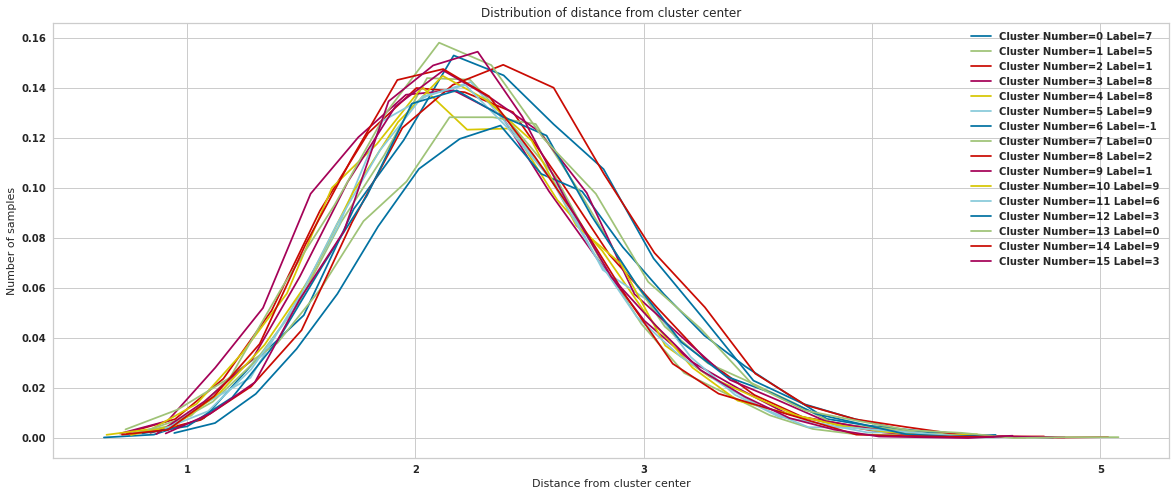

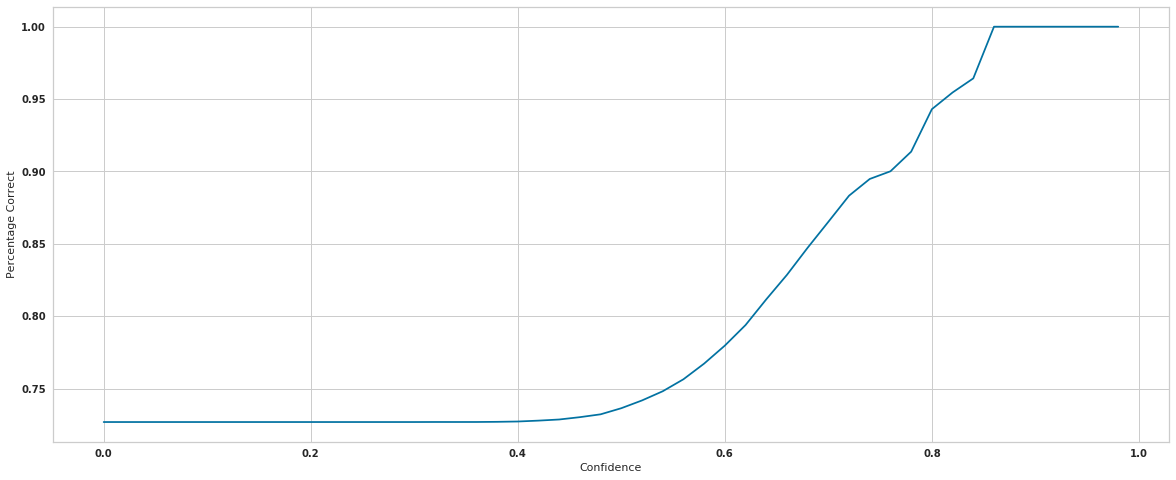

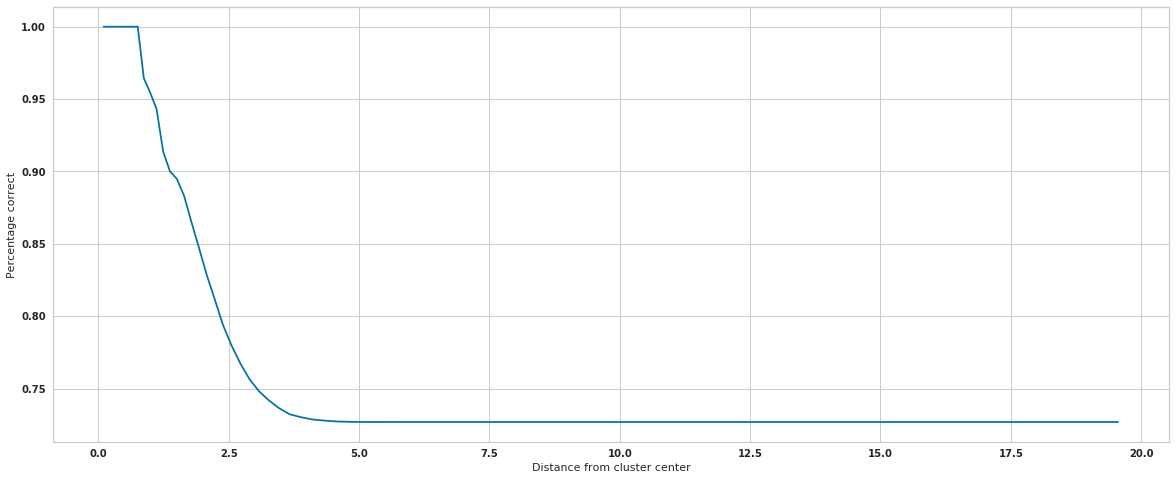

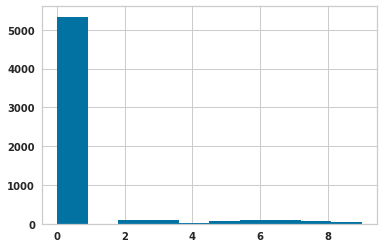

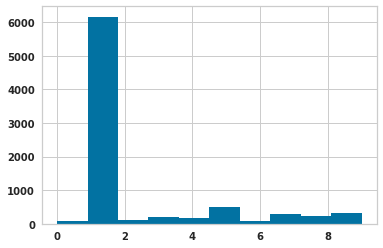

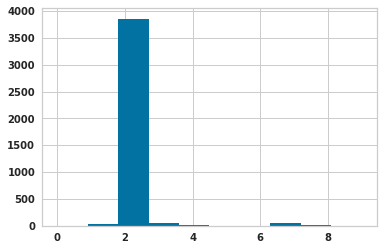

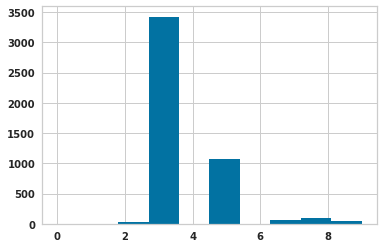

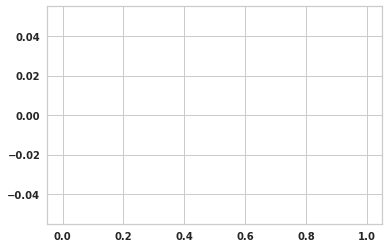

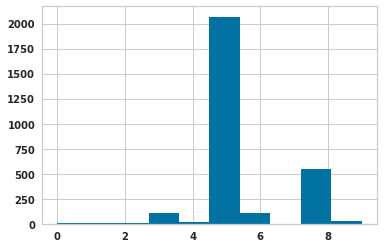

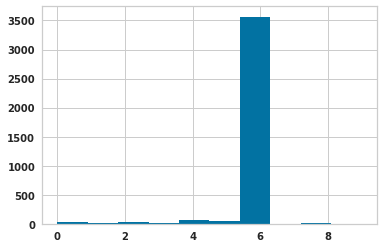

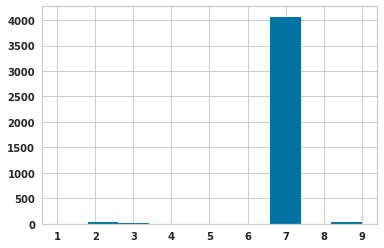

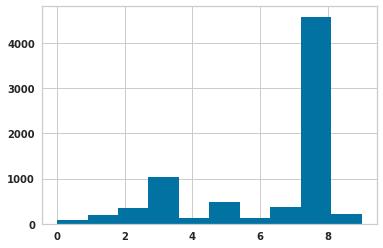

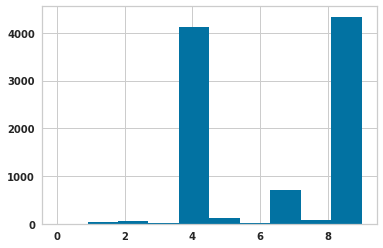

In [140]:
# TODO plot distribution for separate cluster groups
plot_distance_distribution( list(range(num_clusters)))

num_intervals = 50
confidence = np.zeros(num_intervals)
percentage_correct = np.zeros(num_intervals)
for i in range(0, num_intervals):
    confidence[i] = i/num_intervals
    percentage_correct[i] = get_percentage_correct(confidence[i])
    #print(confidence[i], percentage_correct[i])
plt.figure(figsize=(20, 8))
plt.plot(confidence, percentage_correct)
plt.xlabel("Confidence")
plt.ylabel("Percentage Correct")

vfunc = np.vectorize(get_distance)
distances =  vfunc(confidence[1:])
plt.figure(figsize=(20,8))
plt.xlabel("Distance from cluster center")
plt.ylabel("Percentage correct")
plt.plot(distances, percentage_correct[1:])

for i in range(10):
    plt.figure()
    df["label"][(df["manual_annotation"] == i) & (df["manual_annotation_confidence"] >  0.5)].hist()

In [142]:
num_epochs += 1
manual_annotation_file = f"manual_annotation_epoch_{num_epochs - 1:.1f}.csv"
tf.reset_default_graph()
initialize_model_train_and_get_features(experiment_name,
                                        z_dim,
                                        run_id,
                                        create_split,
                                        num_epochs,
                                        num_cluster_config,
                                        manual_annotation_file)
tf.reset_default_graph()

{'NUM_UNITS': [64, 128, 32, 20], 'ROOT_PATH': '/Users/sunilv/concept_learning_exp', 'NUM_DECODER_LAYER': 4, 'Z_DIM': 10, 'BETA': 5, 'DATASET_NAME': 'mnist', 'MODEL_NAME': 'VAE', 'BATCH_SIZE': 64, 'SPLIT_NAME': 'Split_1', 'SUPERVISE_WEIGHT': 150, 'NUM_CLUSTER_CONFIG': 'TWO_TIMES_ELBOW', 'CONFIDENCE_DECAY_FACTOR': 5, 'MANUAL_LABELS_CONFIG': 'USE_CLUSTER_CENTER', 'RECONSTRUCTION_WEIGHT': 1, 'EVAL_INTERVAL': 300, 'ACTIVATION_HIDDEN_LAYER': 'RELU', 'ACTIVATION_OUTPUT_LAYER': 'SIGMOID', 'RUN_ID': 2, 'ID': 1, 'name': 'VAE_MNIST', 'NUM_VALIDATION_SAMPLES': 128}
Loaded manual annotation
Number of samples with manual confidence 56841
INFO:tensorflow:Summary name Negative Log Likelihood is illegal; using Negative_Log_Likelihood instead.
INFO:tensorflow:Summary name K L Divergence is illegal; using K_L_Divergence instead.
INFO:tensorflow:Summary name Supervised Loss is illegal; using Supervised_Loss instead.
INFO:tensorflow:Summary name Total Loss is illegal; using Total_Loss instead.
 [*] Reading

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:9 step:300
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_09_0300/
(64, 28, 28, 1)


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:09 and step:0600 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:9 step:600
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_09_0600/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Running evaluation after epoch:09 and step:0900 


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0

epoch:9 step:900
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/prediction_results//reconstructed_09_0900/
(64, 28, 28, 1)
(64, 28, 28, 1)
Evaluation completed
Saving check point /Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/trained_models/
 [*] Training finished!
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/
/Users/sunilv/concept_learning_exp/semi_supervised_classification/Exp_20_32_128_64_10_TWO_TIMES_ELBOW_2/analysis/


In [ ]:
model = None
tf.reset_default_graph()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        model = VAE(sess,
            epoch=1,
            batch_size=BATCH_SIZE,
            z_dim=z_dim,
            dataset_name=DATASET_NAME,
            beta = exp_config.beta,
            num_units_in_layer=exp_config.num_units,
            log_dir=exp_config.LOG_PATH,
            checkpoint_dir=exp_config.TRAINED_MODELS_PATH,
            result_dir=exp_config.PREDICTION_RESULTS_PATH
               )
        num_steps_completed = model.counter
        print("Number of steps completed={}".format(num_steps_completed))
        num_batches = exp_config.num_train_samples / exp_config.BATCH_SIZE
        epochs_completed = num_steps_completed // num_batches
        print("Number of epochs completed {}".format(epochs_completed))
tf.reset_default_graph()
    
filename  = get_encoded_csv_file(num_units[1], num_units[2], z_dim, int(epochs_completed), "train")
mean_col_names, sigma_col_names, z_col_names,_ = get_latent_vector_column(z_dim)
df = pd.read_csv(os.path.join(exp_config.ANALYSIS_PATH, filename))
z_min = df[z_col_names].min().min()
z_max = df[z_col_names].max().max()
latent_vectors = df[z_col_names].values
print("run_id={} z_min={} z_max={}".format(run_id, z_min, z_max))
print("Latent vectors shape",latent_vectors.shape)

num_clusters = 16
manual_annotation_file_json = os.path.join(exp_config.ANALYSIS_PATH,
                                           f"manual_annotation_epoch_{epochs_completed}.json")
image_filename = exp_config.ANALYSIS_PATH + f"cluster_centers_epoch_{epochs_completed}.png"
manual_annotation_json = None
#Cluster and decode the cluster center
decoded_images, cluster_centers, cluster_labels = cluster_and_decode_latent_vectors(num_clusters,
                                                                                    latent_vectors,
                                                                                    exp_config)
display_cluster_center_images(decoded_images, image_filename, cluster_centers)

In [141]:
num_epochs

9